# Tutorial: Real-Time GPS Tracking using RTL-SDR and Python

#### Andreas Naber  <a class="jp-toc-ignore"></a>

Version 1.0.0, 2024-10-14

### Copyright and Licence  <a class="jp-toc-ignore"></a>

Copyright (c) Andreas Naber \<annappo@web.de\>

This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License ([CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)). To view a copy of this license, visit [https://creativecommons.org/licenses/by-nc-sa/4.0/](https://creativecommons.org/licenses/by-nc-sa/4.0/) or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

## Preface

This tutorial has two objectives: 

- On the one hand, it is intended as an introduction to satellite navigation using the *Global Positioning System* (GPS). The programming of a *Software Defined Radio* (SDR) is used to demonstrate how the radio signals sent by the GPS satellites can be received and processed. For this purpose, the description is structured in the style of an *interactive tutorial* with short explanations and code examples.
  
- On the other hand, the text shall serve as documentation of a Python program for real-time GPS tracking. The code is developed and commented on the basis of many examples and then integrated as Python classes into the scripts. The final program for real-time positioning and tracking has been published separately on Github: [https://github.com/annappo/GPS-SDR-Receiver](#https://github.com/annappo/GPS-SDR-Receiver).  

The tutorial is aimed in particular at people who

- want to acquire theoretical and practical knowledge of satellite navigation,
- prefer *learning by doing* to better understand abstract concepts,
- would like to carry out GPS tracking in real-time based on an SDR,
- enjoy programming of devices.

The instrumental basis is a low-budget USB stick that was originally developed for the reception of radio programs and television via DVB-T (Digital Video Broadcasting - Terrestrial). Its main function is to receive radio signals at an adjustable frequency, digitize them and then transfer the data to a computer via the USB interface. All subsequent steps, in particular the decoding of the information contained in the data, are performed by a computer instead of using analog electronic components of a conventional radio. This approach is known as *Software Defined Radio* (SDR). A USB stick based on an RTL2832U chip (RTL-SDR) can be used to receive signals from GPS satellites though this was not originally intended. Further technical information and first steps for its use can be found in the appendix.

The *Python* programming language is used for data processing. It is characterized by modern design, free availability of powerful modules and quick learnability. With *JupyterLab*, an ideal environment is available for developing clear code and integrating it into the tutorial. For beginners, help on installing the software is provided in the appendix.

The focus of the tutorial is on a step-by-step development of an efficient Python code for measuring and decoding GPS data. The mathematical treatment is limited to the bare essentials in order to keep the text simple and make it easy for beginners to get started. Nevertheless, it is sometimes unavoidable to use advanced methods such as complex numbers and Fourier transforms. For introductions to these methods and more comprehensive treatments of GPS navigation, please refer to the mathematical appendix and the references at the end of the tutorial.

## Table of contents <a class="jp-toc-ignore"></a>

<details>
<summary><b>(click to expand)</b></summary>

* [GPS navigation](#GPS-navigation)
    * [Basics](#Basics)
        * [Satellites and frequencies](#Satellites-and-frequencies)
        * [Navigation principle](#Navigation-principle)
        * [Pseudorange](#Pseudorange)
        * [Satellite positions](#Satellite-positions)
        * [Satellite signals: Gold codes and correlation](#Satellite-signals:-Gold-codes-and-correlation)
        * [C/A codes and code phase](#C/A-codes-and-code-phase)
    * [Data reception](#Data-reception)
        * [Data structure](#Data-structure)
        * [Representation with complex numbers](#Representation-with-complex-numbers)
        * [Doppler effect](#Doppler-effect)
        * [Determination of the Doppler frequency](#Determination-of-the-Doppler-frequency)
        * [Isolation and demodulation of satellite signals](#Isolation-and-demodulation-of-satellite-signals)
        * [Phase of the satellite signal](#Phase-of-the-satellite-signal)
        * [Phase Locked Loop](#Phase-Locked-Loop)
        * [Time required for demodulation](#Time-required-for-demodulation)
    * [Data decoding](#Data-decoding)
        * [Digitization](#Digitization)
        * [Subframes and ephemeris](#Subframes-and-ephemeris)
        * [Satellite orbits and positions](#Satellite-orbits-and-positions)
    * [Positioning](#Positioning)
        * [Pseudoranges of two satellites](#Pseudoranges-of-two-satellites)
        * [Code phase interpolation](#Code-phase-interpolation)
        * [Evaluation of the code phases](#Evaluation-of-the-code-phases)
        * [Error sources and corrections](#Error-sources-and-corrections)
        * [Reference and transmission times](#Reference-and-transmission-times)
        * [Least squares approximation](#Least-squares-approximation)
        * [Positioning with sample data](#Positioning-with-sample-data)
* [GPS tracking using an RTL-SDR](#GPS-tracking-using-an-RTL-SDR)
    * [First steps](#First-steps)
        * [Measurement data](#Measurement-data)
        * [Signal amplitude](#Signal-amplitude)
        * [Frequency analysis](#Frequency-analysis)
        * [GPS antenna](#GPS-antenna)
    * [Noise analysis](#Noise-analysis)
        * [Thermal noise](#Thermal-noise)
        * [Signal-to-noise ratio](#Signal-to-noise-ratio)
    * [Observation of single satellites](#Observation-of-single-satellites)
    * [Observation of many satellites](#Observation-of-many-satellites)
        * [Defined classes](#Defined-classes)
        * [Multiprocessing - parallel data processing](#Multiprocessing---parallel-data-processing)
        * [Which satellites are available? - Frequency sweep](#Which-satellites-are-visible?---Frequency-sweep)
* [Real-time tracking](#Real-time-tracking)
    * [Code modifications](#Code-modifications)
        * [Data reception and decoding](#Data-reception-and-decoding)
        * [Real-time positioning](#Real-time-positioning)
    * [Graphical User Interface](#Graphical-User-Interface)
    * [Installation](#Installation)
* [Appendix](#Appendix)
    * [RTL-SDR: Features and accessories](#RTL-SDR:-Features-and-accessories)
        * [Hardware](#Hardware)
        * [Information on applications](#Information-on-applications)
    * [Python and JupyterLab](#Python-and-JupyterLab)
        * [Windows](#Windows)
        * [Linux](#Linux)
        * [WSL environment](#WSL-environment)
    * [Computer performance](#Computer-performance)
    * [Mathematical additions](#Mathematical-additions)
        * [Complex numbers](#Complex-numbers)
        * [Demodulation](#Demodulation)
        * [Cross correlation using Fourier transforms](#Cross-correlation-using-Fourier-transforms)
        * [Relativistic correction term](#Relativistic-correction-term)
* [Notes](#Notes)
* [References](#References)

</details>


## GPS navigation

Satellite positioning began in the 1960s, initially exclusively for military purposes.$^1$ The *Global Positioning System* (GPS) known today was developed in the USA from 1973 and its operational readiness (initially with 24 satellites) was announced for civilian purposes in 1995. From the year 2000, the GPS system, as available today, was released with an accuracy in the meter range, which led to a steep increase in its use, e.g. for navigation in vehicles. Nowadays, a corresponding electronic chip can be found in almost all smartphones and many (sports) watches. Compared to earlier methods of navigation based on time and latitude measurement,$^2$ the *absolute* accuracy that can be achieved for determining one's own location is incredibly good. As with other highly developed electronic devices, the given availability can be used without having to know the physical and technical background. 

This chapter will explain in detail how this astonishing precision for determining the coordinates of any location on earth is possible. However, the focus is not so much on a general description of the system, as there are many good descriptions of this (see [References](#References)). Rather, it is intended to serve as a guide for determining the location yourself using easily accessible devices and software.

---

1. *Wikipedia, [Global Positioning System](https://de.wikipedia.org/wiki/Global_Positioning_System)*
2. *e.g. by means of star observation, gyroscopes etc.*

### Basics 

#### Satellites and frequencies 

The 31 currently active GPS satellites move on their slightly elliptical orbits at an average height of $h\simeq 20200\,\rm km$ above the ground (mean sea level, [MSL](https://en.wikipedia.org/wiki/Height_above_mean_sea_level)) with an inclination to the equator of 55°. Their orbital period of $T = 11.97\,\rm h$ corresponds exactly to half the sidereal rotation period $T_E$ of the Earth and they move in an easterly direction like the rotating surface of the Earth. Their average orbital speed is $v_b=3.873\,\rm km/s$. They transmit their signals on two frequencies, $f_1=1575.42\,\rm MHz$ ($L1$ band) and $f_2=1227.60\,\rm MHz$ ($L2$ band), but only the first band is open for civilian use. The polarization of the wave is RHCP (right-handed circular polarization). 

#### Navigation principle 
The classic method for measuring the coordinates of a location in geodesy (land surveying) relies on the determination of triangles. It is based on the fact that only three dimensions of a triangle must be given for the unambiguous determination of all its properties.$^1$ We assume that the location to be determined is $X$ and forms a triangle with the already surveyed locations $A$ and $B$. With the coordinates of $A$ and $B$, their mutual distance $\overline{AB}$ is also known, so that only two further quantities have to be measured. These can be, for example, two angles of the triangle or the two distances $\overline{AX}$ and $\overline{BX}$. This provides sufficient information to fix the position of $X$.

Surveying with satellites is somewhat more complex because their locations are not in a given plane, but the information required is similar: the locations $A$, $B$ and $C$ of three satellites must be known and their distances $l_a$, $l_b$ and $l_c$ from the location $X$ are measured (trilateration). To illustrate this, you can imagine that the location $X$ is usually given by the intersection of the three spherical surfaces with the centers in $A$, $B$ and $C$ and radii $l_a$, $l_b$ and $l_c$.$^2$

The better the satellite locations and the measured distances are known, the more accurately the location $X$ can be determined. Or vice versa: both the satellite locations and their distances to the location $X$ must be known to better than $\pm 1\,\rm m$ if you want to determine the coordinates of $X$ within $\pm 1\,\rm m$ accuracy.$^3$ With a typical distance to the satellites of over $20000\,\rm km$ and an average satellite speed of $v_b \simeq 4\,\rm km/s$, this hardly seems possible with "simple" means. How can it be done?

---
1. *A base length is needed once in case of triangulation.*
2. *The intersection of two spherical surfaces is a circle. The intersection of two different circles on the same spherical surface are two crossing points. One of the points is excluded based on plausibility (too far away from Earth).*
3. *Strictly speaking, error propagation should be used here.*

#### Pseudorange 
Very precisely synchronized clocks on the satellites are an important prerequisite for determining their distances to the location $X$. At the same point in time $t_0$ all satellites transmit electromagnetic signals which, due to the finite speed of light of $c \simeq 299792.458\,\rm km/s$, reach the location $X$ with a delay at times $t_a$,$t_b$ and $t_c$ depending on the distances $l_a$, $l_b$ and $l_c$:

 $$
t_a = t_0+l_a/c\,; \quad t_b = t_0+l_b/c \,; \quad t_c = t_0+l_c/c \ .
$$ 

The average transit time of the signals is around $80\,\rm ms$. If a synchronized clock is also available at the location $X$ and the time of transmission $t_0$ is known, the distances $l_i$ to the satellites can be easily calculated from the reception times $t_i$, $i\in \{a,b,c\},$ measured at location $X$ (so-called *pseudo-distances* or *pseudorange*):

$$ l_i = c\cdot(t_i - t_0) \ . $$

Thus, if the spatial coordinates of a location $X$ shall be determined to a precision of $\Delta x \le 1\,\rm m$, the required accuracy $\Delta t$ of the clocks must be at least

$$ \Delta t = \Delta x/c \le 3.3\cdot 10^{-9}\,{\rm s} = 3.3\,\rm ns \ . $$

Such high accuracy, which must be maintained over a long period of time due to the required synchronization, can only be achieved with atomic clocks, i.e. with complex, expensive technology. Atomic clocks are therefore an essential component of all GPS satellites. With a conventional GPS receiver, however, this effort cannot be made, so the deviation of its time from that of the satellites is undefined. In other words, the receiver does not know the exact transmission time $t_0$ for its clock, so it cannot deduce the pseudo-distances from its measured times $t'_a$, $t'_b$ and $t'_c$. 

Instead of $t_0$, however, an additional piece of information can be used as a workaround. This usually is the known position of another satellite $D$ and its reception time $t'_d$.$^1$ The *measured time intervals* $t'_b-t'_a$, $t'_c-t'_a$ and $t'_d-t'_a$ can then be used to determine the position of $X$ as they are independent of $t_0$ and the accuracy of a high-quality quartz timer is sufficient for time intervals of $\le 20\,\rm ms$. $^2$

**We conclude:** To determine the coordinates of $X$ for a point in time $t_0$ to better than $\Delta x \simeq 1\,\rm m$, a) the positions of at least 4 satellites must be known with a precision better than $1\,\rm m$ and b) the reception times must be measured with an accuracy of $\Delta t\le 3.3\,\rm ns$.

---
1. *Alternatively, if known, the geographical altitude $h$ of the location $X$ can also be used as additional information.*
2. *Compared to the previous geometric interpretation, the time differences of arrival (TDOAs) define the measurement geometry here. Each TDOA corresponds to a hyperboloid of revolution and the receiver is located at the point where the hyperboloids intersect ([Wikipedia, GPS - User-satellite geometry](https://en.wikipedia.org/wiki/Global_Positioning_System#User-satellite_geometry)).*

#### Satellite positions

The distances from the location $X$ to the satellites are greater than $20000\,\rm km$ and the satellite's orbital velocity is almost $v_b=4\,\rm km/s$.  How can you then know the satellite locations for a given time $t=t_0$ with an accuracy of 1 m?

First of all, the satellite positions are measured as a function of time with the utmost precision using radar and laser measuring equipment at appropriately equipped ground stations. On the basis of the laws of physics, the elliptical orbits can then be described completely with just a few numbers (parameters) due to the frictionless movement in space. However, due to the required accuracy, even the smallest disturbances, e.g. due to the inhomogeneous mass distribution of the Earth's body, lead to intolerable deviations after a few hours. The orbital data is therefore updated regularly (~ 2 h) in order to maintain the required precision.

How can the receiver at location $X$ obtain these orbit parameters? The elegant solution is that the orbit data is uploaded from the ground stations to the satellites by radio link and the satellites then regularly broadcast their own orbit values as digital data together with the time signals (see [Data reception](#Data-reception)). 

#### Satellite signals: Gold code and correlation
Since, as described, the satellites all send their time signals at exactly the same point in time $t_0$, the question arises as to how the signals can be assigned to the individual satellites in the receiver. A conventional method of differentiation would be to give each satellite its own transmission frequency. However, each satellite would then require its own tuner in the receiver, which would mean a considerable amount of additional electronic work. It is therefore preferable if all satellites use the same carrier frequency and their signals are superimposed in the same data stream after receiption by the receiver.

The key trick to separating the data is that each satellite transmits a repeating signal sequence that uniquely identifies it - a so-called [Gold code](https://en.wikipedia.org/wiki/Gold_code).$^{1,2}$ This consists of a fixed sequence of 1023 so-called *chips* characteristic of the satellite: a non-periodic sequence of binary pulses that (in the satellite's rest system) has an exact temporal length of $1\,\rm ms$. This sequence is called [C/A code](https://en.wikipedia.org/wiki/GPS_signals) (coarse/acquisition code) in GPS parlance.$^3$ The special feature of the Gold codes is that the overlapping codes of different satellites cancel each other out except for a (pseudo-) random noise. They are *orthogonal* to each other. 

The data of a specific satellite is "fished out" of the entire data stream by multiplying it with the satellite's own Gold code. The correct alignment in time for the multiplication (phase adjustment) is determined beforehand using a *correlation* calculation. This method serves as a kind of *pattern recognition* for the specific Gold code in the data stream.

Due to its great importance, the principle of correlation calculation is first explained using an arbitrary sequence $f$ of binary values ($+1$ or $-1$). These are represented graphically with the plot in the following script:

---
1. *The method used is [CDMA](https://en.wikipedia.org/wiki/Code-division_multiple_access) (Code-division multiple access), which belongs to the [spread-spectrum](https://en.wikipedia.org/wiki/Spread_spectrum) techniques.*
2. *The codes are named after their discoverer Robert Gold (1967)*.
3. *The GPS L1 frequency also contains a precision (P) code that is reserved for military use.*

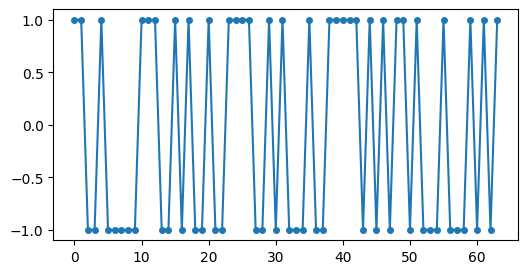

In [4]:
# arbitrary binary sequence

import matplotlib.pyplot as plt
import numpy as np

f = [ 1, 1,-1,-1, 1,-1,-1,-1, 
     -1,-1, 1, 1, 1,-1,-1, 1, 
     -1, 1,-1,-1, 1,-1,-1, 1, 
      1, 1, 1,-1,-1, 1,-1, 1, 
     -1,-1,-1, 1,-1,-1, 1, 1, 
      1, 1, 1,-1, 1,-1, 1,-1, 
      1, 1,-1, 1,-1,-1,-1, 1, 
     -1,-1,-1, 1,-1, 1,-1, 1]

fig = plt.figure(figsize=(6,3))
fig.set_label('Arbitrary binary sequence')
plt.plot(f,'-o',ms=4)
plt.show()

We are now looking for a series of 8 consecutive numbers in the array $f$, e.g.

$$g = [-1,-1,+1,+1,+1,+1,-1,-1]$$

For a general algorithm, we use the property that the square of a real number is always positive or zero. The sum of all squares of the numerical values of $g$ is of course 8,

 $$ \sum_{i=0}^7 g[i]^2 = (-1)^2 + (-1)^2 + (+1)^2 + (+1)^2+ (+1)^2 + (+1)^2 + (-1)^2 + (-1)^2 = 8 \ . $$

Now we multiply $g[i]$ by the first 8 numbers of the data shown in the graph $f[i]$:

\begin{align}
 \sum_{i=0}^7 g[i]\cdot f[i] =&+ (-1)(+1) + (-1)(+1) + (+1)(-1) + (+1)(-1)+ (+1)(+1)& \\
                              &+ (+1)(-1) + (-1)(-1) + (-1)(-1) + (-1)(-1) &= -2 \ . 
\end{align} 

The two sequences of numbers are not equal, so this sum is necessarily less than 8. Only a sequence of values in $f$ that is identical to $g$ can produce a sum of exactly 8. In order to find the sequence of numbers $g$ in the longer sequence $f$ mathematically, we shift the beginning of $f$ by $ \tau = 0,1,2,3,\ldots$, i.e.

$$ C(\tau) = \sum_{i=0}^7 g[i]\cdot f[i+\tau] \quad , \ \tau \in \{0\ldots 56\} \ . $$

The quantity $C(\tau)$ is called the *cross-correlation* $g\star f$ of the series $g$ and $f$. If a value is found for $C(\tau)$ at $\tau=\tau_0$ that corresponds exactly to $\sum_i g[i]^2$, then we have found the number sequence $g$ in the data $f$ starting at the point $\tau_0$! In the following, the correlation function $C(\tau)$ is calculated for our example using the corresponding function of the *numpy* module.

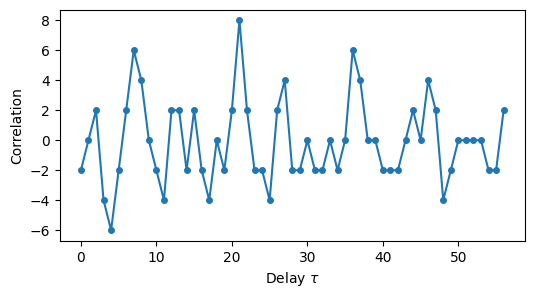

In [6]:
# Example 1: correlation

import matplotlib.pyplot as plt
import numpy as np

g = [-1,-1,+1,+1,+1,+1,-1,-1]

f = [ 1, 1,-1,-1, 1,-1,-1,-1, 
     -1,-1, 1, 1, 1,-1,-1, 1, 
     -1, 1,-1,-1, 1,-1,-1, 1, 
      1, 1, 1,-1,-1, 1,-1, 1, 
     -1,-1,-1, 1,-1,-1, 1, 1, 
      1, 1, 1,-1, 1,-1, 1,-1, 
      1, 1,-1, 1,-1,-1,-1, 1, 
     -1,-1,-1, 1,-1, 1,-1, 1]

c = np.correlate(f,g,mode='valid')   # swapping f and g will result in a
                                     # 'mirrored' plot 

fig = plt.figure(figsize=(6,3))
plt.plot(c,'-o',ms=4)
plt.xlabel('Delay $\\tau$')
plt.ylabel('Correlation')
plt.show()

The correlation function $C(\tau)$ is exactly 8 at $\tau=21$. The 'pattern' we are looking for, the sequence $g$, therefore begins in the data $f$ at the position $\tau=21$. For $\tau=7$ and $\tau=35$, the correlation is $C(7)=C(35) = 6$, indicating that the sequence $f$ is very similar to the pattern $g$ (deviating only by one number), but not identical. 

For the following applications it is important to generalize these findings as in measured data noise is inevitably occuring and an exact match of the data with the pattern searched cannot be expected. As a general rule we can state: The two series $f[i+\tau_0]$ and $g[i]$ have a best possible *similarity* at the delay $\tau_0$ if the cross-correlation $C(\tau)$ has an absolute maximum at $\tau=\tau_0$. A threshold value for the maximum must then be specified which, if exceeded, is considered a match. 

#### C/A codes and code phase

Each of the 31 GPS satellites has its own *C/A code* consisting of 1023 chips and transmitted at a rate of 1.023 Mchip/s, causing the code to repeat every 1 millisecond (in local time of the satellite).$^1$ The codes are generated by a mathematical algorithm published by the U.S. government in the official GPS signal specifications.$^2$ A detailed description and a Python code for the generation of the codes can be found on the website of [natronics](https://natronics.github.io/blag/2014/gps-prn/). For this tutorial we use the already calculated codes in *GPScacodes.py* of the project [learnSDR](https://github.com/gallicchio/learnSDR). 

With the introduction of the correlation function, we are able to demonstrate the special property of the gold codes, their orthogonality. For this purpose we use the C/A codes of the GPS satellites PRN02 and PRN03.$^3$ We generate the data $f$ by repeating the code PRN02 four times and then shifting the start by $\tau=500$. The following script calculates the correlation of the data $f$ with the C/A codes PRN02 and PRN03. 

---

1. *Wikipedia: [GPS signals](https://en.wikipedia.org/wiki/GPS_signals)*
2. [*Global Positioning System Standard Positioning Service Signal Specification, 2nd Edition (June 2, 1995)*](https://www.gps.gov/technical/ps/1995-SPS-signal-specification.pdf)
3. *PRN stands for 'Pseudo Random Noise'*.

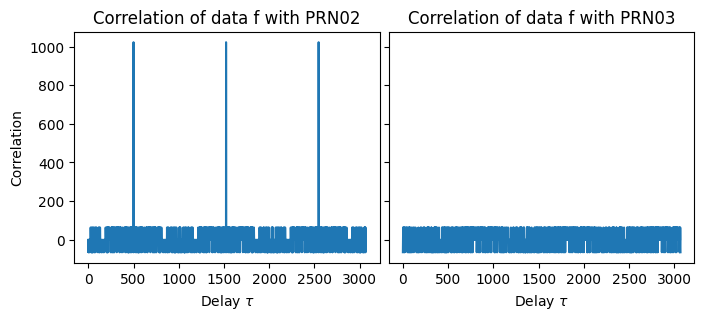

In [8]:
# Example 2: correlation Gold-code
# SPDX-FileCopyrightText: Copyright (C) 2023 Andreas Naber <annappo@web.de>
# SPDX-License-Identifier: GPL-3.0-only

import pycode.cacodes as cacodes              # C/A codes of all satellites
import numpy as np
import matplotlib.pyplot as plt

delay = 500

f = []
for i in range(4):
    f += cacodes.cacode02
f = np.roll(f,delay)

corr01 = np.correlate(f,cacodes.cacode02,mode='valid')
corr02 = np.correlate(f,cacodes.cacode03,mode='valid')

fig,(ax,bx) = plt.subplots(1,2,sharey='row',figsize=(8,3))
fig.canvas.header_visible = False     
fig.subplots_adjust(wspace=.03)
ax.plot(corr01,'-')
ax.set_title('Correlation of data f with PRN02')
ax.set_xlabel('Delay $\\tau$')
ax.set_ylabel('Correlation')
bx.plot(corr02,'-')
bx.set_title('Correlation of data f with PRN03')
bx.set_xlabel('Delay $\\tau$')
plt.show()


The correlation maxima at delays $\tau=500 + n\cdot 1023,\,n=0,1,2$, show that the data $f$ consists of a sequence of C/A codes PRN02 which are shifted compared to the original code by $\tau_0=500$ (left plot). The unit of $\tau_0$ is given in the number of *chips*. Since the time length of the C/A codes during transmission is exactly $1\,\rm ms$, the *time shift* can be calculated as $\Delta t=\tau_0/1023\cdot 1{\rm ms} \simeq 0.489\,\rm ms$. The plot on the right proves that the C/A code of PRN03 is not included in the data $f$.

**Note:** The shift (or delay) $\tau$ later plays an important role in determining the exact time of signal reception by the GPS receicer. The usual term for this quantity in GPS parlance is *code phase*. Unless you are an engineer or a physicist, you may not understand this term. It refers to the fact that a sequence of identical C/A codes represents a periodic function, similar to a sine function. If you compare two periodic functions with the same angular frequency $\omega$, they can be shifted against each other on the time axis, which is then called a *phase shift*. For example, the function $f_1(t)=\sin(\omega\,t+\varphi)$ ist shifted against $f_0(t)=\sin(\omega\,t)$ by the *phase* $\varphi$. If the magnitude of the phase is larger then a full period, $|\varphi| > 2\pi$, it can always be reduced to $\varphi \in [0..2\pi]$ by subtracting $n\cdot 2\pi,\,n \in \mathbb Z,$ due to the given periodicity. The same applies to the *code phase* $\tau$ in a sequence of C/A codes, except that here the periodicity is given by the length of the C/A code of 1023, i.e. $\tau \in [0..1023]$.

### Data reception

#### Data structure

The data sent by the satellites is organized in *frames*, which consist of 1500 bits and whose transmission takes 30 s (transmission rate $50\,\rm bit/s$).$^1$ In addition to the orbital data, they contain further information as, for example, date & time and technical reliability. Each frame is divided in 5 equally long *subframes* of 6 s each. A time reference (GPS time) is sent with each subframe, the exact point in time of which is indicated by the start of a specific bit sequence, the *preamble*. The subframes each contain 10 *words* of 30 bits each. Each *bit* is encoded by 20 gold codes of 1023 chips each and thus has a time length of 20 ms. With a bit change ($1\rightarrow 0$ or $0\rightarrow 1$), the sign of the carrier wave of the radio signal is reversed, i.e. its phase is rotated by 180° (or $\pi$). This modulation method is called [Binary phase-shift keying](https://en.wikipedia.org/wiki/Phase-shift_keying) (BPSK). 

The entire data stream therefore consists exclusively of a sequence of the same C/A code in normal or inverted form. The signs of the C/A codes contain the digitally coded information. By counting the number of C/A codes from the time reference (preamble), the exact time can be determined in the unit $1\,\rm ms$. 

---
1. [*Global Positioning System Standard Positioning Service Signal Specification, 2nd Edition (June 2, 1995)*](https://www.gps.gov/technical/ps/1995-SPS-signal-specification.pdf)

#### Representation with complex numbers

For the transmission the digital data $D_n$ of a satellite $S_n$ is modulated onto a carrier wave of fixed frequency $f_1=1575.42\ \rm MHz$.$^1$ Therefore, in the receiver the carrier frequency must first be removed (demodulation) in order to obtain the desired information. This is done using analog technology in the tuner of the receiving device. However, since all satellites $S_n,\ n\in{2\ldots 32},$ transmit their data at the same frequency, they are available after reception and digitization only as an overlay $D_{\rm all}$ of the individual data streams $D_{\rm n}$ from the currently visible satellites, 

$$ D_{\rm all} = \sum_n D_{\rm n} \ . $$

Ideally, the carrier frequency would be completely removed with perfect phase and frequency matching, as happens with a good signal from a radio station, for example. Then a simple data set of real numbers would completely capture the information it contains. However, this is not possible with GPS reception. The satellites move relative to the receiver at different speeds $v_{\rm n}$, as a result of which their transmitted carrier frequencies $f_1$ experience different frequency shifts and arrive at the receiver at frequencies $f_{1,\rm n}$ (Doppler effect). In order to still capture the complete information, the signal at each reading point in time is digitized by two values $I$ and $Q$ (demodulation of $f_1$ with 0° and 90° phase shift)$^2$. These are represented as a data stream of *complex numbers* $Z(t)$ with$^3$

$$Z(t) = I(t) +i\,Q(t) \ . $$

It is perhaps helpful to emphasize at this point that the raw data available in this way is practically indistinguishable from noise (pseudo-noise). By superimposing the data signals of many satellites, the information contained therein is almost perfectly encrypted. The key to decoding is the specific C/A code of a satellite.

---
1. *As a result frequency and phase of the wave fluctuate slightly. The bandwidth in frequency space at $f_1$ is $\Delta f = 2.046\,\rm MHz$.*
2. *see [Demodulation](#Demodulation) in the Appendix.*
3. *see [Complex numbers](#Complex-numbers) in the Appendix.*

#### Doppler effect

In order to extract the (complex-valued) data $D_{\rm n}$ of a single satellite $S_n$ from $D_{\rm all}$, $D_{\rm all}$ must be multiplied by the specific C/A code $G_{\rm n}$ of the satellite with the correct time alignment (code phase). However, this cannot be done immediately, as the relative speed $v_{\rm n}$ of $S_{\rm n}$ to the receiver in radial direction$^1$ shifts the received frequency $f_{1,\rm n}$ compared to the transmitted carrier frequency $f_1$ due to the *longitudinal Doppler effect*, 

 $$ f_{\rm n}= f_{1,\rm n}-f_1 = \left(\sqrt{\frac{1+v_{\rm n}/c}{1-v_{\rm n}/c}}-1\right)\cdot f_1 \ . $$

Because of $v_{\rm n}\ll c$, the calculation can be simplified to

 $$ f_{\rm n} \simeq \frac{v_{\rm n}}{c}\cdot f_1 \ . $$

This frequency change $f_{\rm n}$ is called *Doppler frequency* for simplicity's sake in this tutorial. As a result, after the carrier frequency $f_1$ has been removed, the satellite signals are still affected by a sinusoidal oscillation with an unknown phase offset $\phi_n$ and frequency $f_{\rm n}$ of up to $\pm 5\,\rm kHz$ with $v_{\rm n,max} = \pm 973\,\rm m/s$. 

A further complication is that the velocities $v_{\rm n}$ and thus also $f_{\rm n}$ are not constant, as the positions of the satellites relative to the receiver change in the sky. We estimate the magnitude of the temporal change as follows: During its orbit of $12\,\rm h$, a satellite is at best visible to the receiver for about $6\,\rm h$. If it appears on the horizon, it moves towards the receiver and then has a maximum Doppler frequency of $+5\,\rm kHz$. If, on the other hand, it disappears after $6\,\rm h$, the minimum possible frequency is $-5\,\rm kHz$. This results in an *average rate of change* of the Doppler frequency of around $-0.5\,\rm Hz/s$. The rate of change itself also changes over time, but all changes associated with $f_n$ are slow for a *stationary receiver*. This becomes important later for the correction of the frequency shift.

For the next steps to decode the data in $D_{\rm n}$, the sinusoidal *amplitude modulation* as a result of the Doppler effect must first be removed. Otherwise, sign changes would occur in the middle of the C/A codes and decoding would not be possible. If the Doppler frequency $f_{\rm n}$ were known, this could be done simply by multiplying $D_{\rm n}$ by the complex exponential factor ${\rm e}^{-i2\pi f_{\rm n}t}$ (see Appendix [Demodulation](#Demodulation)) . However, the actual value of $f_{\rm n}$ can only be determined after isolating $D_{\rm n}$ from the total data $D_{\rm all}$. The way out of this dilemma is discussed in the following chapter.

---
1. *This refers to the velocity component in the direction of the receiver. The angular velocity does not contribute to the frequency change.*

#### Determination of the Doppler frequency

The following procedure is used: It is known that the Doppler frequency $f_{\rm n}$ lies between $f_{\rm min}=-5000\,\rm Hz$ and $f_{\rm max}=+5000\,\rm Hz$. Select a starting frequency $f_n$ from this range, e.g. $f_n = f_{\rm min}$, and multiply a short range of the data $D_{\rm all}$, which does not have to be longer than the C/A code, by a complex exponential factor, i.e.

$$ H_{\rm n}(t) = {\rm e}^{-i 2\pi f_{\rm n} t}\cdot D_{\rm all}(t) \ . $$

The complex correlation function $C_n(\tau)$ of this data is then calculated using the C/A code $G_{\rm n}$ of the satellite. As a substitute for the sum expression of discrete data, the *correlation integral* valid for complex numbers is given here for the sake of simplicity,

$$ C_n(\tau) = G_{\rm n}\star H_{\rm n} = \int G_{\rm n}^\ast(t) H_{\rm n}(t+\tau)\,{\rm d}t \ . $$

In it, $G_{\rm n}^\ast(t)$ is the *complex conjugate* function to $G_{\rm n}(t)$.$^1$ Regarding $C_n(\tau)$, a decision is now made as to whether the correlation maximum found provides sufficiently reliable evidence for the C/A code $G_{\rm n}$ in the data $D_{\rm all}$:

- **If yes**, a frequency $f_{\rm n}$ have been found that is already close to the actual Doppler frequency and can be improved now in small steps. The shift $\tau_n$ found for the correlation maximum can be used to extract the data $D_{\rm n}$ from $H_{\rm n}$. This is shown in the next chapter.
- **If no**, then $f_{\rm n}$ is changed by an increment of e.g. $\Delta f_{\rm step}=200\,\rm Hz$ and the calculation described starts again.

Once the entire frequency interval $[f_{\rm min},f_{\rm max}]$ has been run through, either a signal has been discovered or it has been found that this satellite is currently not visible to the receiver.

The following script demonstrates the calculation method using *measured raw data* (stream of I/Q values). Move the *slider* for the Doppler frequency until you obtain a clear correlation maximum. A total of 11 satellites have left their traces in the data stream. You can change the number of the satellite *satNo* $\in [2,32]$ in the code. 

**Note:** The calculation of the correlation is done here, unlike previously shown, by means of *Fast Fourier Transforms*.$^2$ A power of two is required as the data length. The (complex) measurement data was recorded using an *RTL-SDR* with a sample rate of $2.048\,\rm MS/s$ (two bytes, I and Q, per sample) and the length of the C/A codes in the data is (approximately) $2048\,\rm S$. Therefore, the local (real-valued) C/A codes with an original length of $1023\,\rm Byte$ is interpolated to a length of $2048\,\rm Byte$ (using the *GPSCacodeRep* function). In contrast to the previous correlation calculations the result is complex-valued. 

---
1. *i.e. all complex numbers $a+ib$ of $G_n$ become $a-ib$ in $G_n^\ast$.*
2. *This is described in detail in the appendix [Cross correlation using Fourier transforms](#Cross-correlation-using-Fourier-transforms) .*

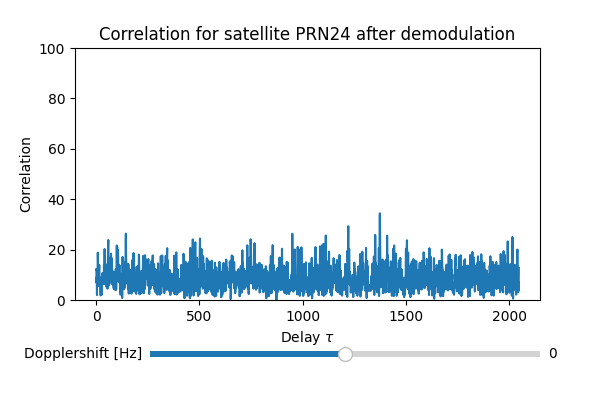

In [5]:
# Example 3: correlation C/A-code with data

%matplotlib widget

import pycode.gpslib_tutorial as gpslib
from scipy.fft import fft, ifft
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

satNo = 24
dopplerFreq = 0

codeSamples = 2048
NCopies = 1
NGPS = NCopies*codeSamples
SAMPLE_RATE = 2.048e6                                         # per second 
SEC_TIME = np.linspace(1,NGPS,NGPS,endpoint=True,
                       dtype=np.complex64)/SAMPLE_RATE        # in s

DATA_FILE = 'data/230914_data_24s.bin'


def readData(dataFile,ns,smpNo):
    i = 0
    with open(dataFile,'rb') as file:
        while i < smpNo:
            byteData = np.fromfile(file,dtype=np.uint16,count=ns)
            im,re = np.divmod(byteData,256)
            data = np.asarray(re+1j*im,dtype=np.complex64)/127.5 - (1+1j)            
            i += 1
    return data

def fftCorrelate(data,cacode): 
    fftData = fft(data)    
    fftCacode = fft(cacode)
    fftCorr = fftData*np.conjugate(fftCacode) 
    corr = ifft(fftCorr)
    return corr

def demodDoppler(data,dopplerFreq):                          
    factor = np.exp(-1j*(2*np.pi*dopplerFreq*SEC_TIME))
    return factor*data

def calcCorr(freq):
    data = demodDoppler(RAWDATA,freq)                    
    corr = fftCorrelate(data,cacodes)
    return abs(corr)


SMP_NO = 2
RAWDATA = readData(DATA_FILE,NGPS,SMP_NO)
cacodes = gpslib.GPSCacodeRep(satNo,codeSamples,NCopies,0)                                        

fig, ax = plt.subplots(figsize=(6,4))
line, = ax.plot(calcCorr(dopplerFreq))
ax.set_xlabel('Delay $\\tau$')
ax.set_ylabel('Correlation')
ax.set_title('Correlation for satellite PRN%02d after demodulation' % (satNo))
ax.set_ylim(0,100)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom=0.25)
fig.canvas.header_visible = False   

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Dopplershift [Hz]',
    valmin=-5000,
    valmax=+5000,
    valinit=dopplerFreq,
)

# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(calcCorr(freq_slider.val))
    fig.canvas.draw_idle()

# register the update function for slider
freq_slider.on_changed(update)

plt.show()

#### Isolation and demodulation of satellite signals

With the help of the method described, two important pieces of information are finally available for a satellite $S_n$:
- the Doppler frequency $f_{\rm n}$ and
- the shift $\tau_n$ (code phase) of the C/A code in the data $D_{\rm n}$ regarding the beginning of the stream.

Another variable that is required later for decoding the data is the *phase offset* $\phi_n$ of the Doppler oscillation. However, this can only be determined after the satellite signal $D_n$ has been isolated, as it is hidden in the data channels $I$ and $Q$.$^{1}$ 

We now describe the situation in more detail: Let $V$ be the set of all (visible) satellites that have generated signals in $D_{\rm all}$. With $n\in V$, $D_n$ is the signal of a satellite $S_{\rm n}$ and $f_n$ is its Doppler frequency, 

$$ D_{\rm n}(t) = A_{\rm n}(t)\,{\rm e}^{i 2\pi f_{\rm n}t} \ . $$

In this, the amplitude $A_{\rm n}$ is a complex variable that contains the phase offset $\phi_{\rm n}$ of the Doppler oscillation,

$$ A_{\rm n}(t) = |A_{\rm n}|\,{\rm e}^{i \phi_{\rm n}} \ . $$

After demodulation as described in the previous chapter, you get 

$$ 
H_{\rm n}(t) = {\rm e}^{-i 2\pi f_{\rm n} t}\cdot \sum_m D_{\rm m}(t) 
             = A_{\rm n}(t) + {\rm e}^{-i 2\pi f_{\rm n} t}\cdot \sum_{m,m\ne n} D_{\rm m}(t)   
$$
To decode the data in $A_{\rm n}$, an array $G_{\rm n,rep}$ of the same length as $H_{\rm n}(t)$ is generated, which consists of repeating C/A codes $G_{\rm n}$. To align with the C/A codes of the data in $A_{\rm n}$, $G_{\rm n,rep}$ is shifted in time by $\tau_n$, resulting in $G_{\rm n,rep}^\tau$.

![alt text](figures/cacodes.png)

For the further procedure, imagine that the two arrays $A_{\rm n}$ and $G_{\rm n,rep}^\tau$ lie on top of each other, as in the illustration.$^2$ Then the elementary building blocks of the arrays, their identical C/A codes $G_{\rm n}$, are also perfectly aligned with each other. In contrast to $G_{\rm n,rep}^\tau$, the C/A codes in $A_{\rm n}$ exist in two forms, normal and inverted (highlighted in gray). Multiplication of superimposed C/A codes therefore generates either $+1$ or $-1$ for all *chips* contained in $G_{\rm n}$. If we multiply $G_{\rm n,rep}^\tau$ and $A_{\rm n}$ with each other, then the same signal $+1$ or $-1$ is generated for the temporal length of a C/A code of $1\,\rm ms$. The resulting sequence of binary pulses then corresponds to the binary code being searched for, however it is still given as a digitized analog signal $P_{\rm n}(t)$,

$$ P_{\rm n}(t) = G_{\rm n,rep}^\tau\cdot A_{\rm n}(t) \ . $$

Overall, however, after multiplying $H_{\rm n}$ by $G_{\rm n,rep}^\tau$ we get

$$
H_{\rm n}^\prime(t) = G_{\rm n,rep}^\tau\cdot H_{\rm n}(t) = 
                      P_{\rm n}(t) + \sum_{m,m\ne n} G_{\rm n,rep}^\tau\cdot A_{\rm m}(t)\,{\rm e}^{i 2\pi (f_{\rm m}-f_{\rm n})t} .
$$

This also contains the signals $A_{\rm m}$ of all other visible satellites. Here, multiplication by $G_{\rm n,rep}^\tau$ only produce *pseudo-noise*, as the C/A codes in the $A_{\rm m}$ do not coincide with $G_{\rm n}$. However, due to the large number of satellites, the average amplitude of this noise may be greater than $P_{\rm n}$. In addition, there is thermal noise and unwanted signals from external sources. Therefore, the information $P_{\rm n}$ in $H^\prime_{\rm n}$ is initially completely hidden.

To uncover $P_{\rm n}$, it is now used that over a length of a C/A code all values are equal, either +1 or -1. The mean value over this length therefore is also +1 or -1. In contrast, the mean value of the noise contributions over the same length is close to zero. Since the averaging leads to a considerable reduction of the noise amplitude, the signal-to-noise ratio is much improved for most satellites. Furthermore, after replacing the 2048 samples of a C/A code by their mean value, a significant reduction in the amount of data is obtained. One complex sample value now represents the temporal length of a C/A code of $1\,\rm ms$.

The script below performs the corresponding data processing for the measurement data already used before. The results are shown over time periods of $128\,\rm ms$ each, which is equivalent to a data length of complex numbers of 128$\cdot$2048 samples. As compared to the previous script, the function *decodeData()* is added. Here the data are first multiplied by the C/A codes shifted by $\tau_n$ and then averaged as described.

In addition to the correlation diagram, the real and imaginary parts of the data signal are displayed in a second plot. The sliders below the plots are used to optimize the result. Their value range is small to allow a precise setting of the variables. The Doppler frequency, for example, must be found with an accuracy of around 1 Hz. The satellite signal to be investigated can be specified by the global variable *satNo* at the beginning of the script. The variable *codePhase* should be set to the value for $\tau_n$ found with the correlation.$^3$ The phase offset $\phi_{\rm n}$ of the Doppler signal can also be changed using the slider. This changes the proportions of the data signal for the real and imaginary parts. It should be set such that the signal in the imaginary part is vanishing. Then the amplitude you are looking for is located undivided in the real part.

Such a state of the data channels $I$ and $Q$ is ideal for evaluating the coded information. As a reference for a later discussion in chapter *Noise analysis*, it is noted here that in the case of a good signal, the *signal-to-noise ratio* $S/N$ for the real part alone is typically given by $S/N \simeq 10$.

---
1. *see [Demodulation](#Demodulation) in the appendix*
2. *Since the amplitude $A_{\rm n}$ is complex, it actually consists of two arrays.*
3. *After enlarging the graph, the value can be read off very precisely.*

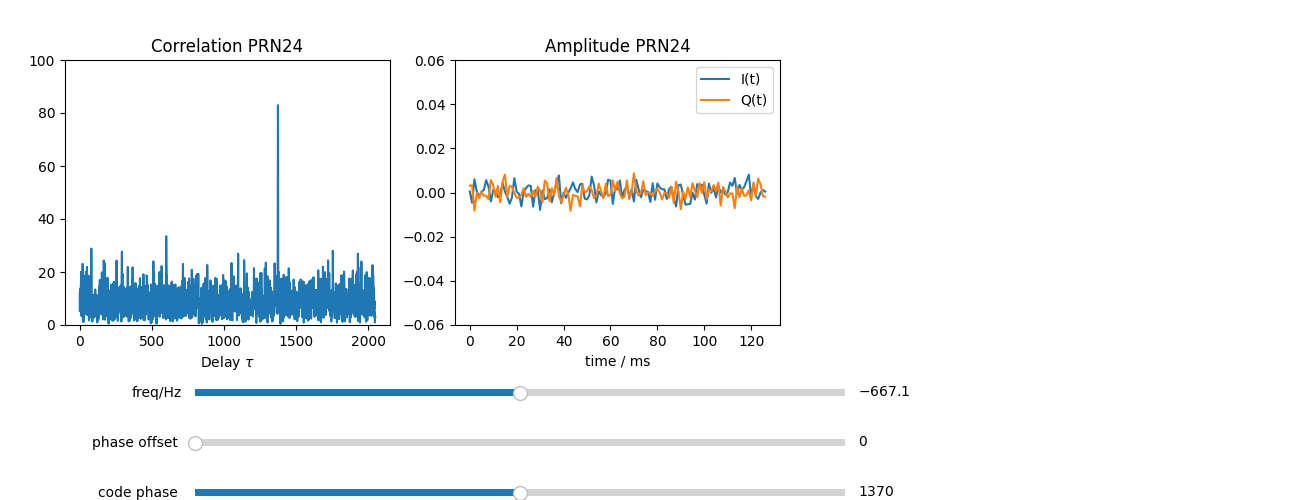

In [9]:
# Example 4: Demodulation of satellite data

%matplotlib widget

import pycode.gpslib_tutorial as gpslib
from scipy.fft import fft, ifft
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# --- you can change the following variables ----

satNo = 24                   # possible are: 24,15,12,19,13,17,10,23,22,25,32
codePhase = 1370             # put in the measured value from the correlation 
                             # for the given satellite
SHOW_PHASE_PLOT = False
REBUILD_PHASE = False

# ----------------------------------------------

codeSamples = 2048
NCopies = 128
NGPS = NCopies*codeSamples
SAMPLE_RATE = 2.048e6                                            # per second 

SEC_TIME = np.linspace(1,NGPS,NGPS,endpoint=True,
                       dtype=np.complex64)/SAMPLE_RATE           # in s

DATA_FILE = 'data/230914_data_24s.bin'

DF = {24:-667.1,15:-4030.0,12:+1675.0,19:-235.0,13:-4598.0,17:-2319.0,
      10:-1262.0,23:-3345.0,22:-4026.0,25:+2852.0,32:+2648.0 }
dopplerFreq = DF[satNo]
dopplerPhase = 0

# -----------------------------------------------

def readData(dataFile,ns,smpNo):
    i = 0
    with open(dataFile,'rb') as file:
        while i < smpNo:
            byteData = np.fromfile(file,dtype=np.uint16,count=ns)
            im,re = np.divmod(byteData,256)
            data = np.asarray(re+1j*im,dtype=np.complex64)/127.5 - (1+1j)            
            i += 1
    return data

def fftCorrelate(data,cacode): 
    fftData = fft(data)    
    fftCacode = fft(cacode)
    fftCorr = fftData*np.conjugate(fftCacode) 
    corr = ifft(fftCorr)
    return corr

def demodDoppler(data,freq,phase,N):                          
    factor = np.exp(-1j*(2*np.pi*freq*SEC_TIME[:N]+phase/180*np.pi))
    return factor*data[:N]

def calcCorr(freq):
    satData = demodDoppler(RAWDATA,freq,0,codeSamples) 
    corr = fftCorrelate(satData,cacodes[:codeSamples])
    return abs(corr)

def decodeData(delay,freq,phase):
    satData = demodDoppler(RAWDATA,freq,phase,NGPS)
    data = np.roll(satData,-delay)
    signal = data*cacodes
    res = []
    for i in range(NCopies-1):
        m = np.mean(signal[i*codeSamples:(i+1)*codeSamples])
        res.append(m)
    res = np.asarray(res,dtype=np.complex64)
    return res

def rebuildPhase(phase):
    minDiff = 2.0
    dp = 0
    n = len(phase)
    realPhase = np.copy(phase)
    for i in range(1,n):                         
        delta = phase[i]-phase[i-1]
        dp -= np.sign(delta) if abs(delta) > minDiff else 0            
        realPhase[i] += dp*np.pi
    return realPhase

def calcPhase(signal):
    signalPhase = np.arctan(signal.imag/signal.real)
    if REBUILD_PHASE:
        signalPhase = rebuildPhase(signalPhase)
    return signalPhase    

SMP_NO = 2
RAWDATA = readData(DATA_FILE,NGPS,SMP_NO)
cacodes = gpslib.GPSCacodeRep(satNo,codeSamples,NCopies,0)        

# --- code for plots ----------

df_min = dopplerFreq - 50
df_max = dopplerFreq + 50

cp_min = codePhase - 20
cp_max = codePhase + 20

fig = plt.figure(figsize=(13,5))
fig.canvas.header_visible = False      # hide header
fig.subplots_adjust(left=0.05)         #, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
spec = fig.add_gridspec(1,3)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])

if SHOW_PHASE_PLOT:
    ax3 = fig.add_subplot(spec[0, 2])

line1, = ax1.plot(calcCorr(dopplerFreq))
ax1.set_xlabel('Delay $\\tau$')
#ax1.set_ylabel('Correlation')
ax1.set_title('Correlation PRN%02d' % (satNo))
ax1.set_ylim(0,100)
#ax1.set_xlim(codePhase-100,codePhase+100)

signal = decodeData(codePhase,dopplerFreq,dopplerPhase)
line2, = ax2.plot(signal.real,label='I(t)')
line3, = ax2.plot(signal.imag,label='Q(t)')
ax2.legend()

ax2.set_xlabel('time / ms')
#ax2.set_ylabel('Amplitude')
ax2.set_title('Amplitude PRN%02d' % (satNo))
ax2.set_ylim(-0.06,+0.06)

if SHOW_PHASE_PLOT:
    signalPhase = calcPhase(signal) 
    line4, = ax3.plot(signalPhase/np.pi*180)
    ax3.set_xlabel('time / ms')
    ax3.set_title('Phase PRN%02d' % (satNo))
    ax3.set_ylim(-95,95)
    
    
# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom=0.35)

axFreq = fig.add_axes([0.15, 0.2, 0.5, 0.03])
freq_slider = Slider(
    ax=axFreq,
    label='freq/Hz',
    valmin=df_min,
    valmax=df_max,
    valinit=dopplerFreq,
)
    
axPhase = fig.add_axes([0.15, 0.1, 0.5, 0.03])
phase_slider = Slider(
    ax=axPhase,
    label='phase offset ',
    valmin=0,
    valmax=360,
    valinit=dopplerPhase,
)

axDelay = fig.add_axes([0.15, 0.0, 0.5, 0.03])
delay_slider = Slider(
    ax=axDelay,
    label='code phase ',
    valmin=cp_min,
    valmax=cp_max,
    valstep=1,
    valinit=codePhase,
)

# The function to be called anytime a slider's value changes
def update(val):
    line1.set_ydata(calcCorr(freq_slider.val)) 
    signal = decodeData(int(delay_slider.val),freq_slider.val,phase_slider.val)
    line2.set_ydata(signal.real)
    line3.set_ydata(signal.imag)
    if SHOW_PHASE_PLOT:
        signalPhase = calcPhase(signal)
        line4.set_ydata(signalPhase/np.pi*180)            
    fig.canvas.draw_idle()    

freq_slider.on_changed(update)
delay_slider.on_changed(update)
phase_slider.on_changed(update)

plt.show()

#### Phase of the satellite signal

The measurement data contains two data channels, $I$ and $Q$, as the real part and imaginary part of complex numbers. The information $P(t)$ actually sought is, as shown above, distributed over these two channels by$^1$

$$ I(t) = P(t)\,\cos\phi \quad\text{and}\quad Q(t) = P(t)\,\sin\phi \ . $$

The time-dependent phase $\phi(t)$ of the signal can then be determined by

$$\phi(t) = \arctan\frac{Q(t)}{I(t)} \ . $$

The function $P(t)$, which has steep edges, is cancelled by the division. Hence, if the phase were a constant, time-independent number $\phi_{\rm n}$, it could be easily calculated. However, the phase is closely linked to the demodulation of $f_{\rm n}$, and since this is only partly successful and the Doppler frequency $f_n$ also grows slowly in time (see [Doppler effect](#Doppler-effect)), an amplitude modulation with a low frequency $\Delta f$ usually remains. Therefore, the phase typically varies linearly with time $t$,

$$\phi(t) = \phi_{\rm n} + 2\pi \Delta f\cdot t \ .$$

This can be illustrated using again the previous script. After setting the parameter *SHOW_PHASE_PLOT = True* a third plot with the phase $\phi(t)$ appears in the output. The slider for the phase offset $\phi_{\rm n}$ shifts the plot on the y-axis by the selected value. The Doppler frequency $f_{\rm n}$ can be almost perfectly determined by trial and error with the condition that the amplitude $P(t)$ is a series of binary pulses and the phase is constant except for the noise. With the slider for the phase offset $\phi_{\rm n}$ you can then adjust the phase curve $\phi(t)$ to be close to zero. The imaginary part $Q(t)$ is then also zero and the desired signal $P(t)$ is completely in the real part $I(t)$. If you then increase the frequency $f$ again with the slider in small steps, the phase $\phi(t)$ grows linearly with an ever-increasing slope up to $90^\circ$, whereupon it jumps suddenly to $-90^\circ$. The greater the frequency deviation $\Delta f$, the more jumps appear in the curve. The sign of $\Delta f$ can be derived from the direction of the jump.

The measured time course of $\phi(t)$ is therefore well suited for correcting the deviation $\Delta f = f-f_{\rm n}$ from the actual Doppler frequency $f_{\rm n}$. However, a curve shape for $\phi(t)$ without jumps would be preferable. The jumps are a consequence of the periodicity of the trigonometric functions - the calculation of the argument with the inverse function *arctan* is not unique because $n\cdot\pi$ ,$\,n\in \mathbb{Z}$, can always be added. To obtain a reconstruction of the linear response, we use an algorithm based on the assumption that phase jumps above a certain noise threshold $\Delta\phi_s$ do not occur in the real signal. It requires, however, that the signal in $P(t)$ is significantly greater than its noise.

In the previous script set *REBUILD_PHASE = True* to activate the reconstruction of the *real* phase progression $\phi(t)$. You can use the widget tools on the left to adjust the minimum and maximum in the phase plot.

#### Phase Locked Loop

Let us briefly summarize the previous procedure for extracting the information of $S_{\rm n}$ from the data stream $D_{\rm all}$:

1. To approximately determine the Doppler frequency $f_{\rm n}$, short data sections are systematically demodulated for many frequencies $f$ within $\pm 5\,\rm kHz$ and the correlations with the C/A code $G_{\rm n}$ are calculated. This is referred to as a *frequency sweep*. In addition to $f\simeq f_{\rm n}$, the code phase $\tau_{\rm n}$ is obtained as further information.
2. A *data stream* $D_{\rm n}$ within $D_{\rm all}$ with time length $T_{\rm cyc}$ is demodulated by multiplication of $D_{\rm all}$ by the complex factor ${\rm e}^{-i\,2\pi f\,t}$. 
3. The amplitude signal of $D_{\rm n}$ is obtained by first multiplying the stream with a sequence of repeated C/A code aligned by $\tau_{\rm n}$ and then averaging over the length of each C/A code. 
3. The averaged amplitude signal with a remaining modulation $\Delta f = f_{\rm n} - f$ is used to determine the time-dependent phase $\phi(t)$. 

A Python script was used to demonstrate how the remaining amplitude modulation can be removed using $\phi(t)$ and how the phase offset $\phi_{\rm n}$ is determined. In the script the measurement data are available as a file on a storage medium, so that the values for $f_{\rm n}$ and $\phi_{\rm n}$ can be iteratively optimized for each individual data stream to obtain the binary coded signal $P(t)$. However, our aim is to evaluate the information from at least 4 satellites in real time during data acquisition. An iteratively optimized calculation of each individual data stream is therefore neither possible nor sensible using conventional computers.

**Control loop**

Instead, after obtaining $f_{\rm n}$ and $\phi_{\rm n}$, these variables are used to decode the next data stream and further optimized there. As these quantities have already changed values in the new stream, they must be further improved and adjusted with each new stream until continuous decoding can finally be achieved through almost constant small changes. In control engineering, such a process is called a (here negative) *feedback*. The aim is to adapt an *actual* output of a process variable (*PV*) to a desired value or *setpoint* (*SP*). The deviation or *error* between *SP* and *PV* serves as measure for the correction of *control variables*. The greater the error, the greater the correction for the control variables must be. In the ideal case, the error is always close to zero with minimal fluctuations.

The phase $\phi(t)$ is obviously suitable as a process variable $PV(t)$. The desired setpoint is then $SP = 0$. If the phase is close to zero everywhere for the considered stream of length $T_{\rm cyc}$ except for the unavoidable noise, then the imaginary part $Q(t)$ of the demodulated data also becomes zero and the (still analog) information $P_n(t)$ is completely present in the real part. As the phase is constantly compared with the setpoint, this control process is called a *phase locked loop* (PLL). The control variables in this process are the phase offset $\phi_{\rm n}$ and the Doppler frequency $f_{\rm n}$. Both are constantly adjusted in the feedback process according to the measured error. The following describes how this correction is done. 

**Phase correction**

Compared to frequency correction, phase correction is quite simple to calculate. With the measured value $\phi(t\!=\!T_{\rm cyc})$ at the end of the data stream, the value deviating from zero that is required to correct the phase offset is already available. However, due to the noise, it makes sense to average over several values at the end of the stream,

$$ \Delta\phi_n = \bar\phi(t\!=\!T_{\rm cyc}) \ . $$

The corrected phase offset for the next stream is then obtained by

$$ \phi^\prime_{\rm n} = \phi_{\rm n} - \Delta\phi_n \ . $$


**Frequency correction**

It is useful to distinguish between two cases: a) large phase deviations, and b) small deviations within which the decoding is hardly disturbed.
 
*a) Large phase deviations* are the result of a large frequency deviation $\Delta f = f_{\rm n}-f$. As discussed before, the amount of the phase change $\Delta\phi$ then increases approximately linearly with time $t$ and reaches its maximum $\Delta\phi_{\rm max}$ at the end of the *cycle time* $T_{\rm cyc}$. The current frequency deviation $\Delta f$ is then calculated as

$$ \Delta f = \frac{1}{2\pi}\,\frac{\Delta\phi_{\rm max}}{T_{\rm cyc}} $$ 

For $T_{\rm cyc} = 32\,\rm ms$ this results in $\Delta f \simeq 5\,{\rm Hz}\cdot \Delta \phi_{\rm max}$. To reduce the influence of the noise, the time average $\bar\phi$ can be used instead of the maximum $\Delta\phi_{\rm max}$ with $\bar\phi \simeq 0.5\,\Delta\phi_{\rm max}$, so that

$$\Delta f = g_1\cdot \bar\phi  \ . $$

with the *gain factor* $g_1 = 10\,\rm Hz$ for $T_{\rm cyc}=32\,\rm ms$. If the frequency correction is carried out with a much larger gain factor, an error with opposite sign may occur in the next stream and the deviation may even increase. If a significantly smaller factor than $10\,\rm Hz$ is used, the desired convergence $\Delta f\rightarrow 0$ will take significantly longer or not be achieved at all due to the continuous frequency drift of $f_{\rm n}$.

*b) For small phase deviations* within the length of a stream (cycle time $T_{\rm cyc}$), the change is no longer a linear function of time. In addition to the frequency drift of $f_{\rm n}$, external influences and noise can be decisive. In the discussion of the Doppler frequency, the drift was roughly estimated to max. $\Delta f \simeq 1\,\rm Hz$, i.e. phase changes of about $\Delta\phi\simeq 0.1$ are to be expected for $T_{\rm cyc} = 32\,\rm ms$. As in (a), the deviation can be corrected using

$$\Delta f = g_2\cdot \bar\phi \ . $$

You can initially choose $g_2=g_1$, but it makes sense to optimize the gain factor 'experimentally' in order to minimize the remaining fluctuations and not introduce any new ones due to excessive regulation. In an advanced method, the only slightly changing frequency drift can also be compensated for by addition. This is done by averaging the measured frequency changes over a specified time. The advantage of this method is that the Doppler frequency $f_{\rm n}$ is tracked even without reliable measurement of the phase in the case of low or intermittent signals over a longer period of time.

The corrected frequency for the next stream is obtained for (a) and (b) by

$$ f^\prime_{\rm n} = f_{\rm n} - \Delta f \ . $$

*Note:* By applying small corrections to the phase, it is possible to read the signal $P(t)$ continuously from the real part $I(t)$. However, large fluctuations in $\phi(t)$ with $\Delta\phi >\pi$ can lead to a change of sign in $P(t)$. If this is not corrected by tracing back to the *absolute* phase, which is generally not done, then decoding has to start all over again. Careful *phase tracking* is therefore particularly important. To read a subframe, tracking must be successful for at least $6-12\,\rm s$. Furthermore, it should be noted that the *real* sign of $P(t)$ transmitted by a satellite cannot be reconstructed because the sign of the Doppler oscillation is unknown. Thus both variants $\pm P(t)$ must always be tried when decoding the information in $P(t)$.

**Notebook for PLL**

Due to the considerably increased length of the code of approx. 400 lines, the example script for the PLL control loop is not executed within this tutorial. You will find the corresponding notebook under the name **E05_SatData_PLL.ipynb**. 

The following is a brief description of which code has been changed or newly introduced compared to the previous script. First, however, some key figures are mentioned that are important for the execution of all the following scripts.

- The stream of data to be processed in a single cycle has a fixed length of $N_{\rm gps}$ samples (*NGPS*) with a cycle time of $T_{\rm cyc}=N_{\rm gps}\cdot T_S$ and sample period $T_S$. The sample period $T_S$ is the inverse of the rate $R_S$ (*SAMPLE_RATE*) at which the data is sampled, $T_S = 1/R_S$. The number of C/A codes per stream is $N_{\rm cyc}$ (*N_CYC*). Since the sample size of a C/A code is $\rm C_S=2048\,\rm S$ (*CODE_SAMPLES*), the stream length is given by $N_{\rm gps}=N_{\rm cyc}\cdot C_S$. With the temporal length of a C/A code of $T_{\rm ca} = 1\,\rm ms$ and a default $N_{\rm cyc}=32$, we have $N_{\rm gps}=64\,\rm kS$ and $T_{\rm cyc} = N_{\rm cyc}\cdot 1\,\rm ms =32\,ms$.
  
  The numbers are chosen in accordance with the RTL-SDR used as receiver. The maximum allowed sample rate of the RTL-SDR is $2.4\,\rm MS/s$ (see [Hardware](#Hardware) in Appendix). Since the sample size of the C/A code should be a power of 2 due to the used method for the correlation calculation (see [Cross Correlation](#Cross-correlation-using-Fourier-transforms)), the best possible sample rate then is $R_S=2.048\,\rm MS/s$ using a C/A code size of $C_S=2048\,\rm S$, $R_S = C_S/T_{\rm ca}$ (see also Note in [Determination of the Doppler frequency](#Determination-of-the-Doppler-frequency)). The only *free* variable left to set then is $N_{\rm cyc}$. Its value of $N_{\rm cyc}=32$ is chosen as a compromise between best possible accuracy of the calculated position and available computer power (see [Example of position fixing](#Example-of-position-fixing) for further discussion).
- The measurement data is loaded with the *streamData()* function and stored in a buffer. *Parallel* to this, the data is read from the buffer using the *processData()* function. This introduces a framework that will later be required for the real-time measurements. It is based on an *async()/await()* structure, which enables the *cooperative* execution of concurrent functions. By means of *await()* it is signaled to a scheduler that an interruption is possible and the execution can be passed to another *async()* function. It should be noted that JupyterLab itself is also part of this parallel processing, which is why the concurrent *tasks* must be started differently than with normal Python scripts.

- At the beginning of the script the approximate value of the Doppler frequency is searched for in *sweepFrequency()* by using a short length of the measurement data (given by *CORR_AVG*). In order not to exceed a given cycle time $T_{\rm cyc}$, this is done with several data streams (cycles). The runtime for one call of *sweepFrequency()* is limited by *IT_SWEEP* which sets the number of iterations with different frequencies. This limitation will later become important for real-time measurements because the constantly incoming data at the RTL-SDR must be saved in due time. 
- The already discussed functions *demodDoppler()*, *correlation()* and *decodeData()* are executed in the main loop of *processData()*. The *demodDoppler()* routine has been adapted for data arrays of different lengths and now also takes the phase offset into account. In *decodeData()*, not all data of the current stream can be processed due the shift of the C/A codes (code phase). Therefore, the unprocessed data is stored in the global variable *PREV_SAMPLES* and evaluated with the next stream.
- The new routine *phaseLockedLoop()* finally implements the PLL control loop discussed here.

Load the notebook and execute it. In the upper part of the script you will find the global variables, e.g. for the satellite and the PLL gains of the feedback loop. You can try out different values and visualize their effect on the quality of the PLL control loop. You can also do this during decoding using the slider for the gain $g_2$ below the graph.

**Note:** The sample data used here and in the following scripts has been narrowed to a time length of 24 sec in order not to exceed the permitted file size on Github. This is enough to decode several subframes, but is not sufficient for continuous positioning. If you would therefore like to use a larger file, you can download one from [HiDrive Share](https://my.hidrive.com/share/ngox89fz9p). For the results presented in the chapter [Positioning with sample data](#Positioning-with-sample-data), the largest of the available files with a size of 3.1 GB was used.


In [ ]:
# Example 5: Phase-Locked-Loop (load and run notebook E05_SatData_PLL.ipynb)

**Results**
 
<img align="right" width="500" src="figures/E05_SatData_PLL.png">

Some characteristics of the results are described in the following with the help of a screenshot.

The upper part shows again the plot of the correlation in frequency space. According to the number of interpolated points for the C/A code, the code phase values on the $x$-axis are in the range of $[0..2047]$. The code phase value for the sharp correlation peak changes slowly in time dependent on the current doppler frequency. In other words: the length in time of the C/A code (receiver time) is longer or shorter than 1 ms (satellite time) due to the speed of the satellite. However, in two events the correlation maximum does not change its phase continously but jumps over a large range to another position. This is caused by an error and explained below. 

The lower part shows the signal's amplitude as a function of time. As before, the blue line represents the real part and the orange curve the imaginary part. Doppler frequency and phase are constantly tracked by means of the PLL so that the modulation of the signal by the doppler frequency is successfully removed and the amplitude can be averaged over the length of the C/A codes of 1 ms. As a rule, a large phase and frequency deviation only occurs at the beginning of the measurement after the frequency sweep. In a few cycles $T_{\rm cyc}$, the Doppler frequency $f_{\rm n}$ is then found with sufficient accuracy using the control loop - this (dynamic) state is referred to as *phase-locked*. As a result, only small deviations need to be corrected per cycle. 

To illustrate this, the curves of frequency and code phase at the start of the measurement are shown in the plot below as a function of time. The data for this was obtained on the basis of the notebook for the PLL.

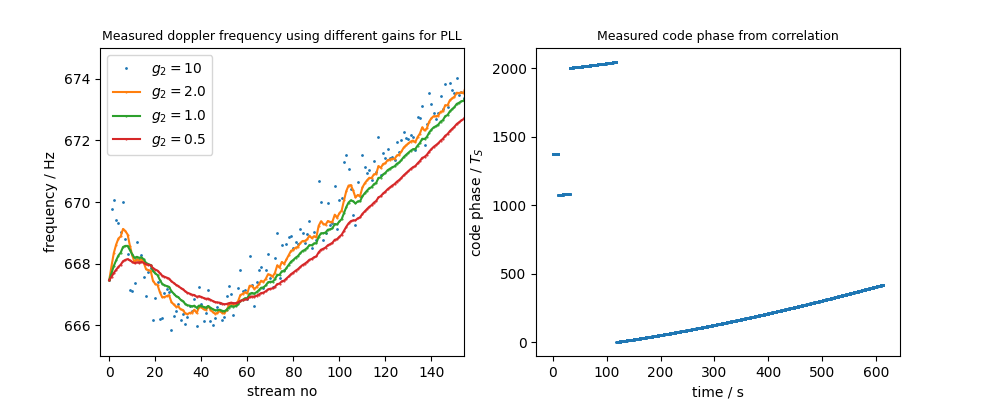

In [8]:
# Example 6: Phase-Locked-Loop (results)

%matplotlib widget

import json
import matplotlib.pyplot as plt  
import numpy as np

with open(f'data/230914_gpsCP_24_gains.json','r') as file:
    cp=np.asarray(json.load(file))
    
with open(f'data/230914_gpsFreq_24_gains.json','r') as file:
    freq=json.load(file)  
    
gain1,gain2,gain3,gain4 = zip(*freq)
    
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(left=0.1)
fig.canvas.header_visible = False      # hide header
   
ax0.plot(gain1[4:],'o',ms=1,label='$g_2 = 10$')
ax0.plot(gain2[4:],'o-',ms=0.5,label='$g_2 = 2.0$')
ax0.plot(gain3[4:],'o-',ms=0.5,label='$g_2 = 1.0$')
ax0.plot(gain4[4:],'o-',ms=0.5,label='$g_2 = 0.5$')
ax0.set_xlim(-4,154)
ax0.set_ylim(665,675)
ax0.set_title('Measured doppler frequency using different gains for PLL',
              fontsize=9)
ax0.set_xlabel('stream no')
ax0.set_ylabel('frequency / Hz')
ax0.legend()    

t = [x*0.032 for x in range(len(cp))]
ax1.plot(t,cp,'o',ms=0.5)
ax1.set_title('Measured code phase from correlation',fontsize=9)
ax1.set_xlabel('time / s')
ax1.set_ylabel('code phase / $T_S$')

plt.show()


**The figure on the left** shows frequency curves for different PLL settings with the same measurement data (satellite PRN24). For all curves, $g_1 = 10\,\rm Hz$. As soon as the mean phase deviation $\overline{\Delta\phi}$ is below a defined threshold (here: *LOCKED_THRES = 0.3*), the Doppler frequency is corrected with gain $g_2$. This transition occurs at the 4th stream ($T_{\rm cyc}=32\,\rm ms$) and is the same for all curves. The curves also have in common that they have a minimum at around the 40th stream and then increase linearly. The linear increase corresponds to about $2.2\,\rm Hz/s$ and is obviously caused by the continuous change in the Doppler frequency. The occurring minimum therefore shows that it takes about $40\cdot 32\,\rm ms$ until the accuracy for the measurement of the Doppler frequency is improved from $4\,\rm Hz$ to about $0.1\,\rm Hz$. The greater the gain, the faster the minimum is reached, but the greater the remaining noise.

The *blue dots* represent the frequency values for $g_2=g_1=10$. The fluctuations are the strongest here because the frequency corrections clearly exceed the target value due to the high gain factor. For smaller gains, the noise decreases considerably, but for the red curve with gain $g_2=0.5$ this also leads to a visible shift to lower mean values. The correction values for the frequency are obviously always smaller here than would be necessary to compensate for the frequency drift of $2\,\rm Hz/s$. As previously noted, the shift could be avoided in an improved version of the PLL by directly taking the drift into account. Such an approach is used in the code for the real-time tracking (see [Code modifications](#Code-modifications)).

**In the figure on the right**, the code phase is shown in units of sample period $T_{\rm S} = 4.88\,\rm \mu s$ (inverse sample rate) and as a function of time in seconds. Two things stand out: Firstly, contrary to expectations, a continuous course is interrupted by *two jumps* in the curve.$^1$ These are errors that only rarely occur, especially shortly after the start of the measurements.$^2$ However, in the case of real-time positioning with the RTL-SDR, they must be reliably detected in order to avoid an otherwise necessary abort. This will be discussed in detail later (see chapter [Live tracking](Live-tracking)).

Secondly, the curve shows that the code phase changes with a rate of $0.43\,\rm \mu s/s$. From that, it can be concluded that the temporal length of the received C/A codes is slightly greater than $1\,\rm ms$ ($0.43\,\rm ns$). This is due to the Doppler effect. The frequency of the transmitted C/A codes of $f_{\rm c} = 1\,\rm kHz$ (period $T_{\rm c}=1\,\rm ms$) is changed at the receiver as a result of the relative velocity $v$ of receiver and satellite. The values of $v$ calculated by the Doppler formula using the measured Doppler frequency $f_{\rm n}$ and the measured code phase agree well ($v\simeq -130\,\rm m/s$). From the maximum speed $v_{\rm max}\simeq 973\,\rm m/s$ it can be concluded that the change in code phase does not exceed $3.2\,\rm \mu s/s$ (or 3 *chips*/s).

---
1. *The transition from $2048\cdot T_{\rm S} = 1\,\rm ms$ to $0\,\rm ms$ is the result of the reduction of the code phase to the interval $[0,2048]$, similar to the phase of a sine wave to $[0,2\pi]$.*
2. *In the author's measurements, these phase errors happened only under the operation system Windows.*

#### Time required for demodulation

With the reconstruction of the binary signal modulated to the carrier frequency of a satellite, called *binary phase shift keying* (BPSK), an important first step is taken to obtain the data contained therein. Compared to the subsequent processes, it is the most time-consuming, as the data stream from the RTL-SDR with $4\,\rm MByte/s$ only contains an information flow of $50\,\rm bit/s$. With regard to the desired real-time measurement, it is therefore interesting to see how fast data processing is possible up to this point.

With an Intel i5-9500 CPU (3.00 GHz) under the Windows operating system, the decoding of a data stream of $32\,\rm ms$ length requires an average time of $6.2\,\rm ms$ (without graphics display). Thus the information of at best 4 to 5 satellites can be evaluated within $32\,\rm ms$ using serial data processing. In view of the already outdated CPU (released in 2019), this is not a bad starting point. However, it is clear that *real parallelization* of data processing using all available *processor cores* is necessary if up to 12 satellites are to be observed simultaneously. 

### Data decoding

When describing data reception, the main aim was to understand how the actual information is encoded in the transmitted data stream using Gold codes and how the frequency shift due to the Doppler effect must be taken into account. The code for obtaining the transmitted data signals is quite obvious after understanding the underlying mathematics.

In this chapter, it's the other way around. The task is clearly outlined: The binary coded data is given as an analog signal and must be converted into a stream of bits. This must then be interpreted according to the signal specification$^1$ in order to be able to calculate the satellite positions, among other things. The algorithms for the necessary program code are often less obvious here. This chapter will therefore mainly focus on describing the Python code for decoding the information.

---
1. [*Global Positioning System Standard Positioning Service Signal Specification, 2nd Edition (June 2, 1995)*](https://www.gps.gov/technical/ps/1995-SPS-signal-specification.pdf)

#### Digitization

**Satellite and receiver time**

The signal of a satellite extracted with the chapter *Data reception* consists of a sequence of analog (and therefore noisy) non-periodic pulses of different lengths. The time interval between adjacent data points is exactly $\Delta t = 1\,\rm ms$ as *satellite time* corresponding to the exact time length of a C/A code during transmission. It has already been made clear that the *receiver time* deviates from this due to the Doppler effect. In the Python code, the two times are represented by two global variables. The variable *MS_TIME* counts the satellite time in the unit $\rm ms$. It is initially zero and is incremented with the number of data points of the satellite signal as soon as the PLL control loop has successfully reached the *Locked* state. The global variable *SMP_TIME* counts the receiver time based on the number of samples of *complex numbers* from the data stream $D_{\rm all}$. The data rate is $2.048\,\rm MS/s$, accordingly the time unit here is approx. $0.4883\,\rm \mu s$.

**Edge signals**

To read the bits from the analog data, the times of the edges in the signal stream are first recorded, i.e. the sharp transitions between positive and negative amplitudes. This is done as an extension of the existing code directly in the *decodeData()* function, in which the analog signal stream $P(t)$ is determined. The collected edge events are saved to the list *edges* as tuples *(MS_TIME,SMP_TIME)*. The sign of the slope of the first event is stored in *edges[0]*, all subsequent signs can be derived from the position in the list as the sign changes with each new entry.

In the notebook **E07_SatData_Frames.ipynb** a digital stream *bitData* is generated from the list *edges* using the function *bitPlotData()* and is then plotted together with the analog signal *gpsData* for comparison.$^1$ In case of a good signal-to-noise ratio of the analog signal, the digital signal reproduces the edges very well. With more noisy signals, however, errors caused by sign changes due to noise are also appearing. These errors are detected during the subsequent evaluation of the subframes in an error check based on parity bits, whereupon the affected subframes are discarded.

---
1. *The bitPlotData() function uses the time of the last measuring point to synchronize gpsData and bitData with the current value of MS_TIME.*

In [ ]:
# Example 7: decoding subframes from data (load and run notebook E07_SatData_Frames.ipynb)

An example result for the given data is shown here in a screenshot.

<img width="450" src="figures/E07_SatData_Frames_1.jpg">



**Bit sequence**

In the GPS signals, a bit is represented as a $20\,\rm ms$ long signal of constant positive or negative amplitude. If, for example, a $60\,\rm ms$ long positive amplitude is found, followed by a $40\,\rm ms$ negative amplitude, then the logical bit sequence $11100$ or $00011$ is encoded.

The translation of the edge signals into a bit sequence can therefore be achieved simply by calculating the temporal distances between the edges using the satellite time. This is done in the Python code within the routine *evalEdges()* using the function *logicalBits()*. An array *bits* is returned with the numbers $\pm 1$ as logical quantities. The receiver time *SMP_TIME* of the edge signals is stored in a second array *bitsSmpTime*. This array is needed later to link the begin of a subframe, its preamble, with its receive time. 

The bit sequence is then examined with regard to the desired subframe data. However, each data stream of length $T_{\rm cyc}=32\,\rm ms$ contains just 1 data bit. To decode a complete subframe of 300 bits, at least $6\,\rm s$ of data length, i.e. 188 data streams, are required. The already decoded bits and their sample times are therefore temporarily stored in the global lists *GPSBITS* and *GPSBITS_ST* until they have grown to the required data size.

**Preamble and Class Subframe()**

Finally, the bits are evaluated using the *evalGPSBits()* function. Here two central tasks with regard to the transferred bits are performed. First, the *preamble* is searched for in the bitstream. The preamble is located at the beginning of each subframe and is defined by a specific bit pattern. It is found by calculating the correlation between the bit data and the preamble pattern. As there can also be random matches, it must be checked for each one whether it really is the start of a subframe. To do this, the data is passed to an *Extract()* routine, starting with the preamble pattern. This checks the data and returns the decoded subframe data in case of no errors.

The *Extract()* function is part of the class *Subframe* that is defined in the *gpslib* module. The structures, variables and data it contains are based on the corresponding information in the [*GPS signal specifications*](https://www.gps.gov/technical/ps/1995-SPS-signal-specification.pdf). Knowledge of this document is therefore essential for understanding the code of this class. However, it is sufficient to mention here that the data bits also contain parity bits for error control, which are checked with the *checkParity()* function of *Subframe*. Therefore, if bits in the stream are faulty due to interference or a poor signal-to-noise ratio, these are usually detected. If the decoding was successful, the data is returned in a *Dictionary*. The reception time *ST* of the subframe is also included in it. 

The notebook **E07_SatData_Frames.ipynb** introduced above displays some characteristic data of successfully read subframes if the global variable *SHOW_FRAMES* is set *True*. The data is then shown in a list next to the graph immediately after reception and decoding of a subframe. If a subframe with *ID=1* is included, the date is calculated and displayed based on the *GPS week* it contains.

<img align="center" width="600" src="figures/E07_SatData_Frames_2.jpg">

All decoded subframes are stored in the global variable *FRAME_LIST* and can be examined during or after closing the notebook. The content of the subframes is discussed in the following chapter.


#### Subframes and ephemeris

**Structure**

A *frame* consists of 1500 bits that take 30 s to transmit (transmission rate $50\,\rm bit/s$). Each frame includes 5 equally long *subframes* of 6 s each. The subframes each contain 10 *words* of 30 bits each. Each *word* has six parity bits for error detection. 

Five subframes with *identifiers* (IDs) 1 to 5 are sent repeatedly. The first two *words* (*telemetry word*, TLM, and *hand over word*, HOW) are common to all subframes and contain the preamble, the *time of week* (TOW) and the *identifier* (ID). TOW can be used to calculate the *exact* transmission time of the *next* subframe (leading edge of the first preamble bit) in seconds since the beginning of the week.$^{1,2}$ It is crucial for the positioning that all satellites send the subframes at nominally the same times. Small deviations, for example due to device-specific signal delays in the transmitter, are taken into account later using correction parameters that are also transmitted. The corrected preamble times serve as *exact time references* for all subsequent measurements. 

In **Subframe 1**, the *week number* is sent in addition to the *time of week*, which can be used to calculate the current date. The other parameters essentially concern correction values for the time. **Subframes 2 and 3**, on the other hand, contain the numerical values required to calculate the satellite positions, i.e. the orbital parameters of their elliptical orbit and correction values for the next few hours. These are collectively referred to as *ephemeris*. With **Subframes 4 and 5** the ephemerides of all satellites (almanac) are sent continuously so that the receiver is able to select the best satellites for fixing its position at any time. In contrast to the first three subframes, their content changes a total of 25 times due to the large size of the almanac, so that it is only fully transmitted after $12.5\,\rm min$. In addition, **Subframe 4** provides parameters for correcting changing propagation delays of the electromagnetic waves in the ionosphere.$^3$ However, these effects are currently not taken into account in this tutorial. Since no use is made of the almanac here either, the data sent with subframes 4 and 5 are largely ignored - only the time references are used.

In addition to the time references, the time corrections and the orbital parameters of the satellites, including corrections, are needed to fix the receiver position. This requires reading subframes 1, 2 and 3 at least once. This means that the receiver position can only be determined after $18\,\rm s$ of measurement time at the earliest if this information is not already available from another source.$^4$ 

**Class SatData()**

To process the subframes, the collected data is passed to an instance of the *SatData()* class (defined in *gpslib*) using the *readFrame()* function. This uses an instance of the class *Subframe()* to check and decode the data (see chapter *Digitization*). The data required later is stored as an instance variable in the dictionairy *ephemData*. The parameters IODC (*Issue of Data, Clock*) and IODE (*Issue of Data, Ephemeris*) are used to check whether the data is still up to date. If an update is signaled, the old data is saved and replaced by the new data.$^5$ The time references are saved as a tuple *(TOW,ST)* in the array *timeData*. If a complete set of required parameters is available, this is communicated by *readFrame()* with the return value of *ephemOk*.

---
1. *The beginning of the week is defined as midnight between Saturday and Sunday.*
2. *The transmitted GPS time is almost identical to the [Coordinated Universal Time (UTC)](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) except for some 'leap seconds' (currently 18 s) . For details, see GPS specifications.*
3. *A brief discussion of this is provided in the chapter [Error sources and corrections](#Error-sources-and-corrections).*
4. *e.g., [CDDIS: NASA's Archive of Space Geodesy Data](https://cddis.nasa.gov/index.html)*
5. *The previous data can still be used, but the accuracy decreases with increasing time.*

#### Satellite orbits and positions

**Algorithms**

As soon as all the necessary ephemeris data is available, the position of the satellite can be calculated as a function of time. The required calculation steps are described in detail in the GPS specifications. To give an impression of the underlying physics, these are briefly referred to and commented on here. The time at which the position is to be determined is passed to the algorithm as the GPS time $t_0$ in integer multiples of $1\,\rm ms$. This time is referred to in the specifications as $t_{\rm sv}$ (SV for *space vehicle*), or in words "effective SV PRN code phase time at message transmission time (seconds)",

$$ t_{\rm sv} = t_0 \ .$$

<img align="right" width="400" height="300" src="figures/SatelliteOrbit.png">

However, the real transmission time actually deviates from this for various reasons. To calculate the correction$^1$ $\Delta t_{\rm sv}$, the parameters $t_{\rm gd}$ (group delay), $t_{\rm oc}$ (offset code phase) and $t_{\rm oe}$ (ephemeris reference time) as well as the coefficients for a time-dependent 2nd degree polynomial are used. In addition, the relativistic correction $\Delta t_{\rm r}$ of the time due to the elliptical orbit of the satellite is taken into account (see discussion in [Error sources and corrections](#Error-sources-and-corrections)). The result is the real time of transmission $t$,$^2$

$$ t = t_{\rm sv} - \Delta t_{\rm sv} \ . $$

The value of $\Delta t_{\rm sv}$ is required again later in order to correct also the reception time. To calculate the satellite position, the time difference to the ephemeris reference time $t_{\rm oe}$ is required, as all orbit parameters refer to this,

$$ t_{\rm k} = t - t_{\rm oe} \ . $$

Since the satellite orbit is an ellipse, the corrected mean anomaly$^3$ $M_{\rm k}$ and the Kepler equation$^4$ are used to calculate the eccentric anomaly$^5$ $E_{\rm k}$ and from this the true anomaly $\nu_{\rm k}$. The angle for the location of the satellite on the elliptical orbit relative to the angle $\omega$ for the closest point to the earth (perihelion) is thus known (see figure),

$$ \Phi_{\rm k} = \nu_{\rm k} -\omega \ . $$

This is later a measure of the latitude of the satellite position in Earth coordinates (argument of latitude). The angle $\omega$ refers to the intersection of the satellite orbit with the ecliptic (plane of the earth's orbit around the sun). 

<img align="right" width="300" height="300" src="figures/ECEF.png">

The inclination $i_0$ of the satellite orbit to the ecliptic is given and the distance $r$ to the center of the earth can be calculated now. The values $\Phi_{\rm k}$, $r$ and $i_0$ are corrected for orbit perturbations and the corresponding values $u_{\rm k}$, $r_{\rm k}$ and $i_{\rm k}$ are obtained. Another parameter is the angle $\Omega$ of the intersection of the satellite orbit and the ecliptic to the vernal point (intersection of the equatorial plane with the ecliptic). This serves as a reference value for the longitude of the satellite position in earth coordinates (longitude of the ascending node). In the corrected value $\Omega_{\rm k }$ a small temporal drift is taken into account. However, more important is that the rotation of the earth is included, so that the coordinates of the satellite $(x_{\rm k},y_{\rm k},z_{\rm k})$ calculated at the end refer to the *resting* earth (ECEF, Earth-Centered, Earth-Fixed coordinates).$^6$ The ECEF coordinate system has its origin in the center of the Earth, the $z$-axis points in the direction of the North Pole. The points of intersection of the $x$ and $y$ axes lie on the equator at longitude $0^\circ\rm N$ (Gulf of Guinea, Africa) and $90^\circ\rm E$ (Indian Ocean near Singapore). With the coordinates of the satellite in its orbital plane

\begin{eqnarray*}
x_{\rm k}^\prime &=& r_{\rm k}\,\cos u_{\rm k} \\
y_{\rm k}^\prime &=& r_{\rm k}\,\sin u_{\rm k} 
\end{eqnarray*}

you get the ECEF coordinates with

\begin{eqnarray*}
x_{\rm k} &=& x^\prime_{\rm k}\,\cos\Omega_{\rm k} - y^\prime_{\rm k}\,\cos i_{\rm k}\,\sin \Omega_{\rm k} \\
y_{\rm k} &=& x^\prime_{\rm k}\,\sin\Omega_{\rm k} + y^\prime_{\rm k}\,\cos i_{\rm k}\,\cos \Omega_{\rm k} \\
z_{\rm k} &=& y^\prime_{\rm k}\,\sin i_{\rm k}
\end{eqnarray*}

---
1. *"SV PRN code phase time offset (seconds)"* 
2. *"t is GPS system time at time of transmission, i.e., GPS time corrected for transit time (range/speed of light)."*
3. *The mean anomaly $M_{\rm k}$ is an angle proportional to $t_{\rm k}$ with $M =2\pi$ for integer multiples of the orbital period $T$.*
4. *Wikipedia, [Kepler's equation](https://en.wikipedia.org/wiki/Kepler%27s_equation)*
5. *Measured from the center of the ellipse, $E_{\rm k}$ is the angle from the nearest point of the orbit to an auxiliary point $H$ on a circle with radius of the major axis $a$, which forms a parallel to the minor axis $b$ with the satellite location $P$ on the ellipse, $\overline{\rm HP}\,\|\, \rm b$.*
6. *Wikipedia, [Earth-centered, Earth-fixed coordinate system](https://en.wikipedia.org/wiki/Earth-centered,_Earth-fixed_coordinate_system)*

**Class SatPos()**

The class *SatPos()* was created to implement the above algorithms. To calculate the position of a satellite at GPS time, given by the value of TOW, the function *ECEFCoord(TOW,eph)* is called, where *eph* represents the dictionairy of the ephemeris generated by *SatData()*. To calculate the positions in smaller time steps than $6\,\rm s$, an add-on time $dt$ in the unit seconds can be specified as keyword argument $DT=dt$. The results of the function are the ECEF coordinates $(x_{\rm k},y_{\rm k},z_{\rm k})$ in meters and the correction time $\Delta t_{\rm sv}$ in seconds. The corrected orbit and time parameters are no longer required, but may be accessed in the dictionaries *dctOrb* and *dctTime* defined as instance variables in *SatPos()*.

**Example: Positions in the local coordinate system**

For illustration purposes, the positions of the satellites in the measurement data are calculated and depicted in a polar plot. It shows the elevation and azimuth angles of the satellites in the sky as seen from the position of the receiver. The subframes with the orbit parameters can be obtained from the measurement data using the notebook **E07_Satdata_Frames.ipynb**. They are loaded here from a JSON file. After the satellite positions have been calculated in ECEF coordinates, they are converted into a local horizontal coordinate system with elevation and azimuth angles using the known receiver coordinates as a reference position. This transformation is carried out by the function *ECEFtoAzimElev()* in the *gpslib* module using basic vector operations.

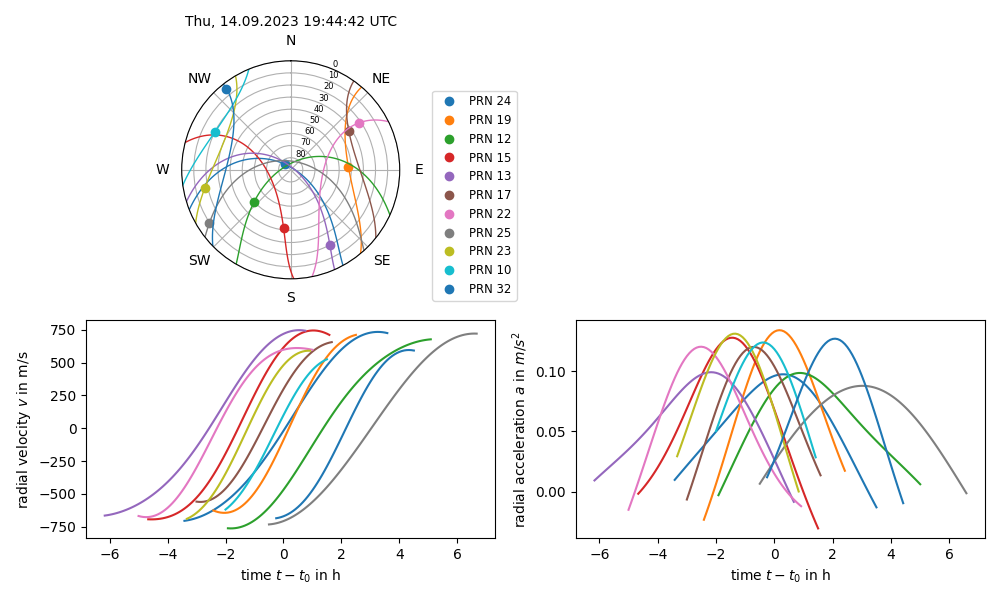

In [15]:
# Example 8: calculating satellite positions in local coordinates

%matplotlib widget

import json
import matplotlib.pyplot as plt  
import pycode.gpslib_tutorial as gpslib
import numpy as np

SAT_LST = (24,19,12,15,13,17,22,25,23,10,32)
REC_POS = (4141657.6,604772.9,4796731.9)   
# lat,lon,height = (49.08293620495832, 8.30772631763587, 168.21197780780494)

timeStr = None
startPos,allGeo,allECEF = {},{},{}

with open('data/230914_gpsFrames.json','r') as file: 
    FRAME_LST=json.load(file)  
    
for satNo in SAT_LST:
    satData = gpslib.SatData(satNo)
    satPos = gpslib.SatPos()
    sfLst = list(filter(lambda item:item['SAT']==satNo and 'ID' in item,
                        FRAME_LST))
    for sf in sfLst:
        satData.readSubframe(sf)
        if satData.ephemOk:
            break
    eph = satData.ephemData
    if timeStr is None:
        tow = satData.timeData[0][0]
        weekNum = eph['weekNum']
        timeStr = gpslib.gpsTimeStr(tow,weekNum) 
    x,y,z,_ = satPos.ecefCoord(tow,eph)
    theta,phi = gpslib.ecefToAzimElev(REC_POS,(x,y,z))  # (elevation,azimuth)
    startPos[satNo] = (theta,phi)
    
    step = 50
    t = tow-step
    geo,ecef = [],[]
    while theta > 0:
        t += step
        x,y,z,_ = satPos.ecefCoord(t,eph)
        ecef.append((t,x,y,z))
        theta,phi = gpslib.ecefToAzimElev(REC_POS,(x,y,z)) 
        geo.append((t,theta,phi))
    t = tow
    theta = 90
    while theta > 0:
        t -= step
        x,y,z,_ = satPos.ecefCoord(t,eph)
        ecef.append((t,x,y,z))
        theta,phi = gpslib.ecefToAzimElev(REC_POS,(x,y,z)) 
        geo.append((t,theta,phi))
    geo.sort()
    allGeo[satNo] = geo
    ecef.sort()
    allECEF[satNo] = ecef                

fig = plt.figure(figsize=(10,6))
fig.canvas.header_visible = False      
spec = fig.add_gridspec(2,2)
ax = fig.add_subplot(spec[0,0],projection='polar')
ax.set_title(timeStr,fontsize=10)
col = 0
for satNo in startPos:
    theta,phi = startPos[satNo]
    ax.plot(phi/180*np.pi,90-theta,'oC%d' % (col),ms=6,
            label='PRN %00d'%(satNo))    
    t,theta,phi = zip(*allGeo[satNo])
    theta = np.asarray(theta)
    phi = np.asarray(phi)
    plt.plot(phi/180*np.pi,90-theta,'-C%d' % (col),lw=1)  
    col = (col + 1) % 10   
ax.set_xticks(np.arange(0,2*np.pi,np.pi/4),
              ['N','NE','E','SE','S','SW','W','NW'])
ax.set_theta_zero_location("N")
ax.set_theta_direction('clockwise')
ax.set_ylim(0,90)
ax.set_yticks(range(0, 100, 10))                    
ax.set_yticklabels(['']+list(map(str, range(80, -10, -10))),fontsize=6) 
ax.legend(loc=(1.15,-0.1),fontsize='small')

bx = fig.add_subplot(spec[1,0])
cx = fig.add_subplot(spec[1,1])

vmin,vmax,amin,amax,col = 0,0,0,0,0
for satNo in allECEF:
    t,x,y,z = zip(*allECEF[satNo])
    t,x,y,z = np.asarray(t),np.asarray(x),np.asarray(y),np.asarray(z)
    r = np.sqrt((x-REC_POS[0])**2+(y-REC_POS[1])**2+(z-REC_POS[2])**2)
    
    v = np.diff(r)/(6*step)
    vmin,vmax = min(vmin,np.min(v)),max(vmax,np.max(v))
    bx.plot((t[:-1]-tow)/600,v,'-C%d' % (col),label='PRN %00d'%(satNo))

    a = np.diff(v)/(6*step)
    amin,amax = min(amin,np.min(a)),max(amax,np.max(a))
    cx.plot((t[:-2]-tow)/600,a,'-C%d' % (col),label='PRN %00d'%(satNo))

    col = (col + 1) % 10   
    
bx.set_xlabel('time $t-t_0$ in h')
bx.set_ylabel('radial velocity $v$ in m/s')
cx.set_xlabel('time $t-t_0$ in h')
cx.set_ylabel('radial acceleration $a$ in $m/s^2$')

plt.tight_layout()                                 
plt.show()
    

In the **upper plot**, the filled circles in the polar diagram show the **positions of the satellites** for the specified time $t_0 = 19\!:\!44\!:\!42\,\rm UTC$ corresponding to the time of week $\rm tow = 69451$. The lines indicate the course of the positions for the entire time of their respective visibility on the sky of about 4 to 7 hours. 

The direction of movement can be inferred from the **plot at the bottom left**. It shows the **relative velocities** of the satellites to the receiver as a function of the time difference to $t_0$ in hours. Negative velocities mean that the distance to the receiver is decreasing. The minimum velocity shown in the plot is $v_{\rm min} = -762.5\,\rm m/s$ and the maximum velocity is $v_{\rm max} = +746.6\,\rm m/s$. As previously discussed, the radial velocity determines the change in received frequencies (carrier frequency) and time signals (code phases) due to the Doppler effect.

The **plot at the bottom right** shows the **accelerations** (changes in velocity) as a function of time. Their minimum and maximum values are $a_{\rm min} = -0.031\,\rm m/s^2$ and $a_{\rm max} = 0.134\,\rm m/s^2$. These are relevant when the code phases are evaluated. For a constant velocity $v$, the change in the code phase as a function of time is a straight line whose slope is determined by $v$. If an acceleration $a$ is added, it causes a change of $v$ and thus a curvature of the line.

For a better understanding, the effects on the code phase are calculated here using the maximum values as an example. With $v_{\rm max} = 950\,\rm m/s$ the radial distance $\Delta l$ to the satellite increases per second by $\Delta l = 950\,\rm m$. The propagation time of the signal $\Delta t$ thus increases by $\Delta t=\Delta l/c = 3.2\,\rm \mu s$ per second, which corresponds to $6.5\cdot T_{\rm s}$ per second in units of the sample period. The code phase as a numerical value in the range of 0 to 2047 therefore changes also at a maximum of $\pm 6.5/{\rm sec}$. With a maximum acceleration of $a_{\rm max}=0.134\,\rm m/s^2$, the additional distance traveled in time $t$ is given by $\Delta s = a_{\rm max} t^2/2$. After 20000 streams of $32\,\rm ms$ length, i.e. after a period of $t = 640\,\rm s$, the additional distance is $\Delta s = 27443.2\,\rm m$ and the change in the code phase is $\Delta t = 91.5\,\rm \mu s \simeq 187\,T_{\rm s}$. Both changes, with regard to $v$ and $a$, must be taken into account if the value for the code phase is to be predicted over a longer period of time. Later these numbers are used to determine whether a change of the code phase is caused by the movement of the satellite or is the result of an error induced by a delayed data processing (see [Real-time positioning](#Real-time-positioning)).

### Positioning

We now come to the actual core of GPS navigation: the fixing of the receiver's position using satellite signals. The foundations for this were largely laid in the previous chapters. After data reception, decoding and digitization, the ephemerides for the satellite positions, the reference times of the subframes and the measured reception times (code phases of C/A codes) are available for at least four satellites.

However, before the complex procedure with several satellites is presented, the method of calculation using just two satellites should first be examined and the possible accuracy investigated. In particular, the measurement of the satellite distance using the transit time of the satellite signal plays a central role, the so-called *pseudorange* or *pseudo-distance*.

#### Pseudoranges of two satellites

In the previous chapter, the ephemerides of 11 satellites were determined from measurement data, so that their exact positions are available as a function of time. Since the geodetic coordinates of the receiver position can be precisely localized using [Google Maps](https://www.google.com/maps/search/?api=1&query=8.307550288130418°E,49.082946478873566°N), for example, the distances $l_i$ between the receiver and the satellites can be calculated and compared with the *pseudoranges* $c\,(t_i -t_0)$ obtained via the transit times of the satellite signals,

$$ l_i = c\,(t_i-t_0) \ , $$

with transmission time $t_0$ and reception time $t_i$. However, as dicussed in chapter [Basics:Pseudorange](#Pseudorange), Such a comparison is not possible with just one satellite, as the transmission time $t_0$ at the receiver is not known with sufficient accuracy due to the lack of synchronization. Instead, if the time of signal transmission $t_0$ of two satellites is identical, the difference between the reception times of these signals is taken, $\Delta t_{12} = t_1 - t_2$. Then $t_0$ drops out and it follows  

$$ \Delta l_{12} = c\,\Delta t_{12} \ . $$

The difference in the distances between two satellites and the receiver is calculated from the difference in the arrival times of their simultaneously transmitted signals. The reception times $t_i$ of the *preambles* (beginning of the subframes) are known with the sample times *ST*. Here subframes for the same *time of week* TOW are used for comparison, as they were transmitted at the same time. For the following script, we select the satellites PRN24 and PRN25, as their distances to the receiver are largely different. The following steps are performed for both satellites:

- Read subframes into a *SatData()* instance and create the ephemeris table
- Create a TOW list of the available subframes
- Create a list of common TOW values 
- Calculate the satellite locations *and* time corrections $\Delta t_{\rm sv}$ using a *SatPos()* instance for all common TOW 
- Calculate the distances $l_i$ of the satellites to the receiver for all common TOW
- Calculate the receive times $t_i$ from the sample times ST of the subframes and the $\Delta t_{\rm sv}$ for all common TOW

In the last step, the deviations (or residues) $\Delta l_{12} - c\,\Delta t_{12}$ are evaluated and displayed in a histogram.

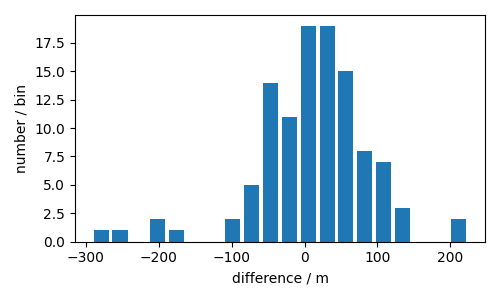

In [1]:
# Example 9: pseudo-range (1) (measured every 6 s)

%matplotlib widget 

import json
import pycode.gpslib_tutorial as gpslib
import numpy as np
import matplotlib.pyplot as plt
    
GPS_C  = 2.99792458e8
SMP_RATE = 2.048E6    
REC_POS = (4141657.6,604772.9,4796731.9)  #ECEF coordinates

# possible satellites 10,12,13,15,17,22,23,24,25
SAT0 = 24
SAT1 = 25
TOW_0 = 69447                # behind last code phase error

with open('data/230914_gpsFrames.json','r') as file:
    FRAME_LST=json.load(file)  

satData,satPos,sfLst,towSet = {},{},{},{}

for satNo in [SAT0,SAT1]:
    satData[satNo] = gpslib.SatData(satNo)
    satPos[satNo] = gpslib.SatPos()
    sfLst[satNo] = list(filter(lambda item:item['SAT']==satNo and 'ID' \
                               in item and item['tow']>=TOW_0,FRAME_LST))
    for sf in sfLst[satNo]:
        satData[satNo].readSubframe(sf)        
    towSet[satNo] = set(sf['tow'] for sf in sfLst[satNo])
        
comTowSet = towSet[SAT0] & towSet[SAT1]

dist = {}
smpTime = {}
dstLst = []
for satNo in [SAT0,SAT1]:
    dist[satNo] = []
    smpTime[satNo] = []
    for sf in sfLst[satNo]:
        tow = sf['tow']
        if tow in comTowSet:
            x,y,z,d_st = satPos[satNo].ecefCoord(tow,satData[satNo].ephemData,
                                                 relCorr=False)
            dstLst.append(d_st)
            d = np.sqrt((x-REC_POS[0])**2+(y-REC_POS[1])**2+(z-REC_POS[2])**2)
            dist[satNo].append(d)
            smpTime[satNo].append(sf['ST']/SMP_RATE+d_st)
    dist[satNo] = np.asarray(dist[satNo])            
    smpTime[satNo] = np.asarray(smpTime[satNo])            
            
result = dist[SAT0]-dist[SAT1] - GPS_C*(smpTime[SAT0]-smpTime[SAT1])

mean = np.mean(result)
std  = np.std(result)

fig = plt.figure(figsize=(5,3))
fig.canvas.header_visible = False
plt.hist(result,bins=20,rwidth=0.8)
plt.ylabel('number / bin')
plt.xlabel('difference / m')
plt.tight_layout()
plt.show()
    

The histogram contains a total of $110$ values. Except for small deviations, it is similar to a distribution as expected for random fluctuations (noise) - a so-called *Gaussian normal distribution*.  The mean value of the distribution of $11.0\,\rm m$ shows that the actual distance and the measured pseudo-distance agree well. However, the mean scatter of the values with standard deviation $\sigma = 77.9\,\rm m$ is larger than desired. The reason for this is the high uncertainty of the reception time ST, which is measured as an integer $n$ in time units of the inverse sample rate, ${\rm ST}=n\cdot T_{\rm S}$ with $T_{\rm S} \simeq 0.49\,\rm \mu s$. With the accuracy $\Delta t = \pm T_{\rm S}/2$ of *one* measurement, we obtain an uncertainty for the pseudo-distance of

$$ \Delta l = c\cdot \Delta t = \pm 73.2\,\rm m \ , $$

which is close to the measured standard deviation. We will show in the following how this measurement uncertainty can be reduced.

#### Code phase interpolation

First of all, it should be remembered how the sample time ST is measured. The code phase is central to this, as it contains the temporal shift of the C/A codes in fractions of a microsecond. For a data stream $H_{\rm n}$, the correlation function $C_n(\tau)$ is calculated using the C/A code $G_{\rm n}$ of the satellite,

$$ C_n(\tau) = G_{\rm n}\star H_{\rm n} = \int G_{\rm n}^\ast(t) H_{\rm n}(t+\tau)\,{\rm d}t \ . $$

The desired code phase is given by the value $\tau=\tau_{\rm n}$ at which the correlation has its maximum, $C_{n,\rm max} = C_n(\tau_n)$. As $H_{\rm n}$ is built from repeating C/A codes, it is sufficient if $H_{\rm n}$ has the same length as $G_{\rm n}$. For measurements with the RTL-SDR, this length is given by 2048 samples (CODE_SAMPLES=2048). To improve the signal-to-noise ratio, several correlations of consecutive C/A codes are calculated and then averaged. Averaging over 8 correlations has proven to be a good compromise between the noise suppression achieved and the computational effort (CORR_AVG = 8). It should be noted, however, that the code phase slightly changes within the corresponding period of $8\,\rm ms$ (at maximum $25\,\rm ns$). 

Due to the digitization in discrete time steps, the measured value for the code phase is necessarily an integer multiple of the sample period $T_{\rm S} \simeq 0.49\,\rm \mu s$. The real delay, however, is a value that changes continuously with time, so that the real correlation maximum is located somewhere between two adjacent sample points. Its value can be approximately calculated through interpolation if the shape of the correlation function near the maximum is known. In the idealized case of two $n$ times oversampled C/A codes the correlation produces a triangular function of width $n$ (FWHM, Full Width at Half Maximum). In our case, this would suggest performing the interpolation with a triangular function of width $n=2$. However, due to the low-pass filtering applied to the signal before (down-)sampling the data,$^1$ the sharp edges of the C/A codes are more or less softened and the correlation maximum is rounded off to some extent. So instead of using a triangular shape for interpolation, a parabola might be a better choice. In the following both cases are considered.

For interpolation, only the measured maximum value and its two neighboring values are taken into account, since only these are significantly above the noise level. The three values ​​uniquely define both a second degree polynomial and a symmetric triangular function, and after a fit both functions pass exactly through the given points. The following script shows the principle: Three random numerical values are generated with maximum in the middle and a parabola and a symmetric triangular function are fitted to them. The dashed lines indicate the interpolated maxima of the fits. 

---
1. *This is done within by the RTL-SDR chip before sending the data to the computer.*

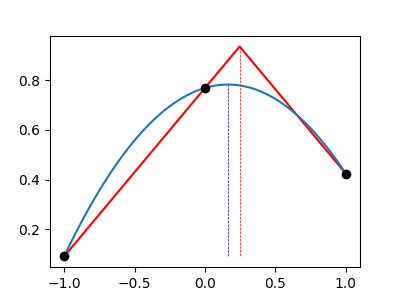

In [18]:
# Example 10: code phase interpolation

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1,+1,3)    # create 3 values for x axis
y = np.random.random(3)     # create random points for y
i = y.argmax()              # put maximum value to center 
if i != 1:                       
    y[i],y[1] = y[1],y[i]

# fit to parabola
p = np.polyfit(x,y,2)       # polynom fit of 2nd order; result is tuple of 
                            # coefficients
f = np.poly1d(p)            # define 2nd order function with found coefficients
mx = -0.5*p[1]/p[0]         # solution for extremum (first derivative = 0)
# or 'manually':
# mx = 0.5*(y[2]-y[0])/(2*y[1]-y[2]-y[0])   # mx is in [-0.5,+0.5]

# fit to symmetrical triangle 
if y[0] > y[2]:
    ymin = y[2]
    xx = 0.5*(y[2]-y[0])/(y[1]-y[2])
    yy = -(y[1]-y[2])*xx + y[1]
else:
    ymin = y[0]
    xx = 0.5*(y[2]-y[0])/(y[1]-y[0])
    yy = (y[1]-y[0])*xx + y[1]

fig = plt.figure(figsize=(4,3))
fig.canvas.header_visible = False
plt.plot([-1,xx,1],[y[0],yy,y[2]],'-r')
plt.plot([xx,xx],[yy,ymin],'--r',lw=.5)
xf = np.linspace(-1,+1,100)      
plt.plot(xf,f(xf))
plt.plot([mx,mx],[ymin,f(mx)],'--b',lw=.5)
plt.plot(x,y,'ko')
plt.show()

With this simple and fast method, a reliable interpolation for the approximate calculation of the correlation maximum is achieved. For both interpolation functions the correction value $p$ for the correlation maximum is within $[-0.5,+0.5]$, but for the same points they can differ up to $\Delta p_{\rm max} \simeq 0.086$ which corresponds to a range of $12.6\,\rm m$. Which of these approaches is preferable will be discussed later. Methods based on more than three points were also tested but did not result in any further improvement.

Both interpolation procedures are implemented in the notebook **E11_SatData_CP** as an expansion of the previous code. The method can be chosen by *FIT_CORR* . For each cycle the interpolated code phase is entered into the global list *COPH_LIST* together with the stream number *streamNo* and saved as a JSON file at the end. In **E12_InterpolatedCP**, a code phase list of the PRN24 satellite based on a parabola fit is loaded and plotted as a function of time.

In [ ]:
# Example 11: implementation of code-phase interpolation (load and run E11_SatData_CP.ipynb)

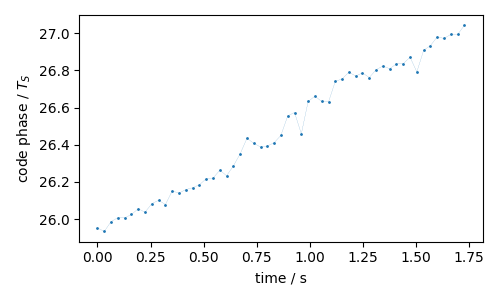

In [19]:
# Example 12: interpolated code-phases from measured data

%matplotlib widget

import json
import matplotlib.pyplot as plt  
import numpy as np

with open('data/230914_gpsCP_24_P.json','r') as file:
    COPH_LIST=json.load(file)  
    
stream,cp = zip(*COPH_LIST)
stream,cp = np.asarray(stream),np.asarray(cp)

t0 = 5015
t1 = 5070

fig = plt.figure(figsize=(5,3))
fig.canvas.header_visible = False
plt.plot((stream[t0:t1]-stream[t0])*32/1000,cp[t0:t1],'o-',ms=1,lw=0.1) 
plt.xlabel('time / s')
plt.ylabel('code phase / $T_S$')
plt.tight_layout()
plt.show()

The value range of the interpolated code phase in the plot extends over a range in which previously only the integer values $26$ and $27$ occurred. With the many intermediate values, a much finer transition and thus a considerably improved temporal resolution is obtained. To determine the effects on the pseudo-distance $c\Delta t$, the script for creating the histogram is extended. The lists of the interpolated code phases of the satellites PRN24 and PRN25 are loaded from JSON files and the integer code phases in the sample times ST are replaced by their interpolated values by using their common stream number. However, instead of using only the code phase list for PRN24 and PRN25, a code phase list (dictionary) of all satellites is used below so that any combination of two satellites can be selected. Here we have again chosen PRN24 and PRN25 for comparison.


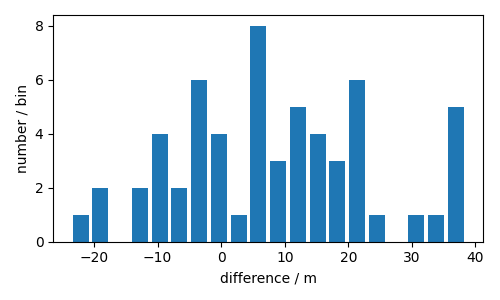

In [2]:
# Example 13: pseudo-range (2) (every 6s, using interpolation)

%matplotlib widget 

import json
import pycode.gpslib_tutorial as gpslib
import numpy as np
import matplotlib.pyplot as plt
import math

GPS_C  = 2.99792458e8
SMP_RATE = 2.048E6    
CODE_SAMPLES = 2048
N_CYC = 32
NGPS = N_CYC*CODE_SAMPLES
REC_POS = (4141657.6,604772.9,4796731.9)

# possible satellites 10,12,13,15,17,22,23,24,25
SAT0 = 24
SAT1 = 25
TOW_0 = 69447                # behind last code phase error

def loadCpLst(satNo):
    with open('data/230914_gpsCP.json','r') as file:
        data=json.load(file)     
    return data[str(satNo)]

with open('data/230914_gpsFrames.json','r') as file:
    FRAME_LST=json.load(file)  
    
satData,satPos,sfLst,towSet,cpLst,stLst,dist,smpTime = {},{},{},{},{},{},{},{}

for satNo in [SAT0,SAT1]:
    cpLst[satNo] = loadCpLst(satNo)
    satData[satNo] = gpslib.SatData(satNo)
    satPos[satNo] = gpslib.SatPos()
    sfLst[satNo] = list(filter(lambda item:item['SAT']==satNo and \
                               'ID' in item and item['tow']>=TOW_0,FRAME_LST))
    towSet[satNo] = set()
    stLst[satNo] = []
    ll = len(cpLst[satNo])-1
    k = 0
    for sf in sfLst[satNo]:
        satData[satNo].readSubframe(sf)         
        tow = sf['tow']
        st = sf['ST']                   # sample time of stream with preamble
        sno = st // NGPS                # stream number 
        while cpLst[satNo][k][0] < sno and k < ll:
            k += 1
        if cpLst[satNo][k][0] < sno:
            break
        elif cpLst[satNo][k][0] == sno:
            # get rid of integer code phase and use interpolated value
            st0 = (st // CODE_SAMPLES) * CODE_SAMPLES   
            stLst[satNo].append((tow,st0+cpLst[satNo][k][1]))   
            towSet[satNo].add(tow)        # set of valid values 
        
comTowSet = towSet[SAT0] & towSet[SAT1]   # common tows of both sats

for satNo in [SAT0,SAT1]:
    dist[satNo] = []
    smpTime[satNo] = []
    for tow,cpST in stLst[satNo]:
        if tow in comTowSet:
            x,y,z,d_st = satPos[satNo].ecefCoord(tow,satData[satNo].ephemData,
                                                 relCorr=False)
            d = np.sqrt((x-REC_POS[0])**2+(y-REC_POS[1])**2+(z-REC_POS[2])**2)
            dist[satNo].append(d)
            smpTime[satNo].append(cpST/SMP_RATE+d_st)
    dist[satNo] = np.asarray(dist[satNo])            
    smpTime[satNo] = np.asarray(smpTime[satNo])            
            
result = dist[SAT0]-dist[SAT1] - GPS_C*(smpTime[SAT0]-smpTime[SAT1])

mean = np.mean(result)
std  = np.std(result)

fig = plt.figure(figsize=(5,3))
fig.canvas.header_visible = False
plt.hist(result,bins=20,rwidth=0.8)
plt.ylabel('number / bin')
plt.xlabel('difference / m')
plt.tight_layout()
plt.show()
    

The histogram above shows the result of the interpolation. In comparison to the previous histogram the mean value has only slightly changed to $8.4\,\rm m$. The limits of the plot, however, are considerably smaller. With a standard deviation of $\sigma = 15.1\,\rm m$ the uncertainty has been reduced by more than a factor of $5$. You can also try out other combinations of satellites by changing the values of *SAT0* and *SAT1* in the notebook.

From the previous examples, you could get the impression that you can only obtain one measured code phase value per subframe (every $6\,\rm s$). But this is wrong. If a valid time reference is obtained with the successful reading of a subframe, then in principle the code phase of each subsequent C/A code can serve as a new reception time measurement, as its transmission time can be determined in units of ms by counting the C/A codes after the time reference. The limit is therefore one measured value per millisecond. However, the computing effort is probably too high for real-time measurements using Python. In contrast, fixing the position once per cycle time $T_{\rm cyc}=32\,\rm ms$ is much easier to implement, as the code phase has to be determined for each cycle anyway to continuously track phase and frequency. 

The main aim of a large number of measured code phase values is to reduce the *uncertainty of the calculated mean position* as much as possible. If we assume a Gaussian distribution of $N$ measured values $x_i, i\in 1\ldots N,$ with mean value $\bar x$, then the uncertainty of the mean value $\Delta \bar x$ is given by

$$ \Delta \bar x = \pm \frac{\sigma}{\sqrt N} $$

with the standard deviation $\sigma$ of the Gaussian distribution. If, as above, $\sigma \simeq 15\,\rm m$, then the error of the mean value for a measurement duration of $1\rm s$ with $N=32$ for $T_{\rm cyc} = 32\,\rm ms$ is only $\Delta\bar x \simeq \pm 2.5\,\rm m$. This is more than sufficient accuracy even for navigating a moving receiver in road traffic.

#### Evaluation of the code phases

This chapter demonstrates, among other things, how a large number of code phases can be efficiently evaluated to calculate the pseudo-distances. Before that, however, two important aspects of their measurement have to be discussed in more detail. These concern a) the handling of different values of the code phases in a data stream, and b) their limited range of possible values.

- Up to this point, the same code phases $\tau_n$, which were evaluated for demodulation and decoding,$^1$ were also used to calculate the pseudo distances. For each data stream read in, consisting of 32 C/A codes, the code phase was determined by calculating and averaging the correlation of 8 data blocks with a specific Gold code. For the calculation of the pseudo-distances it was assumed without explicit mention that the code phase $\tau_n$ is representative for *all* C/A codes of the stream. In fact, it is true that the code phases of neighboring codes only differ by an amount that is below the estimated measurement accuracy. This difference can be easily determined: The temporal change of the code phase is a direct consequence of the Doppler shift and amounts to a maximum of $3.2\,\rm \mu s/s$, so that the maximum difference of neighboring C/A codes is calculated as $\Delta\tau_{\rm max} = 3.2\,\rm ns$. Expressed as a change in distance to a satellite, this corresponds to $0.95\,\rm m$.$^2$ However, this difference grows linearly with the mutual distance of two C/A codes within the stream and then has a much greater influence on the accuracy. 

  <img src="figures/codePhaseMeas.png" width = '800'/>
  
  To illustrate this let us suppose that the first pseudorange calculation is done at the reference time defined by the preamble. The position *p* of the corresponding C/A code in relation to the measured code phase is completely random and different for each satellite. For a position at the end of the stream ($p=16$), an error in the pseudo-distance of $p\cdot 0.95\,{\rm m} = 15.2\,{\rm m}$ is possible. As the subsequent calculations of the pseudoranges are performed at a period of 32 ms (once per stream), the position *p* in the following streams remains constant over a long time.$^3$ As a result, the difference of the real code phase value at position *p* and the measured value in the center of the stream can lead to a significant systematic error of $15\,\rm m$. To approximately correct this error, the almost constant rate of change $\Delta \tau_n$ is measured and averaged over many streams, and the code phase $\tau_{n,p}$ at position *p* is then estimated by

  $$ \tau_{n,p} = \tau_n + p\cdot \Delta \tau_n \ . $$

- The interpolated code phase $\tau_n$ can only have values in the interval $[-0.5,2047.5]$ if measured in units of $T_{\rm S}$. If the maximum value is exceeded, it appears to jump to the minimum (and vice versa). However, for the time signal received every ms this jump means that it moves on to the following C/A code (or the previous one). These overflows (underflows) must be included when counting the number of C/A codes as measure for the time distance in ms from the given time reference. If, as here, a list of measured code phases is available, it is much easier to compensate for the jump by adding or subtracting $2048$ for all subsequent code phase values. In other words: the code phase curve as a function of time is made continuous. The skipped millisecond is then added or subtracted from the signal time by applying the corrected code phase.  

In the following, the script for calculating the pseudo-distance is extended to demonstrate the new evaluation of the code phases. In contrast to the previous method, the time reference (TOW, ST) for each satellite is set only once with identical TOW values for both satellites (just for simplification). As before, the subframes and the code phases are loaded from JSON files. The following steps are then carried out for both satellites:

- The code phases are corrected with regard to their restricted value range (overflow)
- The *SatData()* instance reads the subframes to create the ephemeris table
- The time reference (TOW,ST) is specified.
- The integer code phase is removed from ST for replacement with the interpolated code phases CP.
- The stream number ST_SNO is calculated from the ST value
- The following operations are performed for all tuples (CP,SNO) of code phases CP and stream number SNO:
    - The code phase CP is corrected regarding its position within the data stream
    - The time difference (satellite time) to the reference in integer multiples of a ms is ${\rm DT = (SNO - ST\_SNO)}\cdot T_{\rm cyc}$
    - Satellite position and time correction $\Delta t_{\rm sv}$ are calculated with the *SatPos()* instance for the GPS time (TOW,DT)
    - Satellite distance $l_i$ to the receiver position is calculated
    - Reception time in seconds is calculated with $t_i = {\rm (ST + CP)/SMP\_RATE + DT} + \Delta t_{\rm sv}$ 
    - Result is saved in a list as a tuple (DT, $l_i$, $t_i$)

Finally the residues $\Delta l_{12} - c\Delta t_{12}$ for equal DT values of the satellites are calculated and displayed in a histogram.

---
1. *see [Determination of the Doppler frequency](#Determination-of-the-Doppler-frequency)*
2. *The same result is immediately obtained by multiplying the maximum satellite speed $950\,\rm m/s$ by $1\,{\rm ms}$.*
3. *Only in case of a code phase overflow will p change bei 1. This happens at maximum once in 312.5 seconds.*

PRN24  Rel  0.0  Rot  0.0  Sum  0.0
PRN25  Rel  0.0  Rot  0.0  Sum  0.0

PRN24-PRN25:  mean: 4.814   without corr: 4.814   std: 13.062


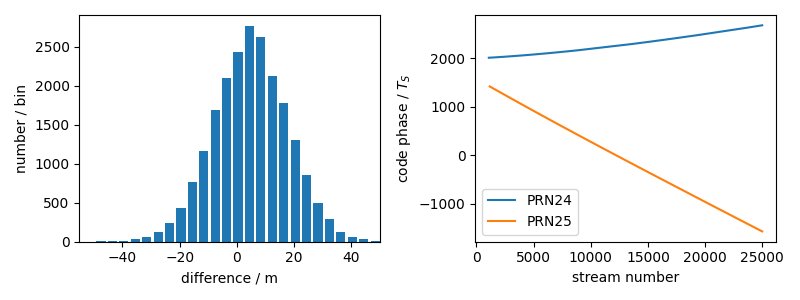

In [1]:
# Example 14: pseudo-range (3) (measured every 32 ms)

%matplotlib widget 

import json
import pycode.gpslib_tutorial as gpslib
import numpy as np
import matplotlib.pyplot as plt

GPS_C  = 2.99792458e8
SMP_RATE = 2.048E6    
N_CYC = 32
CODE_SAMPLES = 2048
NGPS = CODE_SAMPLES*N_CYC
REC_POS = (4141657.6,604772.9,4796731.9)

# possible satellites 10,12,13,15,17,22,23,24,25
SAT0 = 24 
SAT1 = 25 

REL_CORR = False
EARTH_ROT_CORR = False


TOW_0 = 69447                                 # behind last code phase error
snoStart = 1000    


def rotEarth(pos,pt):                
    # pos = (x,y,z); pt is propagation time
    omegaEarth = 7.292115147e-5                # rad/sec
    dp = np.array([-pos[1],pos[0],0])*omegaEarth * pt
    return dp

def getStdDev(tcpLst,cophLst):
    p = np.polyfit(tcpLst,cophLst,14)
    fit = np.poly1d(p)
    cophStd = np.std(cophLst-fit(tcpLst))  
    cophStd *= GPS_C/SMP_RATE                  # standard deviation in m
    return cophStd

def cpOflCorrection(cplst):
    cpl = cplst.copy()
    ovfl = 0    
    pno,pcp = cpl[0]
    for i in range(1,len(cpl)):        
        no,cp = cpl[i]
        cp += ovfl*CODE_SAMPLES
        d = pcp - cp
        if np.isclose(abs(d),CODE_SAMPLES,rtol=1E-5,atol=200):
            cp += np.sign(d)*CODE_SAMPLES                     
            ovfl += np.sign(d) 
        cpl[i] = (no,cp)
        pno,pcp = no,cp                                       
    return cpl
    

def cpPosCorrection(sno,cp,p):
    global P_SNO
    global P_CP
    global CPD    
    MAX_CPD = 1000
    if sno == 'init':
        P_SNO = None
        P_CP = None
        CPD = []
        return         
    if P_SNO is None:
        cpCorr = 0
    else:
        d_cp = (cp-P_CP)/(sno-P_SNO)/N_CYC
        if len(CPD) >= MAX_CPD:
            del CPD[0]
        CPD.append(d_cp)
        mD = np.mean(CPD)
        cpCorr = (p-N_CYC//2)*mD
    P_SNO = sno
    P_CP = cp
    return cpCorr
    
    
def loadCpLst(satNo):
    with open('data/230914_gpsCP.json','r') as file:
        data = json.load(file)     
    return data[str(satNo)]

with open('data/230914_gpsFrames.json','r') as file:
    FRAME_LST=json.load(file)  

cpLst,satData,satPos,sfLst,ST,ST_SNO,res,sumCorr = {},{},{},{},{},{},{},{}

for satNo in [SAT0,SAT1]:
    cpLst[satNo] = loadCpLst(satNo)
    cpLst[satNo] = cpOflCorrection(cpLst[satNo][snoStart:])    
    satData[satNo] = gpslib.SatData(satNo)
    satPos[satNo] = gpslib.SatPos()    
    sfLst[satNo] = list(filter(lambda item:item['SAT']==satNo and \
                               'ID' in item and item['tow']>=TOW_0,FRAME_LST))    
    res[satNo] = []   
    timeRefOk = False
    for sf in sfLst[satNo]:
        satData[satNo].readSubframe(sf)        
        if sf['tow'] == TOW_0:            
            ST[satNo] = (sf['ST'] // CODE_SAMPLES) * CODE_SAMPLES 
            ST_SNO[satNo] = ST[satNo] // NGPS
            timeRefOk = True
        if timeRefOk and satData[satNo].ephemOk:
            break        

    cpPosCorrection('init',0,0)
    relCorrLst = []
    rotCorrLst = []
    for sno,cp in cpLst[satNo]:
        n = sno - ST_SNO[satNo]
        if n >= 0:
            p = (ST[satNo] + cp) // CODE_SAMPLES - ST_SNO[satNo]*N_CYC
            cpCorr = cpPosCorrection(sno,cp,p)   
            cp += cpCorr
            
            dt = n*NGPS/SMP_RATE        
            x,y,z,d_st = satPos[satNo].ecefCoord(TOW_0,
                                                 satData[satNo].ephemData,
                                                 DT=dt,relCorr=REL_CORR)
            dist = np.sqrt((x-REC_POS[0])**2+(y-REC_POS[1])**2\
                           +(z-REC_POS[2])**2)

            if REL_CORR:
                relCorrLst.append(satPos[satNo].dctTime['dtr']*3.E8)
            
            if EARTH_ROT_CORR:
                propTime = dist/GPS_C
                deltaPos = rotEarth(REC_POS,propTime)
                d = np.sqrt((x-REC_POS[0]-deltaPos[0])**2\
                            +(y-REC_POS[1]-deltaPos[1])**2\
                            +(z-REC_POS[2]-deltaPos[2])**2)
                rotCorrLst.append(d - dist)
                dist = d                
            
            smpTime = (ST[satNo] + cp)/SMP_RATE + dt + d_st
            res[satNo].append((n,dist,smpTime))            

    relCorr = np.mean(relCorrLst) if REL_CORR else 0
    rotCorr = np.mean(rotCorrLst) if EARTH_ROT_CORR else 0
    sumCorr[satNo] = rotCorr - relCorr
    
    print('PRN%00d  Rel %4.1f  Rot %4.1f  Sum %4.1f' \
          % (satNo,relCorr,rotCorr,sumCorr[satNo]))

i0,i1,result = 0,0,[]
while i0 < len(res[SAT0]) and i1 < len(res[SAT1]):
    n0,d0,st0 = res[SAT0][i0]
    n1,d1,st1 = res[SAT1][i1]
    if n0 > n1:
        i1 += 1
    elif n0 < n1:
        i0 += 1
    else:                                                       
        diff = (d0-d1) - GPS_C*(st0-st1)
        result.append(diff)
        i0 += 1
        i1 += 1

mean = np.mean(result)
std  = np.std(result)

print()
print('PRN%00d-PRN%00d:  mean: %1.3f   without corr: %1.3f   std: %1.3f' \
      % (SAT0,SAT1,mean,mean - (sumCorr[SAT0]-sumCorr[SAT1]),std))

if 'fig' in globals():
    plt.close(fig)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
fig.canvas.header_visible = False
ax1.hist(result,bins=28,rwidth=0.8)
ax1.set_ylabel('number / bin')
ax1.set_xlabel('difference / m')
ax1.set_xlim(-55,50)

sn0,cp0 = zip(*cpLst[SAT0])
cp0Std = getStdDev(sn0,cp0)    
ax2.plot(sn0,cp0,label='PRN%02d' % (SAT0))
sn1,cp1 = zip(*cpLst[SAT1])
cp1Std = getStdDev(sn1,cp1)    
ax2.plot(sn1,cp1,label='PRN%02d' % (SAT1))
ax2.set_ylabel('code phase / $T_S$')
ax2.set_xlabel('stream number')
ax2.legend()

plt.tight_layout()
plt.show()

With a standard deviation of $\sigma = 13.1\,\rm m$, we get a similar result as before, only the number of measurements in the same period of approx. 12 min is greater by a factor of $187.5$. This makes the distribution almost a perfect Gaussian normal distribution with a nominal uncertainty of the mean value of only $0.1\,\rm m$. 

The main cause for the scattering of the values is based on the measurement uncertainty of the code phases. This can be shown by fitting the time-dependent curves of the code phases (see figure on the right) with a polynomial and then calculating the standard deviations of the measured values from the smooth best-fit curves. The calculation is done in the script above for both code phase curves using the function *getStdDev()*. The results are $\sigma_0 = 6.3\,\rm m$ (or $0.043\cdot T_S$) and $\sigma_1 = 11.5\,\rm m$ (or $0.079\cdot T_S$). According to error propagation the total error for the subtraction is then  $\sigma_{\rm tot} = \sqrt{\sigma_0^2+\sigma_1^2} = 13.1\,\rm m$ which agrees perfectly with the value of the histogram. The values of the satellite positions are also subject to random errors, but these are comparatively small with a standard deviation of around $1\,\rm m$, so they do not play a role here.

The measured mean value in the histogram of $\Delta x = 4.8\,\rm m$ is surprisingly small. In fact, it will turn out below that this is just a random result - it can be significantly different for other satellites. If PRN 22 instead of PRN 25 is chosen as second satellite, we get a larger mean error of $\Delta x=-17.0\,\rm m$. You can calculate that yourself for any combination of available satellites by changing the variables SAT0 an SAT1 in the script. The sometimes large and sometimes small deviations are due to a number of systematic errors that can add up or compensate for each other (see next chapter). 

The function *getStdDev()* is also used to decide which of the two interpolation functions, a parabola or a triangular function, is better suited for the interpolation of the code phases (see [Code phase interpolation](#Code-phase-interpolation)). For this purpose the code phases of a satellite are calculated using a weighted mean value of both interpolation approaches. If $x_p$ is the interpolation result of the parabola and $x_t$ the result of the triangular function, then the weighted mean value is calculated by 

$$x(w)= (1-w)\cdot x_p + w\cdot x_t \ .$$ 

For each satellite in the given measurement data, the standard deviation $\sigma_s(w)$ of the code phase curve is determined for the weights $w\in \{0,0.2,0.4,0.6,0.8,1.0\}$. The following plot depicts the calculated standard deviations as functions of weight $w$.

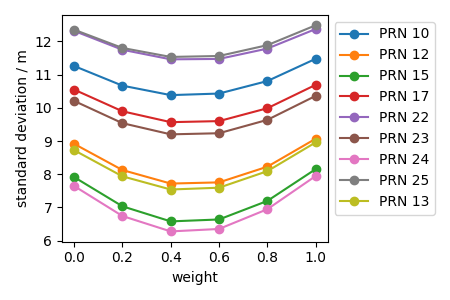

In [29]:
# code phase standard deviations

import json
import matplotlib.pyplot as plt
import numpy as np

with open('data/230914_cpStdDev.json','r') as file:
    res = json.load(file)    
    
x = np.linspace(0,1,6)

fig,ax = plt.subplots(figsize=(4.5,3))
fig.canvas.header_visible = False

for satNo in res:
    if satNo != '19':
        ax.plot(x,res[satNo],'o-',label='PRN '+satNo)

ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('weight')
ax.set_ylabel('standard deviation / m')
plt.tight_layout()
    
plt.show()


The plot clearly shows that both interpolation functions alone (weights 0 and 1) are comparable regarding their results. However, by mixing the methods using a weighted sum the standard deviation can be considerably decreased. For an equal weight of 0.5 for both approaches an improvement of about 10% is achieved. This optimized interpolation method has already been used for the calculation of the previous histogram.

#### Error sources and corrections

The statistical errors in the measurement of the code phase have been already discussed. In addition to these *random* fluctuations, there are other uncertainties that cause systematic deviations. The correction is based on physical models, which are briefly described here.$^1$

**Earth rotation**

A systematic error as a result of the Earth's rotation can be caused by the fact that the calculated positions of the satellites and the  measured pseudo-distances do not apply to the same time.$^2$ The satellite positions are valid for the time of transmission $t_0$ of the signal,  while the pseudo-distances are measured at the time of reception $t_0+\Delta t$, which is somewhat later due to the transit time $\Delta t$ of the signal. With radius $R$ and angular velocity $\Omega$ of the Earth, a receiver at latitude $\vartheta$ has a speed of $v = \Omega R\cos\vartheta$ and thus changes its position within $\Delta t$ by a shift of $v \Delta t$. For example, if the receiver is located at latitude $\vartheta = 50^\circ$, its position will shift in the easterly direction within a typical transit time of $\Delta t\simeq 80\,\rm ms$ by

$$\Delta s = \frac{2\pi R\cos\vartheta}{T}\cdot \Delta t = 299.2\,{\rm \frac m s}\cdot 0.08\,{\rm s} = 23.9\,\rm m \ .$$

Here $T=24\,\rm h$ is the Earth's orbital period and $R=6400\,\rm km$ is the Earth's radius.

Let's look again at the example of satellites PRN24 and PRN25 from the previous chapter. The rotation of the Earth has practically no effect on the measured pseudo-distance of PRN24, which is vertical in the sky, but the pseudo-distance of PRN25 in the southwest near the horizon increases considerably by $20\,\rm m$ (see satellite positions in the polar diagram). The satellite PRN22 is also located at the horizon, but in the northeast, i.e. in the opposite direction. Therefore its pseudo-distance is decreased by $20\,\rm m$. To correct the error for the deviation of actual distance (for $t_0$) and pseudo-distance (for $t_0+\Delta t$), we can simply calculate the actual distance for the time $t_0+\Delta t$ by adding the shift $\Delta s$ to the receiver's position. This is done in the script if the global variable *EARTH_ROT_CORR* is set *True*. Then we get for the corrected mean values of the histogram

$$ {\rm PRN\,24/25}: \ \Delta x = -14.9\,{\rm m} \ ; \qquad {\rm PRN\,24/22}: \ \Delta x = 3.0\,{\rm m} \ .$$  

From this short discussion, it can be clearly seen that the Earth's rotation has a strong influence on the measurement of pseudo-distances and thus on the position fixing for GPS tracking. Correcting this error is relatively easy because it is based on a well-known physical model.

---
1. *For a detailled discussion, see APPENDIX A in [Global Positioning System Standard Positioning Service Performance Standard, 5th edition (2020)](https://www.gps.gov/technical/ps/2020-SPS-performance-standard.pdf)*
2. *More generally this can be attributed to the [Sagnac effect](https://en.wikipedia.org/wiki/Sagnac_effect).*

**Relativistic time**

There is another important systematic error which is due to the *relativistic time dilation*. Before discussing this effect in detail, you can calculate its consequences regarding the measured pseudo-distances already here. For this purpose, you can activate its correction in the previous script by setting the global variable *REL_CORR* to *True*, in addition to *EARTH_ROT_CORR=True*. The results obtained with both corrections applied are 

$$ {\rm PRN\,24/25}: \ \Delta x = -0.8\,{\rm m} \ ; \qquad {\rm PRN\,24/22}: \ \Delta x = 12.0\,{\rm m} \ .$$  

As in the case of the Earth's rotation, the systematic error cannot be neglected if an absolute error in the range of less than 10 m is aimed for.

Very precise experiments show that a clock on Earth measures a different time duration between two events$^1$ than a completely equivalent clock on a satellite ([time dilation](https://en.wikipedia.org/wiki/Time_dilation)). According to the special and general theory of relativity, two physical quantities are responsible for this: the strengths of the gravitational field $\Phi$ at the positions of the clocks and the velocities $v$ of the clocks. For a fictitious observer at the center of the Earth$^2$ with a clock measuring a time duration ${\rm d}t$ between the events, the corresponding time duration ${\rm d}\tau$ measured by a clock at a location at distance $r$ from the center is approximately given by $^3$

$$ {\rm d}\tau = \left(1 - \frac 1 2\,\frac{v^2}{c^2} - \frac{G\,M}{c^2}\,\frac 1 r\right)\,{\rm d}t \ . $$

Here, $G$ is the gravitational constant, $M$ the mass of the Earth and $c$ the speed of light. After a time period of $\Delta t=1\,\rm s$, a clock on the Earth's surface will show a time deviation of

$$ \Delta\tau_{\rm E} = - \frac{G\,M}{c^2}\,\frac 1 {R_{\rm P}} $$

with the polar radius $R_{\rm P}$ of the Earth.$^4$ In contrast, the clock on a satellite in a circular Earth orbit with radius $R_{\rm S}$ has a different time deviation of $^5$

$$ \Delta\tau_{\rm S} = -\frac 3 2\,\frac{G M}{c^2}\,\frac 1 {R_S}  \ . $$

For an observer on Earth, the clock on the satellite therefore runs faster with a time shift per second of

$$ \Delta t_{\rm S} = \frac{G\,M}{c^2}\left(\frac 1 R_{\rm P}- \frac 3 2\,\frac 1 {R_S} \right) \simeq 0.447\,\rm ns $$

with values $R_{\rm P} = 6357\,\rm km$ and $R_{\rm S} = 26570\,\rm km$. The clock time difference grows linearly with time $t$ and is already $0.014\,\rm s$ after one year. This has little influence on the accuracy of the positioning, as only differences in the pseudo-distances are included and these only change by around $1\,\rm cm$ within the propagation time. On the other hand, the GPS time is then no longer synchronized with the normal time and the time references must be adjusted. Therefore, a different approach is chosen and the frequencies of the atomic clocks on the satellites are changed such that the time signals received on Earth (without Doppler effect) correspond exactly to the UTC time. The basic frequency $10.23\,\rm MHz$ is adjusted to $10.22999999543\,\rm MHz$.

However, the necessary correction due to time dilation is not yet complete, because the satellite orbit is not a circular orbit, but an ellipse with eccentricity $e$ and a large semi-axis $a$. As a result, the gravitational potential $\Phi(r)$ and orbital velocity $v$ change periodically with time, so that the time dilation also undergoes corresponding changes. The GPS signal specifications use the following formula for relativistic correction 

$$ \Delta t_{\rm r} = -2\frac{\sqrt{G M a}}{c^2}\,e\,\sin E $$

with eccentric anomaly $E$. In the mathematical appendix [Relativistic correction term](#Relativistic-correction-term), it is derived elementarily for interested readers using the formulas given for time dilation and elliptical orbits. For readers who are less familiar with methods of differential calculus, it is confirmed here again numerically in a script. To do this, Kepler's equation$^6$ for calculating $E$ as a function of time is first solved for an elliptical orbit with eccentricity $e$ and major semi-axis $a$. This gives the distance $r(t)$ to the focal point of the ellipse (Earth); the orbital velocity $v(t)$ is determined from the conservation of energy and angular momentum. The quantities are inserted into the formulas for time dilation and numerically integrated. Finally, the difference is calculated from the mean value, the correction of which is already known. The plot shows a very good agreement between the numerical solution (blue) and the given formula (orange) for a typical eccentricity of $e=0.01$.$^7$ The largest time shift is about $\Delta t = 20\,\rm ns$, which corresponds to a change in pseudo-distance of $\Delta l =6\,\rm m$. The GPS specifications state that eccentricities of up to $0.03$ are possible. This makes it obvious that corrections to the relativistic time dilation are essential for absolute positioning accuracy in the meter range. 



---
1. *For example, you can imagine the flashes of a rapidly blinking star in the universe as events.*
2. *Approximately an inertial frame in general relativity*.
3. *There must be $v^2/c^2\ll 1$ and $\Phi/c^2\ll 1$. Proper time $\tau$ is the time of a clock in its rest frame.*
4. *For the Earth ellipsoid, $R_{\rm P}$ is the distance to a pole. There the rotational speed is zero. At other locations on the Earth surface, the proper time is the same, as the dilation effects of centrifugal potential and changes in distance compensate each other.*
5. *The velocity $v$ is replaced by the relationship $v^2/r = G M/r^2$ for the centrifugal acceleration on a circular orbit.*
6. *See [Satellite orbits and positions](#Satellite-orbits-and-positions)*
7. *For eccentricities $e \le 0.03$ the agreement is still good even if the mean anomaly $M$ instead of the eccentric anomaly $E$ is used in the equation (error is about $1\,\rm ns$).*


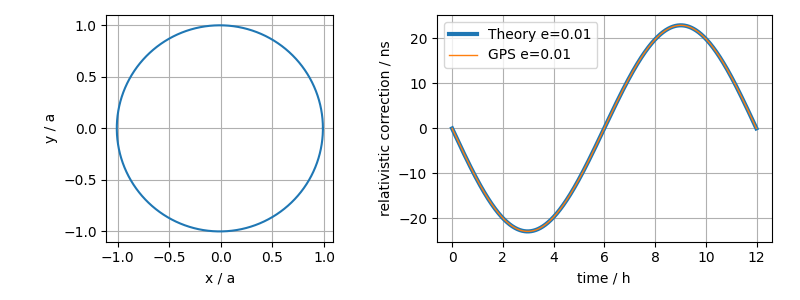

In [23]:
# Example 15: relativistic correction due to elliptic orbit

%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

G = 6.6743015E-11               # gravitational constant
ME = 5.9722E24                  # earth mass
REP = 6356752                   # earth radius to pole, WGS84
GPS_C  = 2.99792458e8           # speed of light as defined for GPS
F = -2*np.sqrt(G*ME)/GPS_C**2   # GPS -4.44280763E-10
a = 26600000                    # major axis
N = 10000                       # number of point for integration and plot 
e = 0.01                        # eccentricity
b = a*np.sqrt(1-e**2)           # minor axis; e*a = sqrt(a**-b**2)

TE = 2*np.pi*np.sqrt(a**3/(G*ME))   # time period

# Kepler equation: M=E-e*sin(E) with M mean anomaly and E eccentric anomaly
def kepler(M,e):
    itMax=10
    eps=1.0E-12
    E = []
    for M_k in M:
        E_k = M_k        
        it = 0
        q0 = 0
        while abs(E_k-q0) > eps and it < itMax:
            q0 = E_k
            E_k = q0-(q0-e*np.sin(q0)-M_k)/(1-e*np.cos(q0))            
            it += 1            
        E.append(E_k)
    E = np.asarray(E)
    return E

M = np.linspace(0,2*np.pi,N)               # mean anomaly
t = M/(2*np.pi)*TE                         # time

E = kepler(M,e)                            # eccentric anomaly

x = a*np.cos(E) - a*e                      # used for plot
y = b*np.sin(E)                            #      "
r = np.sqrt(x**2 + y**2)                   # distance to earth
# as an alternative you can use:
# r = a*(1-e*np.cos(E))

Phi = -G*ME/r                              # potential
v = np.sqrt(G*ME*(2/r - 1/a))              # velocity

gammaS = 1 - v**2/(2*GPS_C**2)             # special relativity
gammaG = 1 + Phi/GPS_C**2                  # general relativity, only potential
dtr = (gammaS + gammaG - 2)                # correction for clock on satellite
dtrMean = np.mean(dtr)
dtrTheory = np.cumsum(dtr-dtrMean)*t[1]    # relativistic correction 
dtrGPS = F*e*np.sqrt(a)*np.sin(E)          # Replace here E with M to see 
                                           # differences (see text)

gammaOnEarth = 1 - G*ME/(REP*GPS_C**2)     # equal at earth surface due
dtrEarth = gammaOnEarth-1                  # to centrifugal potential 

fig,(ax,bx) = plt.subplots(1,2,figsize=(8,3))
fig.canvas.header_visible = False

ax.set_aspect('equal')
ax.plot(x/a,y/a)
ax.grid()
ax.set_xlabel('x / a')
ax.set_ylabel('y / a')

bx.plot(t/3600,dtrTheory/1E-9,lw=3,label='Theory e=%1.2f' % (e))
bx.plot(t/3600,dtrGPS/1E-9,lw=1,label='GPS e=%1.2f' % (e))
bx.set_xlabel('time / h')
bx.set_ylabel('relativistic correction / ns')
bx.grid()
bx.legend()

plt.tight_layout()
plt.show()


**Ionosphere and troposphere**

The ionosphere is part of the Earth's atmosphere and extends at altitudes of around $80\,\rm km$ to $1000\,\rm km$. The high-energy components of solar radiation cause the partial ionization of atmospheric gases, resulting in electrically charged particles (plasma). As a direct consequence, electromagnetic radiation in the radio frequency range is affected. Depending on the total electron content (TEC), the propagation time of the $L1$ frequency on its way through the ionosphere is increased to a greater or lesser extent. The delay is expressed as (optical) path length and depends on the frequency $f$ of the radiation,$^1$

$$ \tau^{iono} = \kappa \frac{\rm TEC}{f^2} \quad; \ \kappa \simeq 40.31\,\rm m^3/s^2 \ . $$

Typical daily values are expressed in units of TECU (TEC units) on a scale from 0 to 100. The unit is defined by $\rm 1\,TECU = 10^{16}\,electrons/m^2$. The delay depends also on the elevation angle between receiver and satellite, since the signal's path through the ionosphere is much longer when the satellite is close to the horizon. The simplified model used in the GPS signal specifications assumes a minimum delay of $\tau_{\rm min}^{iono} \simeq 1.5\,\rm m$ (9.2 TECU in the formula) and a maximum correction factor for the elevation angle of 3. The large daily fluctuations of the TEC value cause the largest uncertainties for the position measurement with standard deviations of $\sigma \simeq 5\,\rm m$.$^3$

A frequently used method for measuring the TEC value makes use of the frequency dependence of the delay by measuring at the $L2$ frequency in addition to the $L1$ frequency. There are also a number of models for correction. One is presented in the GPS signal specifications and should lead to a reduction in error of at least 50%. Its parameters are sent in subframe 4 (page 18). In general, the strength of the effect depends strongly on solar radiation, the Earth's magnetic field and a variety of events in the higher atmospheric layers,$^2$ so that each model is dependent on information that is as up-to-date as possible.$^3$ 

The humidity in the troposphere, the atmospheric layer in which the weather takes place, can also cause a signal delay. This effect is much more localized and can change rapidly, making correction more difficult than in the case of the ionosphere. The contribution to the uncertainty of the positioning is given as $\pm 0.5\,\rm m$.$^3$

For the program code developed here, the effects of the troposphere and ionosphere are not taken into account.

---
1. *Wikipedia, [Total electron content](https://en.wikipedia.org/wiki/Total_electron_content)*
2. *Wikipedia, [Ionosphere](https://de.wikipedia.org/wiki/Ionosph%C3%A4re)*
3. *Wikipedia, [Error analysis for the Global Positioning System](https://en.wikipedia.org/wiki/Error_analysis_for_the_Global_Positioning_System)*

#### Reference and transmission times
This chapter deals with the definition of the transmission times used to determine the code phases. It can be omitted if a detailed understanding of the program code is not initially desired.

The algorithm for calculating the pseudoranges decribed in the previous chapters is basically retained for the positioning with many satellites. However, usually the satellites will not have equal time references TOW. It is then necessary to calculate the time interval of two different times given as (TOW_0,DT_0) and (TOW_1,DT_1). For the following examination, we assume that the reference times of two satellites are $T_n = n\cdot 6\,\rm s$ and $T_m = m\cdot 6\,\rm s$, $ m > n$. It is further assumed that the value of the cycle time $T_{\rm cyc}$ is a power of two (in ms). We specify, as in the previous script, that the transmission times $t_{n,k}$ and $t_{m,l}$ of the signals to be used are given by the satellite's reference time plus integer multiples of $T_{\rm cyc}$, i.e.

$$ t_{n,k} = T_n + k\cdot T_{\rm cyc} \quad;\quad t_{m,l} = T_m + l\cdot T_{\rm cyc} \quad\text{with}\quad n,m,k,l \in \mathbb{N} \ . $$

The time difference is then given by

$$ \Delta t_{n,k;m,l} = (m-n)\cdot 6\,{\rm s} + (l-k)\,\rm T_{\rm cyc} \ . $$

To calculate the receiver position, measured signals of the same time of transmission from different satellites must be found. Therefore we demand that there are always solutions for $\Delta t_{n,k;m,l}=0$, hence

$$ (m-n)\cdot 6\,{\rm s} = (k-l)\,\rm T_{\rm cyc}  \ . $$

For $T_{\rm cyc} = 16\,\rm ms$ you will always find a solution, as $6\cdot1000\,\rm ms$ is divisible by $16\,\rm ms$ as an integer. However, with the assumption $T_{\rm cyc} = 32\,\rm ms$ we find that $k-l$ can only be an integer if $m-n$ is an even number. As a workaround, we add a constant offset $T_{\rm offset}$ to the equation which is different for even and odd TOW. For $T_{\rm cyc} = 32\,\rm ms$ we then get the following solution for the transmission times of the signals to be used for measurements

$$
t_{n,k}=T_n +T_{\rm offset}+ k\cdot T_{\rm cyc} \qquad\text{with}\qquad
T_{\rm offset} = \begin{cases}
  0 & \text{if TOW(n) even,}\\
  16\,{\rm ms} & \text{if TOW(n) odd}.
\end{cases}
$$

In case of $T_{\rm cyc}>32\,\rm ms$ and if $T_{\rm cyc}$ is a power of two the values for $T_{\rm offset}$ can be calculated by the general formula (Python code, all time values in ms):

        TOFF = (TOW % 2**(TCYC // 32)) * 16 if TCYC > 16 else 0

With this setting the transmission times are equidistant and can be expressed as a combination of *week of time* TOW and number of data streams $k$. However, it is not immediately apparent whether a time given by (TOW,k) is equal to another time given by (TOW',k'). Therefore it is defined that the TOW value must always be maximized and the stream number $k$ minimized such that $k < k_{\rm max}$ with $k_{\rm max}\cdot T_{\rm cyc} < 6\,\rm s$.$^1$ Such a conversion is done in the following code (time values in ms):

        while k*TCYC + TOFF >= 6000:
            TOW += 1
            TOFF = (TOFF + 16) % TCYC
            k = k - kmax -1 if TOFF > 0 else k - kmax

It can also be useful to convert a reference (TOW, ST) into a reference with a larger TOW if the stream numbers SNO of the code phases get large. With the length NGPS of a data stream, a possible algorithm for that is: 

        while (ST + 6*SAMPLE_RATE) // NGPS < SNO:  
            ST += 6*SAMPLE_RATE
            TOW += 1
            TOFF = (TOFF + 16) % TCYC    

---
1. *Another solution is to replace the tuple by a time in ms, t = TOW\*6000+TOFF+k\*32*

#### Least squares approximation

With a sufficient number of known satellite positions and measured pseudoranges, it is possible to calculate the current position of the receiver. For each of the $m$ satellites there is an equation with four unknowns: the three Cartesian coordinates $e_x$, $e_y$ and $e_z$ of the receiver as well as the unknown transmission time $t_0$ on the non-synchronized receiver clock. To solve a system of equations with four unknowns, at least four determining equations are required, which is why data from at least four satellites is usually needed. However, it is generally better to observe more than four satellites, as in many cases the measurement uncertainty of the pseudo-distances for a certain direction produces much greater fluctuations than perpendicular to it - the point cloud of many position determinations is an ellipsoid with axes of different lengths. This is mostly the result of an unfavorable constellation of the observed satellites. If, for example, they are all low on the horizon, the measured propagation times change only slightly with the height of the receiver, so that the measurement uncertainties of the pseudo-distances in this direction result in a much larger standard deviation. This effect is known as *dilution of precision* (DOP). Due to the measurement errors, it is therefore advantageous to calculate the receiver position with an *overdetermined* system of equations $m > 4$. This is usually done in such a way that the result of an individual equation depend only on the uncertainties and is ideally zero. A *least squares method* is then used to vary the *free parameters*, i.e. $(t_0,e_x,e_y,e_z)$, in such a way that the sum of the error squares of all equations is minimized.

**System of equations**

For the $m$ satellites, the relationship between pseudo-distances $P_i=c\,(t_i-t_0)$, satellite positions $\vec S_i = (s_{i,x},s_{i,y},s_{i,z})$ and the receiver position $\vec E = (e_x,e_y,e_z)$ with $i\in \{1\ldots m\}$ is given by

$$ l_i = \sqrt{(s_{i,x}-e_x)^2 + (s_{i,y}-e_y)^2 + (s_{i,z}-e_z)^2} = c\cdot (t_i - t_0) \ . $$

The quantities to be inserted into these equations are the measured time intervals $\delta t_i = t_i-t_1$. This is done using the relations $c(t_i - t_0) = c\delta t_i + p$ with the unknown pseudo-distance $p = c(t_1-t_0)$ of any satellite. The function to be minimized is then $R(p,e_x,e_y,e_z) = \sum_i r_i^2$ with the uncertainties or *residuals* $r_i$ given by
   
$$ r_i(p,e_x,e_y,e_z) = \sqrt{(s_{i,x}-e_x)^2 + (s_{i,y}-e_y)^2 + (s_{i,z}-e_z)^2} - p - c\,\delta t_i \ . $$  

The formulation with $p$ instead of $t_0$ as a parameter has the advantage that it does not depend on the absolute value of the sampling time and $p$ can be estimated well from a limited range of possible values.

**Gauss-Newton algorithm**

There are various methods for solving a *non-linear* system of equations. The Gauss-Newton algorithm used here is related to the iterative determination of zeros of one-dimensional functions according to Newton. As there, a linearization of the problem is obtained by calculating the direction to the minimum of a function using its first derivatives. In contrast to another popular approach, the Marquardt method, the second derivatives are not required.$^1$ The equivalent of the simple derivative for multidimensional functions is the Jacobian matrix. For a function $f$ with $m$ component functions $f_i$ and $n$ variables $x_j$, it is defined at the point $a \in \mathbb{R}^n$ by$^2$

$$ 
 {\displaystyle J_{f}(a):=\left({\frac {\partial f_{i}}{\partial x_{j}}}(a)\right)_{i=1,\ldots ,m;\ j=1,\ldots ,n}={\begin{pmatrix}{\frac {\partial f_{1}}{\partial x_{1}}}(a)&{\frac {\partial f_{1}}{\partial x_{2}}}(a)&\ldots &{\frac {\partial f_{1}}{\partial x_{n}}}(a)\\\vdots &\vdots &\vdots &\ddots &\vdots \\{\frac {\partial f_{m}}{\partial x_{1}}}(a)&{\frac {\partial f_{m}}{\partial x_{2}}}(a)&\ldots &{\frac {\partial f_{m}}{\partial x_{n}}}(a)\end{pmatrix}}}
$$ 

For the given residuals $r = f$ and the variables $x = (x_1,x_2,x_3,x_4) = (p,e_x,e_y,e_z)$ we obtain the following components for the Jacobian matrix

$$ 
  \frac{\partial r_i}{\partial p} = -1 \quad;\quad
  \frac{\partial r_i}{\partial e_x} = \frac{e_x - s_{i,x}}{l_i} \quad;\quad
  \frac{\partial r_i}{\partial e_y} = \frac{e_y - s_{i,y}}{l_i} \quad;\quad
  \frac{\partial r_i}{\partial e_z} = \frac{e_z - s_{i,z}}{l_i} \ .
$$  

The approximate solution for the variables $x_j$ is then obtained iteratively by the vector equation$^3$ 

$$ x^{(k+1)} = x^{(k)} - \bigl(J_r^T\,J_r\bigl)^{-1}\,J_r^T\cdot r\bigl(x^{(k)}\bigl) $$

where $J_r^T$ is the transpose of $J_r$ and $k$ represents the iteration steps. A weighting matrix $W$ of the measurement uncertainties can be included in it.$^4$ The iteration is terminated if the sum of the error squares falls below a specified threshold or no solution is found within a specified number of iterations $k_{\rm max}$. 

---
1. *With known curvature (2nd derivative), the minimum can be found with fewer iterations, but its calculation is complex (Hessian matrix).*
2. *Wikipedia, [Jacobi matrix](https://de.wikipedia.org/wiki/Jacobi-Matrix)*
3. *Wikipedia, [Gauss-Newton algorithm](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm)*
4. *Wikipedia, [Weighted Least Squares](https://en.wikipedia.org/wiki/Weighted_least_squares)*

**Implementation**

The Gauss-Newton algorithm can be easily mapped in Python using the *numpy* module and was implemented in the *LeastSquaresPos()* function of the *gpslib* module. As an option, the height $h$ above the earth's surface can be specified as a secondary condition if its value at the receiver's position is known.$^1$ In that case it is sufficient to observe at least three satellites. For $m>3$ the specification of $h$ can help to improve the DOP values.$^2$

In an example of measuring the pseudo-distance, it has already been discussed that the Earth's rotation has to be taken into account to avoid a systematic error (see [Error sources and corrections](#Error-sources-and-corrections)). The error is caused by the fact that the calculated positions of the satellites and the measured pseudo-distances do not apply to the same time due to the propagation time of the signals. There are various ways to correct this. The simplest approach is to first calculate the position without any correction and then *turn back* the Earth for the mean propagation time found. The remaining error of this approximation is at most in the range of a few meters and usually negligible compared to other systematic errors. On the other hand, correct consideration is not much more complex and thus avoids unnecessary uncertainties. 

The approach taken here is based on the method already introduced in a simplified way with the calculation of pseudoranges. The distance $l_i$ to the satellite $i$, which applies to the signal transmission time $t_0$, is expanded by the position shift $\vec q_i=(q_{i,x},q_{i,y},q_{i,z})$ due to the Earth's rotation within the transit time $t_i-t_0$,

$$ l_i = \sqrt{(s_{i,x}-e_x-q_{i,x})^2 + (s_{i,y}-e_y-q_{i,y})^2 + (s_{i,z}-e_z-q_{i,z})^2} \ , $$

so that $l_i$ now applies to the time $t_i$ of signal reception. As the displacement $\vec q_i$ depends on $l_i$ and on the receiver position, it is recalculated for each satellite in each iteration of the least squares algorithm. For a receiver position $\vec E$, propagation time $\Delta t_i= l_i/c$ and angular velocity $\vec \Omega = (0,0,\Omega)$ of the Earth, the displacement vector $\vec q_i$ is calculated by

$$
\vec q_i = \vec E \times \vec\Omega \cdot \Delta t_i 
 = \begin{pmatrix} e_x\\e_y\\e_z\end{pmatrix}\times\begin{pmatrix} 0\\0\\\Omega\end{pmatrix}\cdot \Delta t_i
 = \begin{pmatrix} e_y\\-e_x\\0\end{pmatrix}\cdot\Omega \Delta t_i \ .
$$

As a result of the least-squares fit, the receiver position $(e_x,e_y,e_z)$ at the transmission time $t_0$ is obtained as desired.

---
1. *The elevation in the WGS84 earth model is used, not the elevation above sea level. These can differ significantly from each other*.
2. *For setting the height condition the WGS84 ellipsoid model was used. Furthermore, the Jacobian matrix had to be changed accordingly.*

#### Positioning with sample data

**Calculation steps**

All the building blocks are now in place to determine the position of a receiver. The following process steps have been described in detail using one or two satellites:

- Receiving and decoding the subframes
- Reading the ephemeris and correction parameters
- Calculation of the satellites' positions for fixed measurement times
- Measuring the corresponding reception times at the receiver (code phases)

In an example script, the given measurement data is used to determine the receiver's position by applying the least squares approximation. However, to keep the Python code as clear as possible, the above steps are not repeated here. Instead, the corresponding results for *all* satellites present in the original data are loaded from a file into the list *resLst*. A single entry of *resLst* is a tuple of the following values (in the same order)

1. satellite identifier $\rm satNo \in \{2\ldots 32\}$
2. time of week TOW
3. satellite position x,y,z
4. corrected reception time (smpTime) in seconds
5. week number of the GPS time
5. stream number k
6. standard deviation of the code phases in meters

These variables were discussed in the course of the tutorial. The transmission times are coded as (TOW, k) and the date and time of measurement can be calculated using the *week number*. The further steps for fixing the position are carried out in *ecefPositions()* and consist of preparing the data and pass it to the *LeastSquaresPos()* function:
- The list *resLst* is sorted in lexical order by TOW and stream number k
- All entries of *resLst* are run through in a loop: 
    - Entries with the same time of transmission (TOW, k) are copied to a list *bLst*.
    - If the number of entries is $m \ge \rm CALC\_SAT$, they are passed to *LeastSquaresPos()*.
    - If successful, the result of *LeastSquaresPos()* and the measurement time are saved in the list *recPosLst*.
    
The calculated positions are given for a Cartesian coordinate system with origin in the center of the earth (ECEF). The *ecefToGeo()* function of the *gpslib* module is called to convert it into the usual geodetic coordinates with latitude, longitude and altitude. Finally, as before, a conversion to a local Cartesian coordinate system at the receiver's position is carried out using *ecefToAzimElev()*. The corresponding data is saved in the *locTrack* list.

**Evaluation of sample data**

<img align="right" width="250" src="figures/230914_Position.PNG">

The measurement data comes from a total of 11 satellites during a measurement period of around $12\,\rm min$ and contains 236027 entries for a maximum of 22944 position fixes when using a minimum of 4 satellites.$^1$ The number of positions to be calculated can be limited with the parameter MAX_NO_POS to speed up the display of the results. The adjustable parameters for the least squares routine are: LSF_WEIGHT, MAX_RESIDUAL, LSF_MAX_IT, HEIGHT, HEIGHT_DEV. If  CONFINE_HEIGHT is set true the value of HEIGHT (in meters) is used as a constraint to improve the DOP values - the permitted standard deviation is set in HEIGHT_DEV.

For the measurement a location was chosen that allows a clear view of the sky in all directions down to the horizon in order to capture as many satellites as possible. In the adjacent figure, the mean value of the calculated position is shown on a map.$^2$ The real receiver position matches this to within a few meters. 

With the following script several graphs are generated to display the random deviations from the mean value. 

---
1. *These results were calculated by the program [GPS-SDR-Receiver](https://github.com/annappo/GPS-SDR-Receiver]) using the file* 230914_data_12m.bin *from [HiDrive Share](https://my.hidrive.com/share/ngox89fz9p).*
2. *latitude 49.082961°N, longitude 8.307581°E, altitude 164.539 m (WGS84)*

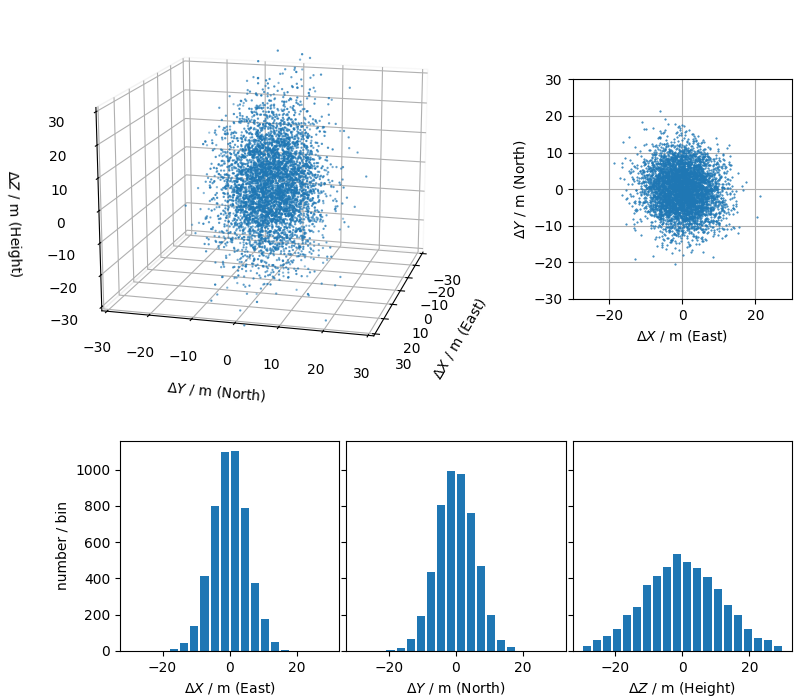

In [16]:
# Example 16: position calculation from measured data

%matplotlib widget 

import json
import pycode.gpslib_tutorial as gpslib
import numpy as np
import matplotlib.pyplot as plt
import datetime

N_CYC = 32
LSF_WEIGHT = True
MAX_RESIDUAL = 1.0E-7
LSF_MAX_IT = 10
HEIGHT = 165.7              
HEIGHT_DEV = 10             # allowed standard deviation for height
SAT_ALL = [12,17,25,24,19,15,13,10,22,32,23]

PLOT_RANGE = 30             # in meter
MAX_NO_POS = 5000           # number of positions to be calculated 
                            # (max is 13060)
SAT_LIST = SAT_ALL
CALC_MIN = 11               # sets the minimum number of sats for the 
                            # calculation
CONFINE_HEIGHT = False      # if True HEIGHT is used as a constraint


def loadJsonLst(fname):
    with open(fname,'r') as file:
        lst = json.load(file)  
    return lst

# resLst = list of tuples (satNo,tow,x,y,z,smpTime,weekNum,streamNo,cpStd)
def ecefPositions(resLst,maxNoPos):   
    minSat = 3 if CONFINE_HEIGHT else 4
    calcSat = max(CALC_MIN,minSat)
    locStart = [0,0,0,0]                         
    
    lsfFailLst,lsfExcLst,recPosLst = [],[],[]

    noPos = 0
    r = 0
    resLst.sort(key = lambda e: (e[1],e[7],e[0]))
    while r < len(resLst):
        bLst=[resLst[r]]
        tow,streamNo = resLst[r][1],resLst[r][7]
        r += 1
        while r < len(resLst) and (resLst[r][1],resLst[r][7])==(tow,streamNo):
            bLst.append(resLst[r])
            r += 1            
        nSat = len(bLst)
        if nSat >= calcSat:              
            satCoord = np.zeros((3,nSat))
            timeDel = np.zeros(nSat)
            timeStd = np.zeros(nSat)
            for i in range(nSat):
                weeknum = bLst[i][6]
                satCoord[:,i]=bLst[i][2:5]
                timeDel[i] = bLst[i][5]
                timeStd[i] = bLst[i][8]   
            stdDev = timeStd if LSF_WEIGHT else None

            try:
                # output: recPos = (t0,x,y,z)                
                recPos,res,_,_ = gpslib.leastSquaresPos(minSat,
                                                satCoord,timeDel,
                                                maxResidual=MAX_RESIDUAL,
                                                maxIt=LSF_MAX_IT,
                                                recPos=locStart,
                                                height=HEIGHT,
                                                hDev=HEIGHT_DEV,
                                                stdDev=stdDev) 
            except:
                lsfExcLst.append((tow,streamNo)) 
            else:
                if res[-1] <= MAX_RESIDUAL:
                    gpsTime = gpslib.gpsTime(tow,weeknum)\
                             +datetime.timedelta(seconds=streamNo*N_CYC/1000)
                    # POSIX (UNIX) time in sec 
                    recPos[0] = gpsTime.timestamp()                      
                    recPosLst.append(recPos)         # recPos=(gpsTime,x,y,z)
                    noPos += 1
                    if noPos >= maxNoPos:
                        break
                else:
                    lsfFailLst.append((tow,streamNo))                                              
                    
    return recPosLst,lsfFailLst,lsfExcLst
    
    
resLst = loadJsonLst('data/230914_gpsPositions.json')
resLst = list(filter(lambda item: item[0] in SAT_LIST,resLst))

recPosLst,lsfFailLst,lsfExcLst = ecefPositions(resLst,MAX_NO_POS)
_,xs,ys,zs = zip(*recPosLst)
xm,ym,zm = np.mean(xs),np.mean(ys),np.mean(zs)
ecefMeanPos = (xm,ym,zm)

locTrack = []
geoMeanPos = gpslib.ecefToGeo(ecefMeanPos)  # geo = (lat,lon,height)
for recPos in recPosLst:
    geoPos = gpslib.ecefToGeo(recPos[1:])     
    locX,locY = gpslib.locDistFromLatLon(geoMeanPos,geoPos) 
    locZ = geoPos[2]-geoMeanPos[2]
    locTrack.append((locX,locY,locZ))                            

locX,locY,locZ = zip(*locTrack)
locStdDev = np.std((locX,locY,locZ),axis=1)
        
# --- plot results ----------------    
    
fig = plt.figure(figsize = (8,7))
fig.canvas.header_visible = False
spec = fig.add_gridspec(6, 9)
ax1 = fig.add_subplot(spec[0:4, 0:4],projection='3d')
ax2 = fig.add_subplot(spec[0:4, 6:9],aspect='equal')
fig.subplots_adjust(left=0.15, bottom=0.07, right=0.99, top=1.05, 
                    wspace=0.1, hspace=0.3)

ax1.scatter(locX, locY, locZ, marker='o',s=0.5)
ax1.view_init(elev=15, azim=15)
ax1.set_box_aspect(None, zoom=1.4)

ax1.set_xlim(-PLOT_RANGE,PLOT_RANGE)
ax1.set_ylim(-PLOT_RANGE,PLOT_RANGE)
ax1.set_zlim(-PLOT_RANGE,PLOT_RANGE)
ax1.set_xlabel('$\Delta X$ / m (East)') 
ax1.set_ylabel('$\Delta Y$ / m (North)')
ax1.set_zlabel('$\Delta Z$ / m (Height)')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.grid(True)

ax2.plot(locX,locY,'o',ms=.5)
ax2.set_xlim(-PLOT_RANGE,PLOT_RANGE)
ax2.set_ylim(-PLOT_RANGE,PLOT_RANGE)
ax2.set_xlabel('$\Delta X$ / m (East)') 
ax2.set_ylabel('$\Delta Y$ / m (North)')
ax2.grid()

pltRange = (-PLOT_RANGE,+PLOT_RANGE)

ax3 = fig.add_subplot(spec[4:6,0:3])
ax3.hist(locX,bins=20,rwidth=0.8,range=pltRange)
ax3.set_xlabel('$\Delta X$ / m (East)')
ax3.set_ylabel('number / bin') 

ax4 = fig.add_subplot(spec[4:6,3:6],sharey=ax3,sharex=ax3)
ax4.hist(locY,bins=20,rwidth=0.8,range=pltRange)
plt.setp(ax4.get_yticklabels(), visible=False)
ax4.set_xlabel('$\Delta Y$ / m (North)')

ax5 = fig.add_subplot(spec[4:6,6:9],sharey=ax3,sharex=ax3)
ax5.hist(locZ,bins=20,rwidth=0.8,range=pltRange)
plt.setp(ax5.get_yticklabels(), visible=False)
ax5.set_xlabel('$\Delta Z$ / m (Height)')

plt.show()    

In the **upper left-hand plot**, the data is displayed as a three-dimensional point cloud - the cloud can be rotated using a pointer device (e.g. mouse), which makes its mostly ellipsoidal shape visible. This gives a good impression of the direction-dependent DOP. The **plot on the upper right** shows the projection of the cloud onto the Earth plane. 

Compared to such a spatial representation in scatter plots, the **histograms** at the bottom are better suited for a quantitative analysis. As in the case of the pseudoranges (see [Evaluation of the code phases](#Evaluation-of-the-code-phases)) the random scatter of the coordinates of all three directions in space correspond almost perfectly to Gaussian distributions. Their standard deviations are given by

$$
\sigma_x = 5.08\,{\rm m}\quad;\quad \sigma_y=5.51\,{\rm m}\quad ;\quad \sigma_h = 11.41\,{\rm m} \ .
$$

It is instructive to limit the number of satellites and to select different satellites for the calculation. The list SAT_LIST is used for this purpose. The entries given in *resLst* are then filtered so that only results of the selected satellites remain. In addition, the minimum number of satellites for positioning can be specified with CALC_MIN. The calculated point cloud then varies greatly in terms of size, shape and orientation. If, for example, only satellites are selected that are arranged along one direction in the sky, the deviations in the perpendicular direction will get very large.$^1$ If the uncertainty for the height is large, the result is considerably improved if CONFINE_HEIGHT is set true and HEIGHT (in meter, for WGS84) is fixed with permitted deviation HEIGHT_DEV (e.g. $10\,\rm$).

**Uncertainty of the mean position**

For a total time of $12\,\rm min$ the positions were fixed at intervals of $T_{\rm cyc}=32 \,\rm ms$. With regard to positioning it is interesting to see how precisely a mean position can be determined over a limited time period as, for example, $\Delta t=1\,\rm s$. The uncertainty $\Delta \bar p$ of a mean position $\bar p$ depends on the standard deviation $\sigma_p$ but also on the number of positions $N$ available for the calculation of the mean in this period $\Delta t$. As stated before (see [Code phase interpolation](#Code-phase-interpolation)) this error is given by$^2$

$$ \Delta \bar p = \pm\frac{\sigma_p}{\sqrt N} \ .$$

The more measurements are done within $\Delta t$, the better is the accuracy of the calculated mean position. With $T_{\rm cyc} =32\,\rm ms$ the number of measurements $N$ within $\Delta t=1\,\rm s$ is approximately given by $N=32$. With the standard deviations from the given example, we conclude

$$
\Delta \bar x = 0.90\,{\rm m}\quad;\quad \Delta \bar y=0.97\,{\rm m}\quad ;\quad \Delta \bar h = 2.02\,{\rm m} \ .
$$

This result clearly demonstrates that a high accuracy of a few meters can be achieved with an inexpensive RTL-SDR stick for measurement intervals in the seconds range. 

**Potential improvements**

The previous discussion suggests that the result could be further improved if the number of calculated positions within 1 sec were increased - a doubling of $N$ decreases the uncertainty of the mean values by a factor of $1/\sqrt 2 \simeq 0.71$. Such a doubling can be achieved in the code by changing the cycle time from $T_{\rm cyc}=32\,\rm ms$ to $16\,\rm ms$ which is equivalent to $\rm N\_CYC=16$. The setting $\rm N\_CYC=8$ could even halve the uncertainty compared to the default value.$^3$

However, halving the cycle time $T_{\rm cyc}$ comes at a price in terms of the computing power required, as both the number of correlation calculations and the number of least squares fits are doubled. Therefore, it strongly depends on the used computer whether lower values of $T_{\rm cyc}$ than $32\,\rm ms$ are reasonable for real-time tracking. The following computational costs resulted from runtime measurements using saved data with a maximum of 10 satellites as input for the real-time code decribed below (see [Real-time tracking](#Real-time-tracking)):

| $T_{\rm cyc}$        | gpsrecv.py | gpseval.py |
|:---:                 | :---:      | :---:      |
| $32 \rightarrow 16$  | + 17%      | +40%       |
| $16 \rightarrow 8$   | + 41%      | +53%       |

My verdict: It is worth trying out a lower cycle time $T_{\rm cyc}$ if you are using a computer system that still has unused capacity when observing all currently available satellites in the sky. Otherwise, an improvement in positioning accuracy is more likely to be achieved by enhancing the *dilution of precision* (DOI) by using more satellites.

---
1. *The satellite positions can be taken from the polar plot of the example in [Satellite orbits and positions](#Satellite-orbits-and-positions).*
2. Strictly speaking, this only applies if the individual results for the position are independent of each other.
3. *The current code for real-time positioning only allows powers of two as values for *N_CYC*. This may change in future versions.*

## GPS tracking using an RTL-SDR

### First steps 

#### Measurement data 

After installing the Python module *pyrtlsdr* (see appendix), the first measurements can be carried out with the RTL-SDR. For a simple function test, the *rtlsdr* module is imported in the following script and an instance of the *RtlSdr()* class is initialized. The sample rate, tuner frequency and gain are defined, then the *read_samples()* function is used to retrieve some values from the USB stick.

In [ ]:
# Example 17: test measurement RTL-SDR

from rtlsdr import RtlSdr

sdr = RtlSdr()

# configure device
sdr.SAMPLE_RATE = 2.048e6  # Hz
sdr.CENTER_FREQ = 70e6     # Hz
sdr.GAIN = 'auto'

lst = sdr.read_samples(2048)
print(lst[:20])
#print(list(sdr.read_bytes(20)))

sdr.close()

If the installation was successful, a list of *complex numbers* of the requested number is output. The imaginary part of a complex number is marked with a *j* at the end. The original output generated by the RTL-SDR consists of two bytes $n$ and $m$ per sample, which is converted by the *read_sample()* function into a complex floating point number $p+i\,q$ using

$$ p = \frac{n}{127.5} - 1 \qquad ;\qquad q = \frac{m}{127.5} - 1 \ . $$

The ranges of real and imaginary parts are normalized to $\pm 1$. The values can also be read in their original format using the *read_bytes()* function. The following variables and functions can be used to configure the RTL-SDR for a measurement:

| Variable / Function | Unit | Range | Description |
|:---------|:--------|:-------:|:------------|
|SAMPLE_RATE | Hz | $\le 2.4\,{\rm MHz}$ | (stable) sampling rate |
|CENTER_FREQ | Hz | $24 \text{ to } 1766\,{\rm MHz}$ |carrier frequency | 
|FREQ_CORRECTION | ppm | $\pm \,n,\,n\in \mathbb{N}$| Offset correction |
|GAIN | dB | $0\dots 49.9$ | Gain (logarithmic scale) |
| set_BIAS_TEE() | | True/False | GPS antenna power supply |

The offset correction of the RTL-SDR is individual and should be determined by test measurements. Typical values are in the range of -2 ppm to +2 ppm. A deviation of 1 ppm leads to a frequency shift of $1575.42\,\rm Hz$. An incorrect offset setting can result in one or more satellites not being detected because the Doppler frequencies are outside the range of $-5000\,\rm Hz$ to $+5000\,\rm Hz$.

#### Signal amplitude 

The following script introduces some functions and structures for carrying out and displaying a continuous measurement in time:
- A Python framework based on *async()/await()* enables the *cooperative* execution of concurrent functions. The functions marked with *async* are started in a *task()*. It should be noted that JupyterLab itself is part of this *parallel* processing, which is why the concurrent *tasks* must be started differently in a notebook than in normal Python scripts.
- During execution, an *async()* function uses *await()* to signal that an interruption is possible. The execution is then passed to another *async()* function. The global variable *MEAS_RUNNING* is used to signal the termination of the script.
- In the code the following two *async()* functions are used:
    - In *streamLive()* the data is read from the RTL-SDR and stored in the data buffer *BUFFER*. 
    - The *processData()* function is used to read the data from the buffer and display it in a plot.

To ensure that the data of the RTL-SDR can always be read out in time, the *average* execution time of the concurrent functions must not take longer than the cycle time $T_{\rm cyc} = N_{\rm gps}/R_S$ of the requested stream with sample length $N_{\rm gps}$ and sample rate $R_S$. If this sometimes happens anyway, e.g. due to necessary background processes of Python or the operating system, the additional data is saved in the buffer.$^1$ If the maximum buffer size is exceeded, the buffer is cleared and *BUFSKIP* reports how many streams have been discarded. It should also be noted that when the module *matplotlib* is used  as interactive user interface, output from *print()* is not shown. Error messages are therefore stored in the global variable *EXC* using the *printException()* function.

To measure your first time-varying signal, it is recommended to connect an FM antenna and set the frequency of a radio station. In the following example, the data from the RTL-SDR is read in over the specified measurement interval *MEAS_TIME*. This is done at a sample rate of $2.048\,\rm MS/s$ to introduce the rate used for GPS measurements. Only the beginning of the stream is then plotted as a function of time. To suppress the noise, a simple low-pass filter is applied using a *convolution* (sliding average over *AVG* data points). The frequency of plot updates can be set via the length of the requested data stream - with the given values, *MSEC* corresponds to the time in milliseconds between the plots.

Two curves are displayed, the real part $I$ and the imaginary part $Q$ of the data. Their amplitudes can be controlled via the *GAIN* of the RTL-SDR. If it is too high, the signals flatten out at amplitudes of $\pm 0.5$ (saturation). At low gains, on the other hand, the amplitudes are always well below $0.5$.

---
1. *The USB driver running in the background has its own buffer, so that the data from the RTL-SDR will not be lost as long as its size is not exceeded.*

In [ ]:
# Example 18: FM radio - signal as function of time

%matplotlib widget

import asyncio
from rtlsdr import RtlSdr
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import deque
import linecache
import sys

# -------------- global variables -------------------        

MEAS_RUNNING = True     # when switched to False all processes are stopped

# configuration SDR
BIAS_TEE = False        # set to True with GPS antenna
SAMPLE_RATE = 2.048e6   
FREQ_CORRECTION = -1    # in ppm
CENTER_FREQ = 106.3e6   # FM in range 87.5e6 - 108e6
GAIN = 6                #'auto' or 0..49.6; tuner GAIN in dB

MSEC = 64               # time in ms between two plots 
NSMP = MSEC*2048        # number of samples per cycle      
NT = 2*2048             # number of points for time plot

NO_AVG = 50             # data number to average
BOX = np.ones(NO_AVG)/NO_AVG  # for low-pass filter (convolution)

MEAS_TIME = 3000.0      # in seconds

DATA_FILE = ''

# ------- Exception handling  -------------------

EXC = []

def printException():
    global EXC
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    EXC.append(('EXCEPTION IN ({}, LINE {} "{}"): {}'.\
                format(filename, lineno, line.strip(), exc_obj)))        
    

# -------- keyboard events ---------------

def onKeypress(event):
    global STATUS_MSG
    global MEAS_RUNNING
    sys.stdout.flush()
    if event.key in ['q','Q']:
        MEAS_RUNNING = False
        STATUS_MSG = 'q pressed'

# ------- data buffer -----------------

MAXBUFSIZE = 16                     
BUFFER = deque([],maxlen=MAXBUFSIZE)
NBUF = 0                            
BUFSKIP = 0


def pushToBuffer(data):
    global BUFFER
    global NBUF
    global BUFSKIP

    if NBUF >= MAXBUFSIZE:
        BUFFER.clear()
        NBUF = 0
        BUFSKIP += MAXBUFSIZE
        
    BUFFER.append(data)
    NBUF += 1
    
    
def pullFromBuffer():
    global BUFFER
    global NBUF
    global BUFSKIP

    try:
        data = BUFFER.popleft()
        NBUF -= 1
        skip = BUFSKIP
        BUFSKIP = 0
    except IndexError:
        data = []
        skip = 0
    
    return data,skip

# ------- process & plot data ---------


def plot(y):
    line1.set_ydata(y.real) 
    line2.set_ydata(y.imag) 
    fig.canvas.draw_idle()   
    

# ------- plot data -------------------


async def processData():   
    global MEAS_RUNNING
    try:
        while MEAS_RUNNING:            
            #t1 = time.perf_counter()
            if NBUF >= 1:
                y,skip = pullFromBuffer()
                y = np.convolve(y,BOX,'same')
                plot(y[:NT])
                if skip > 0:
                    raise ValueError('buffer overload')
            await asyncio.sleep(0.00001) 
    except:
        printException()
    finally:
        MEAS_RUNNING = False
        

# ----------- Streaming ----------------        

async def streamData():
    global MEAS_RUNNING
    start_time = time.time()
    end_time = start_time+MEAS_TIME
    try:
        with open(DATA_FILE,'rb') as f1:
            while MEAS_RUNNING:
                if NBUF < 1:
                    byteData = np.fromfile(f1,dtype=np.uint16,count=NSMP)
                    re,im = np.divmod(byteData,256)
                    samples = np.asarray(re+1j*im,dtype=np.complex64)/127.5\
                    - (1+1j)
                    if len(samples)>0:
                        pushToBuffer(samples)
                    else:
                        MEAS_RUNNING = False
                if time.time()>end_time:                
                    MEAS_RUNNING = False                                            
                await asyncio.sleep(0)
    except BaseException as err:
        printException()
    finally:
        MEAS_RUNNING = False        
        await task2
        

async def streamLive():
    global MEAS_RUNNING
    
    sdr = RtlSdr()
    sdr.set_bias_tee(BIAS_TEE)
    sdr.sample_rate = SAMPLE_RATE
    sdr.freq_correction = FREQ_CORRECTION    
    sdr.center_freq = CENTER_FREQ   
    sdr.gain = GAIN 
        
    start_time = time.time()
    end_time = start_time + MEAS_TIME
    try:
        async for samples in sdr.stream(num_samples_or_bytes=NSMP, 
                                        format='samples'):
            pushToBuffer(samples)
            if time.time()>end_time:                
                MEAS_RUNNING = False                    
            if not MEAS_RUNNING:                
                await sdr.stop()
                sdr.close()

    except:    
        printException()
    finally:
        MEAS_RUNNING = False


# --------------- prepare plot ------------------        
    
# initial values for time axis
xt = np.linspace(0.0, NT/SAMPLE_RATE, NT, endpoint=False)*1000.0  # in ms
yt = np.zeros(NT)
                
fig,ax = plt.subplots(figsize=(6,4))
fig.canvas.header_visible = False
fig.canvas.mpl_connect('key_press_event', onKeypress)   

# plot for amplitude as function of time
line1, = ax.plot(xt,yt,lw=.5,label='I')
line2, = ax.plot(xt,yt,lw=.5,label='Q')
ax.set_ylim(-0.5,0.5)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (a.u.)')
ax.legend(loc='upper right')
plt.tight_layout()

print('Click on graph and press q to exit!')

plt.show()

# ------ Main ---------------------------

# start async tasks
loop = asyncio.get_event_loop()
task2 = loop.create_task(processData())
if DATA_FILE =='':
    task1 = loop.create_task(streamLive())
else:
    task1 = loop.create_task(streamData())    
    


In [ ]:
# Result
display(fig)

#### Frequency analysis

The representation of the signal as a function of time does not reveal much about the information it contains. The following script therefore extends the existing code and calculates the *Fourier transform* of the data, i.e. the signal is converted to a function of frequency. By chosing a center frequency for the RTL-SDR in the range of $100\,\rm MHz$, the carrier frequencies of some radio stations with their time-varying information become visible. Due to the large variation in the amplitudes $A$ of the frequency components, the data is shown on a logarithmic scale in decibels (dB).$^1$

As compared to the previous script, code for calculating the *Fast Fourier Transform* (FFT) has been added.

---
1. *$D=20\,\log{(A/U)}$; The calculation is done in relation to a unit $U$, e.g. volts or watts. As this is unknown (not calibrated), the largest possible number is used as reference (fs, full scale), here $U=1$.*

In [ ]:
# Example 19: FM radio - frequency spectrum 

%matplotlib widget

import asyncio
from rtlsdr import RtlSdr
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import welch
from collections import deque
import linecache
import sys

# -------------- global variables -------------------        

MEAS_RUNNING = True      # when switched to False all processes are stopped

# configuration SDR
# for radio
BIAS_TEE = False        # set True for GPS antenna
SAMPLE_RATE = 2.048e6   
FREQ_CORRECTION = -1    # in ppm
CENTER_FREQ = 106.3e6   # FM in range 87.5e6 - 108e6
GAIN = 6                #'auto' or 0..49.6; tuner GAIN in dB

AVG = 128               # average for FFT
NSMP = AVG*2048         # number of samples per cycle      

MEAS_TIME = 300.0       # in seconds

DATA_FILE = ''          # if not empty, file is used instead of
                        # real-time data

# ------- Exception handling  -------------------

EXC = []

def printException():
    global EXC
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    EXC.append(('EXCEPTION IN ({}, LINE {} "{}"): {}'.\
                format(filename, lineno, line.strip(), exc_obj)))        
    

# -------- keyboard events ---------------

def onKeypress(event):
    global STATUS_MSG
    global MEAS_RUNNING
    sys.stdout.flush()
    if event.key in ['q','Q']:
        MEAS_RUNNING = False
        STATUS_MSG = 'q pressed'

# ------- data buffer -----------------

MAXBUFSIZE = 16     
BUFFER = deque([],maxlen=MAXBUFSIZE)
NBUF = 0            
BUFSKIP = 0


def pushToBuffer(data):
    global BUFFER
    global NBUF
    global BUFSKIP

    if NBUF >= MAXBUFSIZE:
        BUFFER.clear()
        NBUF = 0
        BUFSKIP += MAXBUFSIZE
        
    BUFFER.append(data)
    NBUF += 1
    
    
def pullFromBuffer():
    global BUFFER
    global NBUF
    global BUFSKIP

    try:
        data = BUFFER.popleft()
        NBUF -= 1
        skip = BUFSKIP
        BUFSKIP = 0
    except IndexError:
        data = []
        skip = 0
    
    return data,skip

# ------- calc power spectrum or power spectral density  ---------

def calcWelch(y,NAvg,SAMPLE_RATE,scaling):
    # scaling: 'density' or 'spectrum'    
    nfft = len(y)//NAvg
    # rms depend on window; default is 'hann'; also possible e.g. 'boxcar'
    _,psd = welch(y,SAMPLE_RATE,nperseg=nfft,scaling=scaling)  
    # rms value of time signal (Parseval theorem)
    rms = np.sum(psd) if scaling == 'spectrum' else None       
    # shift 0 to center   
    psd = np.fft.fftshift(psd)                                
    
    return psd,rms


def calcBartlett(y,NAvg,SAMPLE_RATE,scaling): 
    # scaling: 'density' or 'spectrum'    
    psd,rms = None,None
    m = len(y)//NAvg
    for i in range(NAvg):
        zf = np.abs(fft(y[i*m:(i+1)*m]))**2
        if i==0:
            mf = zf
        else:
            mf += zf
    mf /= NAvg
    if scaling == 'density':
        psd = mf/(m*SAMPLE_RATE)
    elif scaling == 'spectrum':
        psd = mf/m**2
        # rms value of time signal (Parseval theorem)        
        rms = np.sum(psd)      
    # shift 0 to center
    psd = np.fft.fftshift(psd) 
        
    return psd,rms


# ------- plot data -------------------

def plot(y):
    line1.set_ydata(y)       
    fig.canvas.draw_idle()
    
# ------- process data ------------------

async def processData():   
    global MEAS_RUNNING
    global rms1,rms2
    try:
        while MEAS_RUNNING:
            if NBUF >= 1:
                y,skip = pullFromBuffer()
                rms1 = np.mean(abs(y)**2)
                # scaling is 'spectrum' or 'density'                
                #psd,rms2 = calcBartlett(y,AVG,SAMPLE_RATE,'spectrum')
                psd,rms2 = calcWelch(y,AVG,SAMPLE_RATE,'spectrum')
                psd = 10*np.log10(psd)            # calc dB from power
                plot(psd)
                if skip > 0:
                    raise ValueError('buffer overload')
            await asyncio.sleep(0)
    except:
        printException()
    finally:
        MEAS_RUNNING = False

# ----------- Streaming ----------------        

async def streamData():
    global MEAS_RUNNING
    start_time = time.time()
    end_time = start_time+MEAS_TIME
    try:
        with open(DATA_FILE,'rb') as f1:
            while MEAS_RUNNING:
                if NBUF < NSMP:
                    samples = np.fromfile(f1,dtype=np.complex64,count=NSMP)
                    if len(samples)>0:
                        pushToBuffer(samples)
                    else:
                        MEAS_RUNNING = False
                if time.time()>end_time:                
                    MEAS_RUNNING = False                                            
                await asyncio.sleep(0)
    except BaseException as err:
        printException()
    finally:
        MEAS_RUNNING = False        
        await task2
        

async def streamLive():
    global MEAS_RUNNING
    
    sdr = RtlSdr()
    sdr.set_bias_tee(BIAS_TEE)
    sdr.sample_rate = SAMPLE_RATE
    sdr.freq_correction = FREQ_CORRECTION    
    sdr.center_freq = CENTER_FREQ   
    sdr.gain = GAIN 
        
    start_time = time.time()
    end_time = start_time + MEAS_TIME
    try:
        async for samples in sdr.stream(num_samples_or_bytes=NSMP, 
                                        format='samples'):
            pushToBuffer(samples)
            if time.time()>end_time:                
                MEAS_RUNNING = False                    
            if not MEAS_RUNNING:
                await sdr.stop()
                sdr.close()
    except:    
        printException()
    finally:
        MEAS_RUNNING = False

# --------------- prepare plot ------------------        


# values for frequency axis
xf = fftfreq(NSMP//AVG,1/SAMPLE_RATE)/1.0e6     # in MHz
xf = np.fft.fftshift(xf)                         # center 0
xf += CENTER_FREQ/1.0e6

yf = np.zeros(NSMP//AVG)                        # for inital plot
        
fig,ax = plt.subplots(figsize=(6,4))
fig.canvas.header_visible = False
fig.canvas.mpl_connect('key_press_event', onKeypress)   

# plot of frequency spectrum
line1, = ax.plot(xf,yf,lw=.5)
ax.set_ylim(-70,0)     # radio
#ax.set_ylim(-60,-30)   # GPS 
ax.set_xlabel('Frequency (MHz)')
# power spectral density (not calibrated, dB full scale)
ax.set_ylabel('Power (dBfs)')        
plt.tight_layout()

print('Click on graph and press q to exit!')

plt.show()

# ------ Main ---------------------------

# start async tasks
loop = asyncio.get_event_loop()
task2 = loop.create_task(processData())
if DATA_FILE =='':
    task1 = loop.create_task(streamLive())
else:
    task1 = loop.create_task(streamData())    
    


In [ ]:
# Result
display(fig)

The maximum *frequency bandwidth* $\Delta f$ at the center frequency $f_0$ is given by the sample period $T$ or the sample rate $1/T$, 

$$\Delta f = 1/T \ ,$$ 

i.e. the frequency spectrum is measured in the range $f_0 \pm \Delta f/2$.$^1$ At the given sample rate of $2.048\cdot 10^6/ \,\rm s$, this is approximately $f_0\pm 1\,\rm MHz$. To capture a larger frequency range at the same frequency resolution, the center frequency $f_0$ has to be changed successively.

To improve the signal-to-noise ratio (S/N), the data stream was divided into segments of 2048 samples each and the power spectrum of the frequencies was calculated for each segment by FFT and then averaged over the number AVG of the segments.$^2$ The bandwidth is not changed, as this is determined by the sample rate, but the frequency resolution $\delta f$, i.e. the distance between neighboring frequencies, changes with the segment size.

A nice feature of *JupyterLab* is that variables can also be queried during the measurement (e.g. global variables) or measurement parameters can be changed. The instance *sdr* of the RtlSdr class has been defined globally in the script so that the gain can be changed, for example. To do this, insert another *cell* for Python code below the plot and execute commands while the measurement is running, e.g. *sdr.gain = 0* or *sdr.center_freq = 90e6*. The *widget tools* on the left-hand side of the plot can be used, for example, to adjust the scale as required.

---
1. *This is only apparently a contradiction to the sampling theorem, since two values are measured per point in time ($I$- and $Q$-value).*
2. *Wikipedia, [Bartlett's method](https://en.wikipedia.org/wiki/Bartlett%27s_method). Alternatively, the spectral power density can also be calculated according to [Welch](https://en.wikipedia.org/wiki/Welch's_method). This can be changed in the code (see plot()-function).*

#### GPS antenna 

The sensitivity and gain of the RTL-SDR alone is not sufficient to measure the weak signal amplitude of the GPS satellites, which is, according to the GPS specifications, $-160\,\rm dBw$. Therefore, an active antenna with a gain of $30\,\rm dB$ is used to enable the reception of the L1 frequency band.$^1$ The gain corresponds to an amplification of power by a factor of $1000$ in a small frequency range around $1575.42\,\rm MHz$. To visualize the effect, the average noise power (*rms, root mean square*) is measured for a series of center frequencies $f_0$ in the L1 band and plotted against the frequency. For a meaningful measurement you should ensure that no potential high-frequency sources are around. For comparison, a second plot shows a measurement made by the author.

---
1. *A small part of the gain is canceled out by the attenuating connection cable (approx. 1 dB per meter).*

In [ ]:
# Example 20: gain profile of GPS antenna @ 1575 Mz +- 80 MHz

%matplotlib widget

import asyncio
from rtlsdr import RtlSdr
import matplotlib.pyplot as plt
import numpy as np
import keyboard
import time
import json


# -------------- global variables -------------------        

L1 = 1575.42e6         
FSTEP = 0.4e6
FN = 200
FMIN = L1 - FN*FSTEP
FMAX = L1 + FN*FSTEP

# configuration SDR
BIAS_TEE = True         # set to True with GPS antenna
SAMPLE_RATE = 2.048e6   
FREQ_CORRECTION = -1    # in ppm
GAIN = 50               # 0..49.6; tuner GAIN in dB

MSEC = 16               # time in ms between two plots 
NSMP = MSEC*2048        # number of samples per cycle    

SAVE_RESULT = False     # set True for saving results

FILE_SAVE = 'data/gpsAntenna'
FILE_LOAD = 'data/240228_gpsAntenna.json'


# ------- Exception handling  -------------------

import linecache
import sys

EXC = []

def printException():
    global EXC
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    EXC.append(('EXCEPTION IN ({}, LINE {} "{}"): {}'\
                .format(filename, lineno, line.strip(), exc_obj)))        
    
# ------- save results ----------------

def saveData(data,filename):
    with open(filename,'w') as file:
        json.dump(data,file,indent=2)

def loadData(filename):
    with open(filename,'r') as file:
        data = json.load(file)
    return data


# ------- process & plot data ---------


def plot(x,y):
    x = np.asarray(x)
    line1.set_xdata(x/1e6)
    line1.set_ydata(y) 
    fig.canvas.draw_idle()   
    

# ------- plot data -------------------


async def processData():   
    sdr = RtlSdr()
    sdr.set_bias_tee(BIAS_TEE)
    sdr.sample_rate = SAMPLE_RATE
    sdr.freq_correction = FREQ_CORRECTION    
    sdr.center_freq = FMIN   
    sdr.gain = GAIN     
    try:
        xf,yf = [],[]
        data = []
        i = 0
        F = FMIN
        while i <= 2*FN +1:
            sdr.center_freq = F
            y = sdr.read_samples(NSMP)
            y = np.abs(y)**2
            rms = np.sqrt(np.mean(y))
            xf.append(F)
            yf.append(rms)
            data.append((F,rms))
            plot(xf,yf)
            F += FSTEP
            i += 1            
            await asyncio.sleep(0.01)
        sdr.stop()
        sdr.close()
    except:
        printException()
    finally:
        if SAVE_RESULT:
            saveData(data,FILE_SAVE)


# --------------- prepare plot ------------------        
                    
fig,(ax,bx) = plt.subplots(1,2,figsize=(10,4))
fig.canvas.header_visible = False

# plot of measurement
line1, = ax.plot([0],[0],'o',ms=1)
ax.grid()
ax.set_ylim(0,0.25)
ax.axline((L1/1e6,0),(L1/1e6,0.2),c='red',lw=0.5,ls='--')
ax.set_xlim(FMIN/1e6,FMAX/1e6)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Amplitude (a.u.)')
ax.set_title('GPS Antenna: Gain Profile')

# for comparison; result from author
data = loadData(FILE_LOAD)
x,y = zip(*data)
x = np.asarray(x)
bx.plot(x/1e6,y,'o',ms=1)
bx.set_ylim(0,0.25)
bx.axline((L1/1e6,0),(L1/1e6,0.2),c='red',lw=0.5,ls='--')
bx.grid()
bx.set_xlabel('Frequency (MHz)')
bx.set_ylabel('Amplitude (a.u.)')
bx.set_title('Comparison: Measurement 28.02.24')

plt.tight_layout()

print('Press q to exit!')

plt.show()

# ------ Main ---------------------------

# start async tasks
loop = asyncio.get_event_loop()
task2 = loop.create_task(processData())


In [ ]:
# Result
display(fig)

The measurement shows the gain profile of the active antenna as a function of frequency. The red line indicates the L1 frequency of the GPS satellites. In the  measurement from the author, there is a deviation from the baseline (amplitude $0.04\,\rm a.u.$) only in the frequency range from $1536\,\rm MHz$ to $1630\,\rm MHz$ with two maxima at $1560\,\rm MHz$ and $1580\,\rm MHz$. The exact course, however, may depend on the electromagnetic radiation from the environment and possibly also on temperature.$^1$ It is remarkable that despite the high antenna gain, the maxima are only a factor of 4 higher than the baseline noise outside the gain profile. This obviously means that the power of the noise source at L1 frequency is about a factor of 250 lower than that of the RTL-SDR noise floor (at gain 50 dB).

The next chapter briefly explains the causes of this noise and relates them to the measured signal and noise amplitudes of the GPS satellites (see chapter *[Data reception](#Data-reception)*).

---
1. *Computers are strong electromagnetic sources in the GHz range. It is therefore recommended not to connect the RTL-SDR stick directly to the computer, but to use a USB cable of 1-2 m in length.*

### Noise analysis 

#### Thermal noise 

Any body that can receive (or absorb) electromagnetic radiation at a frequency $f_0$ will inevitably also emit radiation at this frequency.$^1$ The strength of this emission depends only on its temperature. If the body is perfectly absorbent at $f_0$, the noise power of its thermal radiation at a frequency bandwidth $\Delta f$ (in the radio frequency range) is $^2$

$$ P_{\rm noise} = kT\,\Delta f $$

with temperature $T$ (in K, Kelvin) and Boltzmann constant $k=1.38\cdot 10^{-23}\,\rm J/K$. This noise is omnipresent and determines the smallest possible noise when all other noise sources have been suppressed. For the ambient temperature $T\simeq 293\,\rm K$ and $\Delta f = 2.048\,\rm MHz$ its value (rms, *root mean square*) is

$$ P_{\rm noise} \simeq 8.28\cdot 10^{-15}\,{\rm W} \ ,$$ 
or in decibels (with reference to 1 W)

$$ D(P_{\rm noise}) = 10\,\log \frac{P_{\rm noise}}{1\,\rm W}  \simeq -141\,\rm dBw \ . $$

An analysis$^3$ of the thermal noise for the reception of the GPS carrier signal comes to the conclusion that the *system temperature* of $T_S \simeq 263\,\rm K$ is slightly lower than the normal ambient temperature. However, this small difference is not taken into account here.

It is reasonable to assume that the main source of noise in the measurements with the RTL-SDR is thermal noise. 

#### Signal-to-noise ratio 

It is known from the GPS signal specifications$^4$ that the power of the transmitted GPS carrier signal on the surface of the Earth is $-158\,\rm dBw$ to $-160\,\rm dBw$. This means that the carrier power is *below* the thermal noise power at the bandwidth of $2\,\rm MHz$ required for the measurement! Only by subsequently reducing the bandwidth to $1\,\rm kHz$ by averaging over the length of C/A codes (see *[Data reception](#Data-reception)*) does the noise drop to such an extent that it is approx. $16\,\rm dB$ below the signal level. This value refers to the total noise power, i.e. to $I$ and $Q$ channel together (magnitude of complex values). If the amplitude signal is only present in the $I$ channel, then the signal in the $Q$ channel corresponds to the phase noise. The noise power in the $I$ channel is half the total noise power, so the signal-to-noise ratio of the amplitude in the $I$ channel is $19\,\rm dB$. This corresponds to the noise power according to the sampling theorem for the bandwidth $\Delta f = f_S/2$ with sample rate $f_S$ if only one channel is measured (real instead of complex values). 

In the chapter *[Phase Locked Loop](#Phase-Locked-Loop)*, the amplitude of the demodulated signal was measured at $0.04\,\rm a.\!u.$ and the S/N ratio in the $I$ channel was determined at $S_N \simeq 10$, which corresponds to $20\,\rm dB$.$^5$ The deviation from the value calculated above with regard to thermal noise is therefore only $1\,\rm dB$. The good agreement proves that the measured noise power can actually be regarded as thermal. 

As a result of further noise sources, however, one would have expected a greater value for the measurement than that of the thermal noise, as this represents the absolute minimum. One possible reason for the underestimation is the inadequate numerical method used to calculate the power here. Estimating the power density of a continuous function of time $c(t)$ based on discrete sample values $c_k$ of a short time interval is actually not a trivial matter.$^6$ A better estimate than averaging over time can be made, for example, with the method of Welch$^7$, which is based on the averaging of power spectra using a window function in the Fourier transform. This can be tried out in the script for *frequency analysis* - it shows that the Welch method actually produces a larger estimation than time averaging or the equivalent Bartlett method (without window function). 

Overall, it can be stated that an RTL-SDR with an active $30\,\rm dB$ antenna can measure GPS signals under good reception conditions (clear view of satellites) with a signal-to-noise ratio close to the optimum. 

---
1. *Wikipedia, [Kirchhoff's radiation law](https://en.wikipedia.org/wiki/Kirchhoff%27s_law_of_thermal_radiation)*
2. *Wikipedia, [Johnson-Nyquist noise](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise)*
3. *R.B. Langley, [GPS-Receiver System Noise](http://gauss.gge.unb.ca/papers.pdf/gpsworld.june97.pdf), GPS World, June, p. 40 (1997).*
4. *[Global Positioning System Standard Positioning Service Signal Specification, 2nd Edition (June 2, 1995)](https://www.gps.gov/technical/ps/1995-SPS-signal-specification.pdf)*
5. *$D(A) = 20\,\log(A/{1\,\rm V})$; The decibel value $D$ for amplitude $A$ in volts and power $P$ in watts is the same, only the pre-factor of the conversion is different.*
6. *Key words: power leakage, non-coherent sampling; e.g., see Press et al., [Numerical Recipes: The Art of Scientific Computing 3rd edition](http://numerical.recipes/book.html), Cambridge University Press 2007*
7. *Wikipedia, [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)*

### Observation of single satellites 

If the first steps with the RTL-SDR were successful, the scripts already used in earlier chapters can be adapted and then used for real-time measurements on satellites. We start by observing individual satellites. To do this, we need to know which satellites are currently visible in the sky. Possible sources of information for that can be websites or apps on a smartphone.$^1$ If no laptop is available for outdoor measurements, the GPS antenna can be positioned at a window. However, it is necessary to have a direct view of the selected satellite in the sky, as otherwise the measurement sensitivity of the RTL-SDR will not be sufficient.

For the measurement, we use the script **E21_SatData_Live_1**, a modified version of the script **E11_SatData_CP** introduced in the chapter *[Positioning](#Positioning)*. The streaming of stored data is replaced by a routine for measuring with the RTL-SDR. Before starting the script, the global variable *SAT_NO* must contain the PRN number of the selected satellite. To save the measured code phases and subframes in JSON files, set *SAVE_RESULTS=True* and change *SAVE_DATE*. The length of time for the measurement can be specified in seconds with *MEAS_TIME*.

---
1. *e.g., [Live World Map of Satellite Positions](https://in-the-sky.org/satmap_radar.php)*

In [ ]:
# Example 21: live observation of single satellite (load and run E21_SatData_Live_1.ipynb)

If everything is working properly and the signal-to-noise ratio is good, a newly decoded subframe is displayed every 6 seconds. If the temporal measurement data are clearly visible as a series of non-periodic binary pulses, but no subframes are displayed, the S/N ratio is probably insufficient. This can be recognized by the fact that the calculated (orange) curve sometimes has very short temporal lengths. A different alignment of the antenna or a better location can then be helpful. Sometimes slight changes in position can significantly improve the signal if electromagnetic waves from several directions interfere with each other due to reflections.

### Observation of many satellites 

So far, we have concentrated on understanding the individual steps for positioning using clear examples. Either existing measurement data from a file or real-time data from individual satellites, as in the previous section, was used for evaluation. In this chapter, we go one step further and want to measure and evaluate the data from several satellites simultaneously. For this purpose, it is advisable to convert the program code developed so far into a form that allows concurrent or parallel evaluation of several satellites by using object-oriented programming. It should be noted that GPS tracking is particularly well suited to parallel data processing, as the evaluations of the satellite data are completely independent of each other and only need to be merged for the subsequent positioning.

The classes used in the program to process the data of each individual satellite are briefly described below. 

#### Defined classes 

The classes *SatStream()* and *SatOrbit()* are placed first in this description, as they are the ones that are used directly in the Python code. The other classes are instantiated within *SatStream()* and *SatOrbit()*. They have already been discussed in the chapter *[Data decoding](#Data-decoding)*, but are briefly described again here for the sake of completeness. The code for the classes can be found in the *gpslib* module. 

**Class SatStream()**: All routines that are relevant for data reception are brought together here. They have already been used in simplified form in previous example codes. These are

- *demodDoppler()*: The signal is demodulated using the measured Doppler frequency and phase offset.
- *cacodeCorr()*: The demodulated data is correlated with the CA code of the satellite in question. As a result, the maximum correlation amplitude and the code phase are determined.
- *decodeData()*: The BPSK signal is obtained by multiplying the demodulated data with phase-matched CA code and subsequent averaging. The signal-to-noise ratio of the amplitude is determined for information purposes. If phase-locked, sample time and satellite time of edge signals (phase inversion) are saved in a list.
- *phaseLockedLoop()*: The phase of the demodulated signal is calculated as a function of time using the real and imaginary parts. It is used to continuously correct and improve the Doppler frequency and phase offset with the aim of minimizing the imaginary part (Q) in the demodulation process (phase locking). If successful a sequence of analog binary pulses of varying length appears in the real part (I).
- *evalEdges()*: The list of edge signals is evaluated and converted into bits. When the data array is sufficiently long, the bits are checked and decoded using the *Subframe()* class. The subframes mainly contain information about the current GPS time and the satellite's elliptical orbit.
- *sweepFrequency()*: This routine is only executed if the quality of the correlation signal from *cacodeCorr()* is insufficient over a longer period of time (currently $60\,\rm s$). The Doppler frequency is then newly measured by a scan of the entire frequency range (50 different frequencies with *STEP_FREQ=200*). In order not to exceed the cycle time of the data streams (currently $32\,\rm ms$), this is done by several calls of *SatStream()*. The (computer-dependent) parameter *IT_SWEEP* specifies how many frequencies are tested with each call.

When the *SatStream()* instance is initialized, the Doppler frequency (*freq*) and code phase (*delay*), the threshold value for the correlation (*corrMin*) and the number of averages for the correlation (*corrAvg*) are passed, among other things. Data processing is started by calling the function *process()* with the data (*data*) and the sample time (*smpTime*) as arguments. As a result the status of the frequency scan (*sweep*), the code phase (*codePhase*) and, only once per second, a list of measured and decoded data (*frameLst*) is returned. The list *frameLst* contain, among other things, the PRN of the satellite, signal and correlation amplitude, the measured Doppler frequency and, possibly once every 6 s, the data from *Subframe()*.

The following script **E22_SatData_Live_2** corresponds completely to *E21_SatData_Live_1*, except that the *SatStream()* class is used in it. The program code is thus considerably reduced, as the above-mentioned functions have been integrated into the *SatStream()* class. An additional parameter is introduced with *IT_SWEEP*, which is used to initialize *IT_SWEEP* in the *SatStream()* instance (see above). The script can be used to test which maximum value can be used for a specific computer.

In [ ]:
# Example 22: live observation of single satellite (load and run E22_SatData_Live_2.ipynb)

**Class SatOrbit()**: This class is used to evaluate the data obtained in *SatStream()*. Its central task is to use the code phases to calculate the reception times (*smpTime*) and transmission times (*TOW,streamNo*) and assign them to each other. This is done using the *evalCodePhase()* function, which is passed a list of currently measured code phases every second. An instance of *SatData()* is used for the evaluation, with which tables for the ephemeris and time references are created. This data is then used with an instance of *SatPos()* to calculate the time-dependent satellite positions and to correct both the signal's transmission times on the satellites and its reception times at the receiver. As a result of *evalCodePhase()*, a list of related data with corrected transmission time *(TOW,streamNo)*, corrected reception time *smpTime* and satellite coordinates *(X,Y,Z)* is returned for each code phase measurement.

**Class Subframe()**: The structures, variables and data contained in this class are based on the information in the [*GPS signal specifications*](https://www.gps.gov/technical/ps/1995-SPS-signal-specification.pdf). The data bits received via *SatStream()* are passed to the function *Extract()* for evaluation. First, the *preamble* in the bitstream is checked. This is at the beginning of each subframe and is defined by a specific bit pattern. The data bits are then checked for transmission errors using *checkParity()* based on the parity bits they contain. If decoding is successful, the data is returned in a *dictionary*. The associated receive time (*ST*) is also entered. The *Subframe()* class is used in *SatStream()*.

**Class SatPos()**: Here, the orbit parameters and time corrections of the satellite are calculated as a function of GPS time using the formulas from the [*GPS signal specifications*](https://www.gps.gov/technical/ps/1995-SPS-signal-specification.pdf) and the satellite position is determined in ECEF coordinates for the given time. Three parameters are passed to the *ecefCoord()* function: a complete ephemeris table (*eph*), which contains the data from subframes 1 to 3, and the GPS time as *time of week* (TOW) with an additional time offset *DT* in seconds. The returned results are the satellite coordinates *(X,Y,Z)* and a correction *dt_sv* for the time references. The *SatPos()* class is used in *SatOrbit()*.

**Class SatData()**: The subframes read in *SatStream()* are passed to an instance of *SatData()* using the *readSubframe()* function. Here the *ephemeris table* is generated from the data in the subframes and their time references are saved in a list. The status of the table can then be checked with the instance variable *ephemOk*. Errors or an update of the ephemeris with new values is signalled in the return value. The *SatData()* class is used in *SatOrbit()*.

#### Multiprocessing - parallel data processing 

The processors of today's computers are generally equipped with several cores that can process data almost independently of each other. In many cases, however, a program cannot use this computer power at all, as the program has to divide its tasks and calculations into different, largely independent processes. This applies in particular to normal Python scripts, as the memory management of *CPython* allows *MultiThreading* with *concurrent* routines, but does not permit parallel processing (*GIL*, Global Interpreter Lock). Therefore, a script running in an instance of a Python interpreter can only ever use one processor core. A loophole is to start several Python interpreters, each with its own script and process, and have them communicate with each other. Such a procedure for GPS tracking is described below.

Parallel data processing is particularly useful when the data to be processed is largely independent of each other. This is actually the case for the processing of the *satStream()* instances, which take up a significant part of the computing time during positioning, so that multiprocessing can be used to great advantage. The *multiprocessing* module is used for this purpose. However, the previous embedding of the program in a *Jupyter notebook* must be partially replaced, as *multiprocessing* is not compatible with *JupyterLab*. The time-parallel processes are each started in a separate Python environment. This can be done using two different methods, *forking* or *spawning*, of which the *spawn* process is used here as it is supported by both Windows and Linux. 

So far data reception, decoding and positioning have all been done together in a Jupyter notebook. This is now changed by splitting off parts of the data processing. While position fixing can be still processed in a Jupyter notebook to make further use of the interactive graphical user interface,  data reception and decoding is now carried out in a Python script using multiprocessing (*gpsrecv.py*). The multiprocessing module is imported in the script as *mp* and the *Process()* class is used for creating separated processes. If *runProc()* is the function to be executed in the new process and *(inQ,outQ,)* are its arguments, then an instance of *Process()* is created and initialized by

        satProc = mp.Process(target=runProc,args=(inQ,outQ,))

The target function *runProc()* is then executed by *satProc.start()*. For our purposes, this function consists of an infinite loop that receives commands via the input *Queue* (inQ) and executes them within the new process. The result is sent back to the main program (*parent process*) using the output queue (outQ). Usually the main program is already waiting for it using the (blocking) function *outQ.get()*. In such a way, separate processes are employed for all observed satellites. In each of these processes a *satStream()* instance is created and performs demodulation and decoding of the data passed to it via the input queue. The processes are executed in parallel and can use all cores of the processor.

For fixing the position the collected *satStream()* results are forwarded to the Jupyter notebook once per second by means of a network transfer using the *connectionless* network protocol UDP. Compared to the TCP protocol, the sender does not expect an acknowledgement of receipt, so that the UDP transfer is potentially faster. The actual sending process takes place independently of the processor with its own hardware. 

If the Python script and the Jupyter notebook are running on the same computer, transfer is simply done via the local IP address 127.0.0.0 (*localhost*). However, if the computer is used already at the limit of its capacity, a remote computer can also take over the evaluation. Finally, at the end of navigation, all parallel *mp* processes are closed using *satProc.join()* and *satProc.close()*. In the Python script *gpsrecv.py*, the above steps are carried out with the functions *initMultiProcPool()*, *initPoolStreams()*, *delPoolStreams()* and *closeMultiProcPool()*. In addition, they also enable the processes to be deleted or replaced, e.g., if a satellite has only weak signals or disappeared already below the horizon. The process management, however, is always done in such a way that the initially defined maximum number of satellites *MAX_SAT* is not exceeded. 

Due to the new program structure, a total of *MAX_SAT + 2* Python processes are usually created and executed in parallel. This includes the process of the main program *gpsrecv.py* as well as the process for the Jupyter notebook if the position evaluation is carried out locally. Furthermore, it should not be forgotten that reading the RTL-SDR data via the USB interface at a rate of 4 MByte/s represents an additional system load. All these processes are allocated to the available processor cores in an optimized manner by the operating system's scheduler. Program execution is therefore particularly effective if the number of processor cores is similar or greater than MAX_SAT.

A simplified version of multiprocessing with several *satStream()* instances can be found in the following example. The global variable *MAX_SAT* is used to define the number of satellites and thus the number of processes. After creating the processes with *initMultiProcPool()*, they are initialized for different satellites (i.e. different CA codes) by *initPoolStreams()*. Then (randomized) data is passed to the instances for calculation using *Queue*. The results, including the calculation time, are then displayed on the screen. The dependency of the execution time on the number of satellites can be determined by selecting different *MAX_SAT*. 

In [ ]:
# Example 23: Multiprocessing (load and run E23_Multiprocessing.py e.g. in IDLE or use "python <name>" in Terminal)

Ideally, the processing of satellite data would be independent of the number of parallel processes (satellites). However, this is not the case in practice, as

- in the case of many satellites, their number can be greater than that of the processor cores. The number of independent, *real* processor cores is often only small (about 3 or 4) and the *logical* cores share important resources (e.g. numerical coprocessor),
- the available computing power must be shared with the system processes running in the background. The administrative effort (e.g. *scheduling*) increases with the number of processes.
- the slowest of the parallel processes determines the total time. If, for example, an important system process is started on one of the cores with high priority, this delays the total time of the multiprocessing by its duration. The more time multiprocessing takes, the more likely such delays become. The required computing time therefore increases *non-linearly* with the number of satellites.
- depending on the design of the heat dissipation, the temperature of the processor can exceed a given threshold and the system is forced to reduce the processor speed.

A necessary condition for the real-time evaluation of satellite data is that this must be completed before the next data stream is ready for processing. If this is not achieved despite the buffer memory being set up, data streams must be discarded. If this happens more than once per 6-second subframe, the data contained in the stream can no longer be read. It is even more problematic if data is already overwritten in the device driver. If the absence of the overwritten streams is not detected, only incorrect positions are subsequently calculated, as the sample time can no longer be calculated due to the unknown number of overwritten streams. A suitable method for error detection is described in the chapter *[Real-time Positioning](#Real-time-positioning)*.

#### Which satellites are available? - Frequency sweep

So far, for the sake of simplicity, it has been assumed that the satellites currently 'visible' in the sky are known. However, in order to be independent of other sources of information, it makes sense to determine these satellites yourself using a measurement. To do this, the entire range of Doppler frequencies from $-5000\,\rm Hz$ to $+5000\,\rm Hz$ must be scanned for GPS signals. Tests showed that a relatively rough step width of $200\,\rm Hz$ between the individual frequencies is sufficient for finding a satellite, so that a total of $31\cdot 50 = 1550$ correlation calculations of a data stream with the various CA codes of the satellites are necessary. 

For a better understanding of the computational effort required, the correlation calculation as performed in *satStream()* is briefly recapitulated: the method used is based on three Fourier transformations (FT) of a data length of 2048 samples each: the FT of the C/A code, the FT of the data and the reverse transformation of their product (see Appendix, *[Cross correlation using Fourier transforms](#Cross-correlation-using-Fourier-transforms)*). However, the FTs of the 31 C/A codes only need to be calculated once at the beginning of the program. The FT of the data is done for 8 consecutive data blocks ($\rm CORR\_AVG=8$) to improve the signal-to-noise ratio. This means that 9 FTs are normally required per correlation and therefore $1550\cdot 9=13950$ FT calculations for all satellites and frequencies. However, some significant optimizations are possible for the simultaneous frequency sweep of all satellites: 1) averaging the data over 4 blocks is sufficient for the sweep ($\rm CORR\_AVG=4$) and b) the FT of the data demodulated at a given Doppler frequency can be used for all 31 satellites. This reduces the total effort by a factor of 8 to $50\cdot(31 + {\rm CORR\_AVG}) = 1750$ FTs.

The first search for satellites is carried out before starting GPS tracking. For a longer measurement, however, it is also useful to search for new satellites at regular intervals, especially if the signal from a satellite becomes too weak or has already disappeared completely. It is then necessary to perform the sweep in such a way that the data streams continuously read by the RTL-SDR can continue to be transferred to the local data buffer without interruption. With the currently used value $\rm N\_CYC=32$, this means that the sweep must be interrupted briefly after $32\,\rm ms$ at the latest. In the Python code, this is realized by passing the parameter $\rm IT\_SWEEP\_ALL$ to the function *sweepAllSats()*. This specifies how many different Doppler frequencies are tested for all 31 satellites per call. Its number depends on the computer used and should be determined once before using the programs. With a value of $\rm IT\_SWEEP\_ALL=10$, a complete frequency sweep with $50$ different frequencies requires a total time of $50/10\cdot 32\,\rm ms = 0.16\,\rm s$. 

The following script is used to determine the available satellites with their current Doppler frequencies. It can be used to determine the optimum parameter $\rm IT\_SWEEP\_ALL$ for a computer. By setting $\rm LIVE\_MEAS=False$, stored measurement data can also be used for this purpose.

In [1]:
# Example 24: doppler frequencies of currently visible satellites

import asyncio
import numpy as np
from scipy.fft import fft, ifft
import time
import pycode.gpslib_tutorial as gpslib
from rtlsdr import RtlSdr
import errno
from collections import deque
import signal
import linecache
import sys


# -------- floating point types used in arrays ---------
# 32-bit types overall ~1.4 times faster than 64-bit
# (factor for single multiplication ~2)

MY_FLOAT = np.float32
MY_COMPLEX = np.complex64

# ---global variables ----------

MEAS_RUNNING = True     
SMP_TIME = np.int64(0)  
                        
SWEEP_CORR_AVG = 4                                   

# configuration SDR
SDR_FREQCORR = 1    
SDR_CENTERFREQ = 1575.42e6 
SDR_GAIN = 50              
SDR_BANDWIDTH = 0          
SAMPLE_RATE = 2.048e6      

N_CYC = 32                 
CODE_SAMPLES = 2048        
NGPS = N_CYC*CODE_SAMPLES  
CORR_AVG = 8               
                           
SEC_TIME = np.linspace(1,NGPS,NGPS,endpoint=True,dtype=MY_FLOAT)/SAMPLE_RATE  

MIN_FREQ = -5000.0
MAX_FREQ = +5000.0
STEP_FREQ = 200   
CORR_MIN = 8      

SAT_ALL = list(range(2,33))

DATA_FILE = 'data/230914_data_24s.bin'
START_STREAM = 0 

LIVE_MEAS = False
MEAS_TIME = 1800      # in seconds

T = []

# ---- Following parameter may depend on computer and operating system ------

ASYNCIO_SLEEP_TIME = 1.e-4  # POSIX: should be > 0 

MAX_SAT = 8         
IT_SWEEP_ALL = 10           # no of iterations for finding satellites; 
                            # needed time must be < 32ms (N_CYC)


# ------- Exception handling & Output -------------------

def printException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print('EXCEPTION IN ({}, LINE {} "{}"): {}'\
          .format(filename, lineno,line.strip(), exc_obj))

# ------- data buffer -----------------

MAXBUFSIZE = 16        
BUFFER = deque([],maxlen=MAXBUFSIZE)
NBUF = 0               
BUFSKIP = 0


def pushToBuffer(data):
    global BUFFER
    global NBUF
    global BUFSKIP

    if NBUF >= MAXBUFSIZE:
        BUFFER.clear()
        NBUF = 0
        BUFSKIP += MAXBUFSIZE
        
    BUFFER.append(data)
    NBUF += 1
    
    
def pullFromBuffer():
    global BUFFER
    global NBUF
    global BUFSKIP

    try:
        data = BUFFER.popleft()
        NBUF -= 1
        skip = BUFSKIP
        BUFSKIP = 0
    except IndexError:
        data = []
        skip = 0
    
    return data,skip


# ----------- Streaming live data ----------------        

async def streamLive():
    global MEAS_RUNNING

    sdr = RtlSdr()
    sdr.set_bias_tee(True)
    sdr.sample_rate = SAMPLE_RATE
    if SDR_FREQCORR != 0:
        sdr.freq_correction = SDR_FREQCORR    
    sdr.center_freq = SDR_CENTERFREQ   
    sdr.gain = SDR_GAIN 
    sdr.bandwidth = SDR_BANDWIDTH    

    sdrClosed = False
    measTimeout = False
    loop = asyncio.get_running_loop()
    start_time = loop.time()
    end_time = start_time+MEAS_TIME
    try:
        async for samples in sdr.stream(num_samples_or_bytes=NGPS, 
                                        format='samples'):
            pushToBuffer(samples)
            if loop.time()>end_time:                
                MEAS_RUNNING = False                    
                print('Timeout')
            if not MEAS_RUNNING:
                print('sdr to stop ..')
                await sdr.stop()
                print('sdr stopped')
                sdr.close()
                sdrClosed = True
                print('sdr closed')
    except:    
        print('Exception from sdr.stop')
    finally:
        MEAS_RUNNING = False
        if not sdrClosed:
            print('sdr to close ..')
            #sdr.close()        
            #print('sdr closed')
                    

# ----------- Streaming saved data (2 byte IQ) -----------


async def streamData():
    global MEAS_RUNNING
    k = 0
    try:
        statusMsg = ''
        measTimeout = False
        loop = asyncio.get_running_loop()
        start_time = loop.time()
        end_time = start_time+MEAS_TIME
        with open(DATA_FILE,'rb') as f1:
            while k < START_STREAM:
                byteData = np.fromfile(f1,dtype=np.uint16,count=NGPS)
                k += 1
            while MEAS_RUNNING:
                if NBUF < 1:
                    byteData = np.fromfile(f1,dtype=np.uint16,count=NGPS)
                    im,re = np.divmod(byteData,256)
                    samples = np.asarray(re+1j*im,dtype=np.complex64)/127.5\
                                         - (1+1j)
                    if len(samples)>0:
                        pushToBuffer(samples)
                    else:
                        MEAS_RUNNING = False
                        statusMsg = 'EOF'
                    if (loop.time()>end_time):                
                        statusMsg = 'Timeout'
                        MEAS_RUNNING = False
                await asyncio.sleep(ASYNCIO_SLEEP_TIME)
    except BaseException as err:
        printException()
        statusMsg = err
    finally:
        MEAS_RUNNING = False
        print(statusMsg)
             
    
# ------- Find maximum in correlation (code phase) ---------

def findCodePhase(gpsCorr):
    mean = np.mean(gpsCorr)
    std = np.std(gpsCorr)
    delay = -1
    
    mx = np.argmax(gpsCorr)
    normMaxCorr = (gpsCorr[mx]-mean)/std
    if normMaxCorr > CORR_MIN:
        delay = mx
             
    return delay,normMaxCorr
    
            
# ------  demodulate doppler frequency, used for sweepFrequency ---------

def demodDoppler(data,dopplerFreq,dopplerPhase,N):                          
    factor = np.exp(-1j*(dopplerPhase+2*np.pi*dopplerFreq*SEC_TIME[:N]))
    dopplerPhase += 2*np.pi*dopplerFreq*SEC_TIME[N-1]
    return factor*data[:N], np.remainder(dopplerPhase,2*np.pi)


# -------- sweep frequency -------------
 

def sweepAllSats(data,freq,satLst,satFound,itSweep=2):   
    sweepReady = False
    avg = min(SWEEP_CORR_AVG,N_CYC)
    N = avg*CODE_SAMPLES
    
    phase = 0
    it = 0
    while freq < MAX_FREQ and it < itSweep:
        newData,_ = demodDoppler(data,freq,phase,N)    
        df = 0
        for i in range(avg):
            dfm = fft(newData[i*CODE_SAMPLES:(i+1)*CODE_SAMPLES]) 
            df += dfm
        fftData = df/avg

        removeLst = []
        for satNo in satLst: 
            corr = np.abs(ifft(fftData*np.conjugate(FFT_CACODE[satNo])))
            delay,normMaxCorr = findCodePhase(corr)
            if delay > -1:
                satFound.append((normMaxCorr,satNo,freq,delay))
                removeLst.append(satNo)

        for satNo in removeLst:
            satLst.remove(satNo)
        
        freq += STEP_FREQ
        if (freq >= MAX_FREQ):
            sweepReady = True
            freq -= MAX_FREQ - MIN_FREQ
            
        it += 1
        
    return sweepReady,freq,sorted(satFound,reverse=True)
             

def reportFoundSats(foundSats):
    print('Found Satellites:')
    for fs in foundSats:
        print(f'PRN {fs[1]:02d} Corr:{fs[0]:4.1f}  f={fs[2]:+7.1f}')
    print()


# ------- main - process data  -------------------

async def processData():   
    global MEAS_RUNNING
    global SMP_TIME

    sweepAllFreq = True
    dopplerFreq = MIN_FREQ              # start frequency for sweep 

    skippedData = 0
    satLst = SAT_ALL.copy()
    #satLst = [13,22,24,25,32] #24
    #satLst = [12,17,25,24,19,15,13,10,22,32]
    foundSats = []
    ts = None
    try:
        while MEAS_RUNNING:

            if NBUF >= 1:
                if ts is None:
                    ts = time.time()
                data,skip = pullFromBuffer()
                skippedData += skip         
                SMP_TIME += (1 + skip)*NGPS 
                
                if sweepAllFreq:                 
                    t1 = time.perf_counter()
                    sweepReady,dopplerFreq,foundSats \
                        = sweepAllSats(data,dopplerFreq,satLst,\
                                       foundSats,itSweep=IT_SWEEP_ALL)
                    t2 = time.perf_counter()
                    T.append(t2-t1)
                    if sweepReady:
                        te = time.time()
                        reportFoundSats(foundSats) 
                        print('IT_SWEEP_ALL: %d' % (IT_SWEEP_ALL))
                        print('skipped data: %d (%d)' % (skippedData,NBUF))
                        print('number of calls: %d' % (len(T)))
                        print('total time: %1.3f s' % (te-ts))
                        print('total time of calls: %1.3f s' % (np.sum(T)))
                        print('mean time of calls: %1.3f ms' % (np.mean(T)*1000))
                        print('max time of calls: %1.3f ms' % (np.max(T)*1000))
                        print()
                        MEAS_RUNNING = False
                        
            await asyncio.sleep(ASYNCIO_SLEEP_TIME)
            
    except BaseException as err:
        printException()
    finally:            
        MEAS_RUNNING = False    

            
    
# --------------- Main ------------------      

FFT_CACODE = [0,0]  
for sat in SAT_ALL: 
    FFT_CACODE.append(fft(gpslib.GPSCacode(sat,CODE_SAMPLES)))

loop = asyncio.get_event_loop()
task2 = loop.create_task(processData())
if LIVE_MEAS:
    task1 = loop.create_task(streamLive())
else:
    task1 = loop.create_task(streamData())


Found Satellites:
PRN 12 Corr:17.2  f=+1600.0
PRN 24 Corr:15.7  f= -800.0
PRN 15 Corr:13.6  f=-4200.0
PRN 17 Corr:13.0  f=-2400.0
PRN 10 Corr:12.5  f=-1400.0
PRN 25 Corr:12.3  f=+2800.0
PRN 19 Corr:11.9  f= -400.0
PRN 13 Corr:11.1  f=-4800.0
PRN 22 Corr:10.7  f=-4000.0
PRN 23 Corr:10.2  f=-3400.0
PRN 32 Corr: 8.1  f=+2600.0

IT_SWEEP_ALL: 10
skipped data: 0 (0)
number of calls: 5
total time: 0.159 s
total time of calls: 0.116 s
mean time of calls: 23.183 ms
max time of calls: 26.802 ms




## Real-time tracking

The chapter *Multiprocessing* has already described that it makes sense to separate data reception and data processing and to process them in two largely independent scripts. This has several advantages:

- Position fixing and visualization can still be done in JupyterLab using *matplotlib*. However, other *Graphical User Interfaces* (GUIs) can also be used without having to embed the time-critical code for data reception in them.
- Processing and visualization takes place in parallel to data reception, which contributes to better use of the available computing capacity.
- Instead of processing the data on the same computer, it can also be transferred to a second, possibly remote computer. For less powerful computers, this can reduce the load on the computing-intensive processes involved in data reception, so that the number of satellites observed simultaneously (*MAX_SAT*) can be increased.
- In principal, the receiver position can be determined using established software. However, the received data would then have to be converted into a standard format (e.g. *RINEX*, Receiver Independent Exchange Format), which has not yet been done in the code presented here.

In the following chapter, the division of tasks and communication via UDP is briefly described and some necessary changes to the software for real-time tracking of *moving receivers* are discussed. After that the routines for generating the interactive user interface and their use is described.  Finally, a short guide to installing and executing the scripts is given.

### Code modifications

#### Data reception and decoding 

The script *gpsrecv.py* for data reception essentially consists of two routines, *streamLive()* and *processData()*, which are started as *asyncio* tasks in a common process for cooperative multitasking. A signal handler (for Windows or Linux) is installed to intercept interruptions (Ctrl-Break/Ctrl-C).

**streamLive()**

This routine is used to access the data provided by the RTL-SDR via the USB interface. It creates an instance of the *RtlSdr()* class of the *pyrtlsdr* module and uses it to transfer the received satellite signals to the data buffer in an *async-for* loop at a time interval of $32\,\rm ms$ (*N_CYC*). Instead of the real-time data, previously saved measurement data (IQ data, 2x8 bit) can be read from the hard disk using the *streamData()* routine. The changeover is made via the global boolean variable *LIVE_MEAS*.

**processData()** 

This is where the data is processed. For this purpose, *MAX_SAT* processes are first set up for *multiprocessing* using *initMultiProcPool()*, in each of which a *satStream()* instance is created. In addition, two ports of the UDP interface are opened, one for data transfer to the script or notebook for positioning and one for receiving control commands. For each data stream of *NGPS* samples ($32\cdot 2048\cdot 2 = 128\,\rm kB$) read from the buffer, a loop is then run through, usually with the following steps:

- Transfer of the data to the *MultiProcessing* pool with subsequent processing.
- Waiting for and receiving the results from the *satStream()* instances.
- Saving the results in three lists for *code phases*, *subframes* and quality of code phase measurements (*cpQ*). The latter serves as an indication of which satellites need to be replaced by new ones after a frequency sweep. Besides the orbital elements, the *subframes* also contain information on the quality of the satellites' data reception (amplitude, correlation).
- After every 32 cycles (approximately once per second), the results are serialized using *pickle* and sent via UDP. Information on errors that have occurred is also passed on. Once every 6 seconds, the data length is usually considerably longer due to the transmission of complete subframes. 
- The second UDP port is used to check (in *non-blocking mode*) whether a control command has been sent (currently 'Stop' and 'Sweep').

Immediately after starting the script or after the 'Sweep' control command, the above steps are skipped and a frequency sweep is carried out to search for new satellites. As already described, this requires a period of time significantly longer than one cycle of $32\,\rm ms$, so that no data can be evaluated for, e.g., 0.2 seconds. If new satellites are available, it may be necessary to terminate the processes of inactive satellites to start new ones. This is done using the functions *delPoolStreams()* and *initPoolStreams()*.

The central routine for passing commands to the *satStream()* instances is the *runProc()* function. It starts an infinite loop in each of the processes and waits for commands and data in the input queue (*inQ.get()*, blocking mode) . After completion, the results are passed to the output queue (*outQ.put()*). The possible commands are 

- 'initPool' to set up the process with assignment of a *WORKER_NO*,
- 'initInst' to create a *satStream()* instance (*SATPROC*) for the satellite *satNo* (passed as argument),
- 'delInst' to remove the *satStream()* instance, 
- 'runInst' for data processing of the data passed as argument,
- 'done' to terminate *runProc()* and with it the process.

**Adjustments in satStream()**

For real-time tracking, adjustments are required in the *satStream()* class that relate to the movement of the receiver and a change in the visibility of the satellites over a longer period of time.
 
1. *Phase tracking*

    The tracking of Doppler frequency and phase using a *phase-locked loop* was described in detail in the chapter [Data reception](#Data-reception) for stationary receivers. In particular, it was found that the maximum frequency shift per second is around $1\,\rm Hz/s$. The frequency shift is a result of the acceleration of the satellite relative to the receiver and is limited to around $0.1\,\rm m/s^2$ (see plot in [Satellite orbits and positions](#Satellite-orbits-and-positions)). However, when tracking a non-stationary receiver (e.g. in a vehicle), the total acceleration between satellite and receiver can be much larger. Even if you pick up the RTL-SDR stick and move it by one meter within one second, the average acceleration is already $2\,\rm m/s^2$. You can observe the effect on the control loop yourself using the notebook *E21_SatData_Live_1*. The control parameters and the control frequency (32 Hz) are often too small to follow the rapid frequency and phase changes. When the receiver is accelerated significantly, it is therefore inevitable that the phase is temporarily lost and the subframe data can no longer be decoded. It is then important that the control loop quickly restores the locked state as soon as the acceleration decreases. However, the algorithm used so far leads sometimes to unpredictable frequency corrections $\Delta f$ as it is designed for relatively small phase changes. In a new approach the rapid changes of the phase should have a far less influence. This can be achieved by using for $\Delta f$ mainly the *averaged frequency change* $\overline{\Delta f}$ of the past second (32 cycles, *DF_NO*=32) and adding only a comparatively small correction based on the measured phase changes (see [Phase Locked Loop](#Phase-Locked-Loop)),
   $$\Delta f = \overline{\Delta f} + g\cdot \overline {\Delta\phi}$$
   Furthermore, the maximum amount of frequency change per second *DF_MAX* is limited to $20\,\rm Hz$. This prevents rapid drifting away from the actual Doppler frequency if the satellite signal temporarily fails completely, e.g. when the vehicle drives through a long tunnel. A smaller value for *DF_MAX*, on the other hand, would have the disadvantage that the correct Doppler frequency would be set with a greater delay at the start of the measurement.
   
3. *Frequency sweep*

   Despite the improvements in the algorithm for *phase tracking*, the Doppler frequency of the satellite may be lost due to a low or failing signal. Such a failure is detected using the quality of the correlation amplitude for the code phase (*cpQ*) measured with each cycle. If this averaged value is below zero over a longer period of time (1 min), a frequency sweep is automatically triggered in the associated *satStream()* instance to find the Doppler frequency again. In this way, the satellite is often "rediscovered" if it was previously not visible for a longer period of time, e.g. due to large buildings.

**Saving the results**

Once the measurement has been completed, the data serialized using *pickle* can also be saved to the hard disk. To do this, set the global variable *SAVE_PICKLE=True*. This is useful if immediate evaluation of the data is not necessary or not desired. The transfer via UDP can then be omitted by setting *SEND_OVER_UDP=False*.

#### Real-time positioning

The data processing is done in *gpseval*. It is available as a notebook for JupyterLab (extension *.ipnb*) and as a Python script with *PythonQt* interface (extension *.py*). In both cases, the graphical user interface (*GUI*), which is described in the next chapter, is based on the *matplotlib* module. The routines for processing the GPS data are discussed below.

At first the UDP interface (*sockUDP()*) is initialized for data reception and an instance of the *GpsUI()* class defined in *gpsui.py* is created for graphic output. Within a loop in the main routine *procData()* the data arriving via UDP is read, processed and displayed. The loop of approximately 1 second period is aborted as soon as the global boolean variable *MEAS_RUNNING* is set false. The individual steps in the loop are:

- **getEvents(): Query user input**

  In the interactive *GUI*, the user can use buttons or keystrokes to generate signals that influence the program flow. These events are queried in the *getEvents()* routine. Possible inputs are listed in [Graphical User Interface](#Graphical-User-Interface).

- **sockUDP.recvfrom(): Retrieve the data**

  The subframes and the signal parameters (*frameLst*) and all code phases of the last second (*cpLst*) are retrieved from the UDP interface. The query at the socket is done in *non-blocking* mode, i.e. there is no wait if no data is available. The minimum time between queries can be set in  *UDP_WAIT_TIME*. Alternatively, if a *pickle* file of measurement results is available and *LOAD_PICKLE* is set true, the data can be loaded from the hard disk. 

- **prepCodePhase(): Detection of missing data streams and overflow correction**

    In case of a high computing load, decoding the data can frequently take longer than $32\,\rm ms$ (*N_CYC*). More data streams are then stored in the buffer than are retrieved by the processing routine. If the number of occupied buffers exceeds its maximum number *MAXBUFSIZE=16*, the unprocessed streams are skipped and decoding is continued with the current stream. As a result, the subframes associated with the skipped data cannot be read in. This has no further consequences as long as the number of skipped streams is registered and correctly taken into account in the calculation of the
  sample time (*SMP_TIME*). As was pointed out before, the total number of received samples is a measure for the time at the receiver - it represents the clock of the RTL-SDR (see [Digitization](#Digitization)).
  
  However, it can happen that data streams are already overwritten before the *RtlSdr()* instance can transfer the data to a buffer, e.g. because a high-priority system process needs a lot of time. Compared to the situation above, the lack of data streams is not immediately evident and thus leads to an incorrect value of *SMP_TIME*. Since the time references are then no longer valid all following position fixes are defective and an abortion of the tracking is unavoidable.

  Examining the measured code phases provides a way of detecting this error. The code phases change almost linearly with time, although the rate of change depends on the satellite. If some data streams are missing, the linearity is interrupted by a corresponding offset in the otherwise continuous curve. A simultaneously arising jump for several satellites is therefore a clear indication of an error in the data stream. The *prepCodePhase()* function performs precisely this check. If an error is detected, the now invalid time references of all satellites are deleted and a *Phase error* is displayed on the screen (see also [Graphical User Interface](#Graphical-User-Interface)).

  In addition to error detection, the code phases must be corrected with regard to an *overflow* (phase jumps from 0 to 2047 and from 2047 to 0). This is done in *prepCodePhase()* if the overflow occurs within the passed code phase list. Overflows that occur between two consecutive lists are corrected in *SatOrbit.evalCodePhase()*.


- **evalData(): Satellite positions and evaluation of the code phases**

  The list *frameLst* contains the received subframes and signal parameters of all satellites. Based on the *PRN* contained, the entries are assigned to the individual satellites and all list entries are run through in a loop. If not yet available, a *SatOrbit()* instance is first created in *evalData()* for the respective satellite and stored in the global list *ORB_LIST*. The available subframe data is then read in using *SatOrbit.readFrame()* to build the ephemeris table. If a complete table is available, the received code phase list *cpLst* (Dictionairy with satellite number as *key*) is passed to *SatOrbit.evalCodePhase()* and evaluated. The returned list of results *satResLst* contains the satellite's position coordinates for all given transmission times *(tow,streamNo)* together with the corrected reception times at the receiver. 

- **ecefPositions(): Calculation of the receiver's position**

  The *satResLst* list is evaluated in *ecefPositions()* to determine the position of the receiver. For this purpose, the list is first sorted according to the times of transmission *(tow,streamNo)*. If the number of satellites for the same transmission time is greater than or equal to the minimum required number of satellites *minSat* (typically four), then the corresponding satellite coordinates and reception times are passed to the *leastSquaresPos()* function. If successful, the returned result for each transmission time is the average receiver position in ECEF coordinates, the respective propagation times of the satellite signals and the uncertainty for the least-squares fit (*residuals*). A calculated position is only considered valid if the uncertainty is below a specified threshold (*MAX_RESIDUAL*). Otherwise, it is added to an error list (*lsfFailLst*) whose number of entries is displayed in the user interface. In addition to a list *recPosLst* of time-dependent receiver positions, a list *satPosLst* of time-dependent satellite positions is generated, which is later used to show the satellite positions in a polar diagram.

- **ecefStatistics(): Mean values and standard deviations**
  
  The mean value (MEAN), standard deviation (SD) and standard deviation of the mean (SD of MEAN) are calculated for the receiver positions of the past second. The more positions per second are measured and the more satellites are available, the more meaningful the calculated values are. In addition, those positions whose distance to the previous mean value exceeds a specified maximum distance are subsequently excluded (*outliers*). To take account of moving receivers with poor reception signal quality, the maximum distance $\Delta l$ traveled in the interval $\Delta t$ between the current receiver time and the time of the last position fix is calculated by
  
  $$ \Delta l =  {\rm MAX\_SPEED}\cdot \Delta t + {\rm MIN\_OUT\_DIST} $$

  in which *MIN_OUT_DIST* (e.g. 500 m) is a minimum distance and *MAX_SPEED* (e.g. 60 m/s) the maximum speed of the receiver in a vehicle. In this way, it is prevented, for example, that after driving through a long tunnel all subsequent position fixes are excluded. The outliers are added to the *OUTLIER* list, the current length of which is reported in the user interface.

### Graphical User Interface

**Representation of results**

The next steps in the loop of *processData()* concern the transformation of the ECEF coordinates into other coordinate systems. The function *ecefToGeo()* converts the calculated receiver positions into geodetic coordinates of the Earth with longitude, latitude and altitude.$^1$ The function *locDistFromLatLon()* is then used for a conversion into a local Cartesian coordinate system with distances in meters along the east-west and south-north direction measured from the starting point of the GPS tracking.$^2$ Finally, the function *ecefToAzimElev()* converts the satellite positions from ECEF coordinates to the elevation and azimuth angles as seen by an observer at the location of the receiver.$^3$
 
The results are then displayed using the *GpsUI()* class in the *gpsui* module. The user interface is divided into four areas (see *Screenshot* below):
  
  1. A text output shows the current satellite information with signal and correlation amplitude, Doppler frequency, time of week TOW, subframe ID and status of the ephemeris table. An asterisk at the end of the line indicates whether the respective satellite currently contributes to the position fixing.
  2. A second text output displays the measured mean position in ECEF and geographical coordinates (MEAN)$^4$ as well as the standard deviation (SD) and standard deviation of the mean (SD of MEAN). The numbers of skipped data streams, outliers and phase errors are also reported.
  3. A track of the fixed positions averaged over a second is displayed in local coordinates as a line plot (red). Optionally, all positions are shown as a 2-dimensional "point cloud" (blue).
  4. A second plot shows the current and past satellite positions from the receiver's point of view in a polar diagram (elevation and azimuth angle).

The user interacts with the program via buttons and keystrokes. Currently, the following actions can be triggered:

  1. *Sweep*: Search for new satellites (with removal of inactive satellites)
  2. *Clear stats & track*: Reset the statistics and delete the track in the plot. The previous results and the track saved at the end of the program are not affected.
  3. *Height*: The height above ground (WGS84) can be set and activated as an additional condition for the least squares fit.
  4. *Show on Map*: Display of the track on a geographical map (Openstreemap). The map is generated and saved as an HTML file using the module *folium*, which provides an interface to the Javascript *leaflet*. The HTML file is then displayed in a browser using the *webbrowser* module. An Internet connection is required to generate the map.
  5. *Stop*: Stop the GPS tracking
  6. *Close*: Close the program

The loss of the ephemerides by closing the program can be prevented by setting the variable *SAVE_EPHEM=True* (default), which causes the ephemerides to be saved in the file *EPHEM_FILE*. If *LOAD_EPHEM* is set true (default), the ephemerides are reloaded on restart.

**Screenshot**
 
<img src="figures/Screenshot.png" width="800" style="margin-left:auto; margin-right:auto"/>

As an example, the screenshot shows the displayed information of a real-time GPS tracking during a car journey in Karlsruhe, Germany (left window). The maximum number of satellites was set to *MAX_SAT=10*. Of the 10 satellites found, 7 are active, i.e. their ephemerides have been successfully read ("Ok") and they regularly contribute to the position fixing ("*"). The ephemerides for the remaining satellites are not yet complete, as satellites PRN02 and PRN28 have only just been found in a frequency sweep and satellite PRN11 has too weak a signal. The insufficient signal amplitude is due to a position low on the horizon (altitude 3°), which can be checked retrospectively on the website [In-the-Sky](https://in-the-sky.org/satmap_radar.php), for example. The signal strengths given for amplitude and correlation refer to their mean noise amplitude (rms) and are therefore a direct measure of the signal-to-noise ratio. The figures for TOW and ID show whether a subframe was decoded in the passed 6 seconds. Even if this is not the case for a satellite, it usually still contributes to the position fixing, as the code phase measurement is much less critical as compared to subframe reading. However, the prerequisite for this is that the ephemeris has already been read in (subframes 1, 2 and 3). The track of the measured GPS coordinates (averaged over 1 second) is shown in the plot and is updated every second. If required, a second track of all measuring points can also be displayed. The spatial distribution of all measured positions gives a good impression of the current *Dilution of Precision* (DOP). 

If an Internet connection is available, a representation of the track as a red line on a geographical map with the current location as a blue circle can be generated at any time using *Show on Map*. The track is then displayed on an *Openstreet* map in the web browser using *Leaflet*, as shown in the screenshot (right window). This is a simple way of checking the quality of the positioning - the example shown is reasonably representative of this. The track is usually located directly on or very close to the road with standard deviations of the mean value of typically 1-5 meters. Larger deviations are obtained when the number of active satellites falls below 6. Better results are achieved with 10 or more satellites. Since the signal propagation delays in the atmosphere is not accounted for when fixing the positions, systematic deviations sometimes occur which in rare cases can be greater than 10 m.

---
1. *K. Osen, [Accurate Conversion of Earth-Fixed Earth-Centered Coordinates to Geodetic Coordinates](https://hal.science/hal-01704943/file/AccurateEcefConversion-31oct2019.pdf), Norwegian University of Science and Technology (2017), hal-01704943v2 (Research Report)*
2. *The routine uses the WGS84 ellipsoid model of the earth (like ECEF) for the local approximation of a Cartesian coordinate system.*
3. *The conversion is based on elementary vector calculation.*
4. *Note that the reported altitude refers to the ellipsoid model WGS84 and does NOT correspond to the altitude above sea level (NN).*

### Installation

The source code for real-time tracking can be found in a separate repository on Github:

- https://github.com/annappo/GPS-SDR-Receiver

Detailed instructions for the installation are given in the corresponding *README.md* file. Please also refer to the general information on installation under Linux or Windows in [Appendix: Python and JupyterLab](#Python-and-JupyterLab).

## Appendix

### RTL-SDR: Features and accessories

The simplest *Software Defined Radios* (SDR) are USB sticks based on an RTL processor. They were originally developed for receiving television and radio programs via DVB-T (Digital Video Broadcasting - Terrestrial), but can also be used for many other applications. This chapter provides only the most important information about RTL-SDR (see [References](#References) for more detailed information).

#### Hardware
RTL-SDRs essentially consist of two basic components, the tuner for demodulating the signal from the carrier frequency and a processor for digitizing and processing the signal. Two different tuners are commonly used, the R820T2 from Rafael Micro and the E4000 from Elonics.

**R820T2 tuner**

- Reception in the frequency range $24\,\rm MHz$ to $1766\,\rm MHz$
- The high input frequency is mixed down to a low intermediate frequency (IF) or directly to the baseband (Zero-IF). The dongles use $4.57\,\rm MHz$. 
- Possible amplification factors (RF gain) are between $0$ and $49.6\,\rm dB$.


**E4000 tuner**

- Reception in the frequency range $54\,\rm MHz$ to $2200\,\rm MHz$ with gap from $1100\,\rm MHz$ to $1250\,\rm MHz$
- The high input frequency is mixed down directly to the baseband (zero IF) without an intermediate frequency (IF).
- Possible amplification factors (RF gain) are between $0$ and $49.6\,\rm dB$.
  

**RTL2832U-Demodulator**

- Supports the intermediate frequency $4.57\,\rm MHz$ and Zero-IF, among others
- Digitization with a sample rate of $28.8\,\rm MHz$
- Then performs the following processes:
    - "Digital down-conversion" (DDC, IF to baseband) via I/Q mixer
    - Digital low-pass filtering and I/Q resampling
    - Transfer of I/Q values (2 x 8 bits) via USB port with maximum data rates of $3.2\,\rm MS/s$ (stable typically up to $2.4\,\rm MS/s$, i.e. $4.8\,\rm MB/s$)

**Tried and tested devices**

Three dongles were used to measure the GPS signals, all of which show similar performance (signal-to-noise ratio): [RTL-SDR Blog V3](https://www.rtl-sdr.com/rtl-sdr-blog-v-3-dongles-user-guide/), [Nooelec NESDR SMArTee](https://www.nooelec.com/store/sdr/sdr-receivers/nesdr-smartee-sdr.html) with R820T2 tuner and [Nooelec NESDR SMArTee XTR](https://www.nooelec.com/store/sdr/sdr-receivers/smart/nesdr-smartee-xtr-sdr.html) with E4000 tuner. Their common features are:

- Temperature compensated oscillator (TCXO) $<1 \,\rm ppm$ . Offset and drift are around $\pm 2\,\rm ppm$.
- Power supply of $4.5\,\rm V$ through coaxial cable for active antennas or low-noise preamplifiers (bias tee). The V3 dongle enables activation via the software.
- Aluminum housing with passive cooling (silicone thermal pad).

#### Information on applications

In addition to purchasing an RTL-SDR, an antenna is required to receive the desired frequencies. If you have no experience with an SDR, it is advisable to start with applications in the radio frequency range. 

**Radio frequencies**

A simple dipole antenna is sufficient for receiving radio frequencies. There are good apps with a large community of users for further processing the digitized signal. A good starting point for an overview is this [quick start page](https://www.rtl-sdr.com/rtl-sdr-quick-start-guide/). It is also very helpful regarding the installation of hardware and programs including driver software for the RTL-SDR. 

**GPS reception**

An active antenna with integrated amplifier for the L1 band is required to receive the weak GPS signals. The general data are

- GPS 1575.42 MHz ± 3 MHz; gain: approx. $30\,\rm dB$; power supply: $3-5\,\rm V$; $3\,\rm m$ cable; right-angled SMA connector
- available e.g. on Amazon, e.g. [Bingfu car GPS antenna](https://www.amazon.de/gp/product/B08YNP13KF/ref=ppx_yo_dt_b_asin_title_o06_s00?ie=UTF8&th=1)

[RTKLIB](https://www.rtklib.com/) is an excellent open source program package for position fixing. Further information can be found at [GPS with RTL-SDR](https://www.rtl-sdr.com/rtl-sdr-tutorial-gps-decoding-plotting/).  Unfortunately, the program is no longer maintained. In case of installation problems, the comments at the end of the respective website may be helpful.

### Python and JupyterLab

There are many different ways to install [Python](https://www.python.org/) and [Jupyter](https://jupyter.org/), which cannot be discussed here. Some of these require prior knowledge, which is quite time-consuming to acquire. This chapter is intended to enable even less experienced users to get started quickly.

#### Windows

For Microsoft Windows, [WinPython](https://winpython.github.io/#overview) is a quick and easy way to install the software. Almost all modules required for Python are already pre-installed. A particular advantage is that no system settings are changed in the operating system - the installation is therefore portable. A disadvantage of this installation method is its large size of approx. 5 GB. As an alternative, you can also use a virtual environment as described for [Linux](#Linux).

**Installation of Python and JupyterLab**

- Download [WinPython](https://sourceforge.net/projects/winpython/)
- Install WinPython in any directory - the ZIP file is only unpacked. No system settings are made in Windows during installation.
- IMPORTANT: If commands are to be executed in the terminal, e.g. for installing Python modules or executing Python scripts, the terminal must be opened using *WinPython Command Prompt.exe* in the base directory of the installation. In particular, this sets the necessary environment variables, such as the path to the Python interpreter.
- Start the Jupyter environment by running *Jupyter Lab.exe* in the terminal. Under *Help* newcomers will find help for getting started. In the default directory you will find the *docs* folder with lots of information. There are also many helpful *cheatsheets* on the Internet.
- It can be advantageous if your own notebooks are located outside the installation folder. The following steps are required to change the default directory:
    - Run in terminal: *jupyter-lab --generate-config*; this creates *jupyter_lab-config.py* in the subdirectory *python-XXX\etc\jupyter*
    - Run in terminal: *jupyter-notebook --generate-config*; this creates *jupyter_notebook-config.py* in the subdirectory *python-XXX\etc\jupyter*
    - Search in the files *##The directory to use for notebooks and kernels* and enter your own directory there. Remove hashes at the beginning of the line!

**Zadig**

Another necessary component is a WinUSB driver for accessing the RTL-SDR via the USB interface. This is installed using the [Zadig](https://zadig.akeo.ie/) software. Read the [Instructions](https://github.com/pbatard/libwdi/wiki/Zadig) carefully before installation.

#### Linux

Depending on the Linux distribution, the installation commands and the installation method may vary. A possible procedure for *ubuntu* is described here. The easiest way is to install an *Anaconda* distribution, which already contains many of the relevant modules. Here too, the main disadvantage is that the space requirement is quite high. A leaner solution is to create an *environment* under Python and install all the required modules in it.

**Anaconda**

For installation, a shell script of the latest stable version is downloaded from the homepage *www.anaconda.com* and executed. Detailed instructions can easily be found on the Internet, so we will not go into further detail here. After installation, additional modules are installed using the package manager *conda* or, if no corresponding package is available, with *pip*. It may be useful to carry out this installation in a separate, previously created *conda environment*, especially if there are version conflicts.

**Python environment**

You can create a *virtual environment* using Python with the command *venv*, among others,

        python3 -m venv (venv name)

Here, "(venv name)" is a placeholder for the name of the environment. To activate the virtual environment, enter

        source (venv name)/bin/activate

The input prompt then changes to "(venv name)..." and you can now install the necessary Python modules as usual. Please note that after activation the commands *pip* and *python* must be used instead of *pip3* and *python3*:

        pip install (module name)

The modules are stored within the directory of the environment and are completely independent of the standard Python installation. In particular, they can be easily removed from the system by deleting the entire environment directory. The virtual environment is deactivated by

        deactivate


**Access to RTL-SDR**

Depending on the Linux distribution and pre-installed software, there may be difficulties accessing the *RTL-SDR*. This can affect the rights when accessing the USB interface and/or blocking if the interface is already occupied by another device. These problems can be avoided by installing a library for the *RTL-SDR* that sets suitable *udev* rules and prevents other devices from accessing it using the *blacklist*. The installation is done with

        sudo apt install librtlsdr2

Further information on this can be found on the website [Osmocom-Wiki](https://osmocom.org/projects/rtl-sdr/wiki).

#### WSL environment

The *WSL* environment (*Windows Subsystem for Linux*) is a simple way for Windows users to use the Linux operating system on the same computer without creating a parallel installation. The Python scripts can of course be executed directly on Windows, but the software runs about twice as fast on Linux (on the author's systems). It turned out that on the same computer, live tracking on Linux can be done with a maximum of 11 satellites, but on Windows only with 7 at best. In addition, there are usually quite a few *code phase* errors on Windows, whereas on Linux there are usually none. Therefore, if you are a Windows user and do not have a Linux computer, but would like to use the GPS tracking software with more satellites, you can try this out relatively easily in a WSL environment.

Instructions for installing *WSL* are easily accessible (e.g. from [Microsoft](https://learn.microsoft.com/en-us/windows/wsl/install)), so they will not be discussed here. It is recommended to choose the latest possible *ubuntu* distribution instead of the standard distribution. It should also be noted that the subsystem version *WSL 2* is set. A special feature compared to normal Linux installations is that direct access to the USB interface with the *RTL-SDR* is initially not possible. This is of course under the control of Windows and must therefore be transferred to the subsystem in a suitable manner. This is done with the open source software [usbipd-win](https://github.com/dorssel/usbipd-win). Instructions for installation and use can be found at [Connect USB devices](https://learn.microsoft.com/en-us/windows/wsl/connect-usb). After successful installation, the *RTL-SDR* device becomes visible with the Linux command *lsusb*. To access the *RTL-SDR*, please refer to the corresponding notes in the *Linux* section.

The GPS software should then work just as well as under a native Linux installation, except for one small limitation. This concerns calling up the web browser to display the live track on an Openstreet map. Unfortunately, it was not possible to define a standard browser on Linux. It is possible to set the Windows browser as the default browser using the utility [wslu](https://github.com/wslutilities/wslu?tab=readme-ov-file), but the execution of the call is then relatively slow (at least for the first one). As an alternative, an attempt was made to start the time-critical script for data acquisition under WSL-Linux and to run the script for evaluation on Windows. However, this failed because apparently no UDP connection is possible between the systems. Perhaps communication would succeed via a TCP connection, but this was not attempted.

### Computer performance

For the GPS tracking in real-time it is of advantage if the processor has many cores as the decoding of the satellite signals is done in parallel threads each processing data from a single satellite. However, even on rather old systems (Intel Core i5-4570, Linux) the performance turned out to be good enough to fix positions using 10 satellites. Here's a short list of successfully tested processors with benchmarks for comparison with your own computer system.

  | Processor           | Year | Frequency | Cores  | Benchmark | TDP     | Notes    |
  | :------------------ | :--: | :-------: | :----: | :-------: | :-----: | :------- |
  | Intel Core i5-4570  | 2013 | 3.2 GHz   | 4 / 4  | 2761      | 84 W    |          |
  | Intel Core i5-9500  | 2019 | 3.1 GHz   | 6 / 6  | 4736      | 65 W    |          |
  | Intel Core i7-8550U | 2017 | 2.4 GHz   | 4 / 8  | 2967      | 10-25 W | Notebook |
  | AMD Ryzen 7 3700X   | 2019 | 3.6 GHz   | 8 / 16 | 8732      | 65 W    |          |

Benchmark: Geekbench 5 Multi-Core (CPU-Monkey)


### Mathematical additions

#### Complex numbers

We consider a simple, time-dependent cosine oscillation $E(t)$ with positive amplitude $A$, angular frequency $\omega =2\pi\,f$, frequency $f$ and phase $\phi$,

$$ E(t) = A\,\cos(\omega t + \phi) \ . $$

For $\phi = 0$ the oscillation is a pure cosine oscillation and for $\phi = \pi/2$ a pure sine oscillation. For any value of $\phi$, $E(t)$ can be represented as the sum of a sine and a cosine function,

$$ E(t) = a\,\cos\omega t - b\,\sin\omega t \ , $$ 

and due to the *trigonometric addition theorems* the amplitudes $a$ and $b$ are given by

$$ a = A\,\cos\phi \quad , \quad b = A\,\sin\phi $$

so that

$$ A = \sqrt{a^2 + b^2} \quad \text{and} \quad \tan\phi = \frac b a $$

In the *mathematical* treatment, these relationships can be conveniently represented using *complex numbers* $Z$ with the *imaginary unit* $i$ and *real* quantities $a$ and $b$,

$$ Z = a + i\,b \qquad,\quad i^2 := -1 \ .$$

In it, $a$ represents the *real* part and $b$ the *imaginary* part of the complex number. With the *complex conjugated number* $Z^{^\ast} := a-i\,b$ we get

$$ |Z| := \sqrt{Z\cdot Z^{^\ast}} = \sqrt{a^2+b^2} \ , $$

therefore $A = |Z|$. The sine and cosine functions can also be expressed in the formalism of complex numbers. Using the elementary relation (definition)

$$ {\rm e}^{i x} := \cos x + i\,\sin x $$

the function $E(t)$ can be *expanded* to a complex function $\mathfrak{E}(t)$

$$ \mathfrak{E}(t) = A\,{\rm e}^{i(\omega t+\phi)}$$

The complex expansion is done with the understanding that the *actual* oscillation is represented by the real part of $\mathfrak E(t)$,

$$ E(t) = \Re\{\mathfrak{E}\} = A\,\cos(\omega t+\phi)\ . $$

Using the expressions for $Z$ and $A$ the complex function $\mathfrak{E}(t)$ can be written as

$$ \mathfrak{E}(t) = Z\,{\rm e}^{i\omega t} \qquad; \ Z = A\,{\rm e}^{i\phi}$$

Thus the complex expression enabled us to separate $\omega$ as a factor from amplitude and phase.


#### Demodulation

If we assume that the data is already digitized and available as complex numbers $\mathfrak E(t)$, the removal (demodulation) of the known carrier frequency $f$ with $\omega = 2\pi f$ is simply achieved by multiplying by ${\rm e}^{-i\omega t}$ (see [Complex numbers](#Complex-numbers)),

$$ \mathfrak A(t) = \mathfrak E\cdot {\rm e}^{-i\omega t} = A(t)\,{\rm e}^{i\phi} = A(t)\,(\cos\phi + i\,\sin\phi) = I(t) + i\,Q(t)\ . $$

Please note that due to the unknown phase $\phi$, the (usually time-dependent) information $A$ is still distributed over both "data channels" $I$ and $Q$.$^1$

In the following it is briefly described how the data $I(t)$ and $Q(t)$ are generated from an analog signal $E(t)$ in a radio receiver. Here the carrier frequency $f \ge 100\,\rm MHz$ is too high for a direct *analog-to-digital conversion* (ADC) so that analog electronics have to be used for the demodulation. Without knowing the phase $\phi$ of the oscillation the real amplitude of the signal with angular frequency $\omega$ can be represented by the formula $E(t) = I\cos\omega t - Q\sin\omega t$ (see [Complex numbers](#Complex-numbers)). To obtain $I$ and $Q$, the signal $E(t)$ is processed in two separate channels. In the first channel, an oscillator generates an oscillation $\cos\omega t$ (analog) which is then multiplied with $E(t)$,

$$ E(t)\cdot\cos\omega t = I\,\cos^2\omega t - Q\,\sin\omega t\cdot\cos\omega t = \frac I 2\,\bigl(1+\cos 2\omega t\bigr) - \frac Q 2\,\sin2\omega t \ . $$

The result is then sent through a *low-pass filter* with cut-off frequency $\omega_0 < \omega$. This leaves only $I/2$ at the output of the low-pass filter. Note that $I = I(t)$ can still contain frequencies lower than $\omega_0$. The same is done in the second channel for the extraction of $Q$, except that the cosine oscillation is delayed by $90^\circ$ beforehand, so that $E(t)$ is multplied with $-\sin\omega t$,

$$ E(t)\cdot(-\sin\omega t) = - I\,\sin\omega t\cdot\cos\omega t + Q\,\sin^2\omega t = - \frac I 2\,\sin2\omega t + \frac Q 2\,\bigl(1-\cos 2\omega t\bigr) \ . $$

After the low-pass filtering, only $Q(t)/2$ with frequencies less than $\omega_0$ remain. In an *RTL-SDR* the analog signals $I(t)$ and $Q(t)$ are then digitized separately, further processed (filtering, downsampling, etc.) and finally sent to the USB interface as a stream of numbers $(I_n,Q_n)$.

---
1. *The letter Q for "Quadrature" refers to the 90° phase shift of the sine as compared to the cosine, which is "in phase" (I).*


#### Cross correlation using Fourier transforms

The cross-correlation for complex numbers is defined as an integral

$$ f\star g = \int f^\ast(t) g(t+\tau)\,{\rm d}t , $$

which corresponds to the summation expression for discrete data. There is an alternative way for the calculation, which is often used because of its better efficiency in many cases. 
This is based on the *Fourier transform* $F(\omega)$ with angular frequency $\omega$ of a time-dependent function $f(t)$. This is defined for complex functions $f(t)$ by (without taking prefactors into account)

$$ F(\omega) = \int f(t)\,{\rm e}^{i\omega t}\,{\rm d}t \ . $$

The original function $f(t)$ can be recovered from this using the *inverse Fourier transform* (without prefactors)

$$ f(t) = \int F(\omega)\,{\rm e}^{-i\omega t}\,{\rm d}\omega \ . $$

If the same relationships also apply to $g(t)$ and $G(\omega)$, then the correlation function of $f(t)$ and $g(t)$ can be calculated using the *cross-correlation theorem*

$$ f\star g = \mathfrak{F}^{-1}\Big\{F^\ast(\omega)\cdot G(\omega)\Big\} \ , $$

where $\mathfrak{F}^{-1}$ is the application of the inverse Fourier transform. The correlation for all possible shifts $\tau$ is therefore calculated using three Fourier transforms.
This calculation method can be particularly advantageous when using the so-called *Fast Fourier Transform* (FFT) for numerical tasks. However, the data lengths for $f$ and $g$ must then be the same and powers of 2.

Standard routines from the *numpy* or *scipy* modules are used to calculate the Fourier transforms. As the C/A codes do not have a length with a power of two, they are brought to a length of 2048 by interpolation, as this is required when using the *RTL-SDR*. In contrast to the previous correlation calculation, it should be noted that the correlation result is an array of complex numbers. If $f$ and $g$ are both real, then the imaginary part of the result is zero.

The following script calculates a similar correlation as at the beginning of the tutorial to illustrate this. The *GPSCacodeRep* function from the *gpslib* module calculates the interpolated C/A codes. The blue curves show the real part, the orange curves the imaginary part.

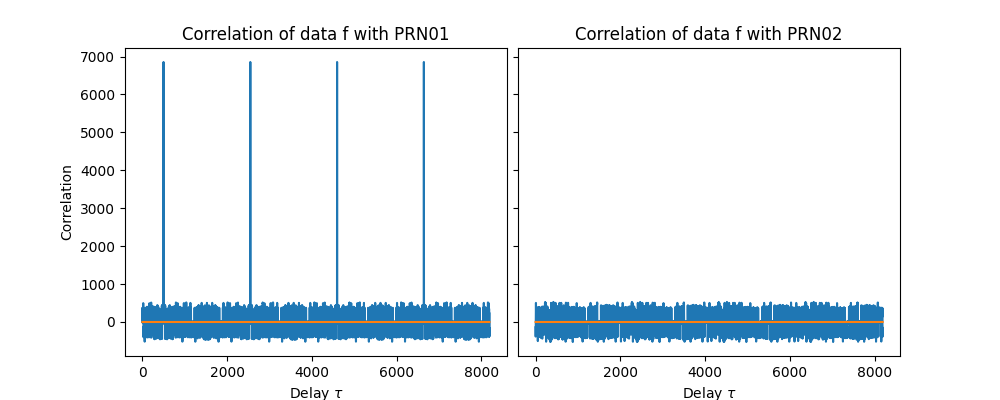

In [28]:
# Example A1: calculation of correlation using FFT

import pycode.gpslib_tutorial as gpslib
from scipy.fft import fft, ifft
import numpy as np
import matplotlib.pyplot as plt

sat_1 = 1
sat_2 = 2
codeSamples = 2048
NCopies = 4
delay = 500

def fftCorrelate(data,cacode): 
    fftData = fft(data)    
    fftCacode = fft(cacode)
    fftCorr = fftData*np.conjugate(fftCacode) 
    corr = ifft(fftCorr)
    return corr

f = gpslib.GPSCacodeRep(sat_1,codeSamples,NCopies,delay)
g1 = gpslib.GPSCacodeRep(sat_1,codeSamples,NCopies,0)
g2 = gpslib.GPSCacodeRep(sat_2,codeSamples,NCopies,0)

corr01 = fftCorrelate(f,g1)
corr02 = fftCorrelate(f,g2)


fig,ax = plt.subplots(1,2,sharey='row',figsize=(10,4))
fig.canvas.header_visible = False
plt.subplots_adjust(wspace=.03)
plt.subplot(1,2,1)
plt.plot(corr01.real)
plt.plot(corr01.imag)
plt.title('Correlation of data f with PRN01')
plt.xlabel('Delay $\\tau$')
plt.ylabel('Correlation')
plt.subplot(1,2,2)
plt.plot(corr02.real)
plt.plot(corr02.imag)
plt.title('Correlation of data f with PRN02')
plt.xlabel('Delay $\\tau$')
plt.show()

#### Relativistic correction term

For the proper time $\tau$ of a satellite at a distance $r$ from the center of the earth, the velocity $v$ for $v^2/c^2\ll 1$ and gravitational field $\Phi/c^2\ll 1$ apply:

$$ 
{\rm d}\tau = \left(1 - \frac 1 2\,\frac{v^2}{c^2} +\frac{\Phi(r)}{c^2}\right)\,{\rm d}t \qquad;\quad \Phi(r) = - \frac{G\,M_{\rm E}}{r} 
$$

with gravitational constant $G$ and earth mass $M_{\rm E}$. Let the satellite at a distance $r$ from the center of the earth be in an elliptical orbit with a large semi-axis $a$ and eccentricity $e$. Then the relationships$^1$ apply

$$
\begin{align}
v^2 &= G M_{\rm E} \left(\frac 2 r - \frac 1 a\right) \\[1ex]
 r &= a\left( 1 - e\,\cos E\right) \\[1ex]
 M &= E - e\,\sin E 
\end{align} 
$$ 

with mean anomaly $M$ and eccentric anomaly $E$. Thus

$$
{\rm d}\tau = \left(1 + \frac{G M_{\rm E}}{2 a c^2} -\frac{2 G M_{\rm E}}{a c^2}\,\frac 1 {1-e\,\cos E}\right)\,{\rm d}t \qquad\text{and}\qquad
{\rm d}M = \bigl(1-e\,\cos E\bigr)\,{\rm d}E
$$
so 
$$
{\rm d}\tau = \left(1 + \frac{G M_{\rm E}}{2 a c^2} -\frac{2 G M_{\rm E}}{a c^2}\,\frac{{\rm d}E}{{\rm d}M}\right)\,{\rm d}t 
$$
The mean anomaly $M$ is proportional to the time $t$ and becomes $2\pi$ after the circulation time $T$, so that $ {\rm d}M = \frac{2\pi}{T}\,{\rm d}t$ and

$$
{\rm d}\tau = \left(1 + \frac{G M_{\rm E}}{2 a c^2}\right)\,{\rm d}t -\frac{2 G M_{\rm E}}{a c^2}\,\frac{T}{2\pi}\,{\rm d}E \ .
$$

The integration then immediately results in

$$
\tau(t) = \left(1 + \frac{G M_{\rm E}}{2 a c^2}\right)\,t -\frac{2 G M_{\rm E}}{a c^2}\,\frac{T}{2\pi}\,E(t) \ .
$$

We replace $E$ with Kepler's equation and $M$ with $M = \frac{2\pi}{T}\,t$. Then

$$
\tau(t) = \left(1 + \frac{G M_{\rm E}}{2 a c^2}\right)\,t -\frac{2 G M_{\rm E}}{a c^2}\,t -\frac{2 G M_{\rm E}}{a c^2}\,\frac{T}{2\pi}\,e\,\sin E(t) \ .
$$

Finally, to replace the orbital period $T$ we use Kepler's third law

$$ \frac{T^2}{a^3} = \frac{4\pi^2}{G M_{\rm E}} $$

and receive

$$
\tau(t) = \left(1 - \frac 3 2\frac{G M_{\rm E}}{c^2}\frac 1 a\right)\,t -2\,\frac{\sqrt{G M_{\rm E}a}}{c^2}\,e\,\sin E(t) \ .
$$

The first term $a=R_{\rm S}$ corresponds to the time shift that increases proportionally with the time $t$, which was corrected by frequency detuning of the atomic clock in the satellite (see section *Relativistic time* in [Error sources and corrections](#Error-sources-and-corrections)). The second term is the formula given in the GPS signal specifications for correcting the periodic fluctuations as a result of the eccentricity $e$.

---
1. *Wikipedia, [Kepler equations](https://de.wikipedia.org/wiki/Kepler-Gleichung)*

## Notes

The concept of a *Software Defined Radio* for the use of GPS tracking is both simple and challenging. The subject is rich in interesting topics at the interface of mathematics, physics and digital signal processing. It quickly became apparent, however, that there is a large gap between the wealth of general information on these topics and the scarce availability of useful advice regarding the coding of a GPS tracking software.$^1$ So the idea was born to narrow this gap a little with this tutorial. 

The author is an experimental physicist and lecturer at a university. He started this project in his spare time out of curiosity and fun of coding. It is his first venture into coding with Python, so he asks for your indulgence if the code does not always conform to a *pythonic* style. Unless otherwise stated, the algorithms employed were developed by the author himself. This applies in particular to the code for data reception and the extraction of the reception time from the code phases. It is therefore possible that procedures have been used in the code that deviate from standard practice and may be improved. The author would be grateful for any comments.

The general information in the tutorial is based on several books and many sources on the Internet, some of which are mentioned in the course of the tutorial and in the References. 

---
1. *An important exception is the excellent book by Borre et al (see [References](#References))*



## References

### SDR
* [**GPS-SDR-Receiver**: Real-Time GPS Tracking using RTL-SDR and Python](#https://github.com/annappo/GPS-SDR-Receiver)
* [**RTKLIB**: An Open Source Program Package for GNSS Positioning](https://www.rtklib.com/)  
* [**GNSS-SDR**: SDR for a wide range of radio frequency front-ends and raw sample file formats](https://github.com/gnss-sdr/gnss-sdr)

### Books
* **SDR & GPS**: Basics of signal processing and detailled description of GNSS. A complete GPS software receiver is implemented (MatLab).
    * Borre et al., [A Software-Defined GPS and Galileo Receiver](https://link.springer.com/book/10.1007/978-0-8176-4540-3), Birkhäuser 2007 
* **Numerical Recipes**: An accessible and practical basis for scientific computing presented in an informal, easy-to-read style.
    * Press et al., [Numerical Recipes: The Art of Scientific Computing 3rd edition](http://numerical.recipes/book.html), Cambridge University Press
 2007

 
### Articles
* R.B. Langley, [GPS-Receiver System Noise](http://gauss.gge.unb.ca/papers.pdf/gpsworld.june97.pdf), GPS World, June, p. 40 (1997)
* K. Osen, [Accurate Conversion of Earth-Fixed Earth-Centered Coordinates to Geodetic Coordinates](https://hal.science/hal-01704943/file/AccurateEcefConversion-31oct2019.pdf), Norwegian University of Science and Technology (2017), hal-01704943v2 (Research Report)

### Websites

* **Wikipedia**: some links to discussed topics
    * [Global Positioning System](https://en.wikipedia.org/wiki/Global_Positioning_System)
    * [GPS signals](https://en.wikipedia.org/wiki/GPS_signals)
    * [Kepler's equation](https://en.wikipedia.org/wiki/Kepler%27s_equation)
    * [Jacobi-Matrix](https://de.wikipedia.org/wiki/Jacobi-Matrix)
    * [Gauß-Newton algorithm](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm)
    * [Weighted Least Squares](https://en.wikipedia.org/wiki/Weighted_least_squares)
    * [Error analysis for the Global Positioning System](https://en.wikipedia.org/wiki/Error_analysis_for_the_Global_Positioning_System)
    * [Total electron content](https://en.wikipedia.org/wiki/Total_electron_content)
    * [Ionosphäre](https://de.wikipedia.org/wiki/Ionosph%C3%A4re)
    * [Bartlett's method](https://en.wikipedia.org/wiki/Bartlett%27s_method)
    * [Welch' method](https://en.wikipedia.org/wiki/Welch's_method)
    * [Kirchhoff's law of thermal radiation](https://en.wikipedia.org/wiki/Kirchhoff%27s_law_of_thermal_radiation)
    * [Johnson–Nyquist noise](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise)
<br></br>
* **Stack Overflow**: Most valuable source of information about coding in Python (besides the official docs)
    * [stackoverflow: What does the "yield" keyword do in Python?](#https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do-in-python/231855#231855)
<br></br>
* **PySDR**: hands-on introduction to the areas of *Digital Signal Processing*, *Software Defined Radio*, and *wireless communications*
    * [PySDR: A Guide to SDR and DSP using Python](https://pysdr.org/index.html)
<br></br>
* **Learn SDR:Tutorial with Videos**: Detailed lessons using RTL-SDR with GNURadio to explore the world of digital communication
    * [LearnSDR, Harvey Mudd College](https://gallicchio.github.io/learnSDR/)
<br></br>
* **GPS Signal Specification**: official U.S. government information about the GPS
    * [Performance Standards & Specifications](https://www.gps.gov/technical/ps/)
    * (PDF) [Global Positioning System Standard Positioning Service Performance Standard, 2nd Edition (1995)](https://www.gps.gov/technical/ps/1995-SPS-signal-specification.pdf)
    * (PDF) [Global Positioning System Standard Positioning Service Performance Standard, 5th edition (2020)](https://www.gps.gov/technical/ps/2020-SPS-performance-standard.pdf)
<br></br>
* **Live positions of satellites**
    * [Live World Map of Satellite Positions](https://in-the-sky.org/satmap_radar.php)
    * [GNSS View for IOS](https://apps.apple.com/de/app/gnss-view/id924350018)
<br></br>
* **RTL-SDR**: General information
    * [superkuh.com: RTL-SDR and GNU Radio with Realtek RTL2832U (Elonics E4000/Raphael Micro R820T) software defined radio receivers](http://superkuh.com/rtlsdr.html) 
    * [rtl-sdr.com: RTL-SDR (RTL2832U) and software defined radio news and projects](https://www.rtl-sdr.com/)
    * [osmocom.org: Wiki RTL-SDR](https://osmocom.org/projects/rtl-sdr/wiki)
    * [RTL-SDR tutorial: GPS Decoding and Plotting](https://www.rtl-sdr.com/rtl-sdr-tutorial-gps-decoding-plotting/)
<br></br>
* **Device driver and modules**
    * [pyrtlsdr: a Python wrapper for librtlsdr (a driver for Realtek RTL2832U based SDR's)](https://pypi.org/project/pyrtlsdr/)
    * [Zadig: USB driver for Windows](https://zadig.akeo.ie/)
    * [Connect USB devices in WSL/Windows](https://learn.microsoft.com/en-us/windows/wsl/connect-usb)
<br></br>
* **General software**
    * [Python](https://www.python.org/)
    * [WinPython](https://winpython.github.io/#overview)
    * [JupyterLab: A Next-Generation Notebook Interface](https://jupyter.org/)
    * [How to install Linux on Windows with WSL](https://learn.microsoft.com/en-us/windows/wsl/install)
 

